In [1]:
using DifferentialEquations
using Distributions
using HDF5
using HypergeometricFunctions
using HypothesisTests
using Interpolations
using LinearAlgebra
using LsqFit
using NLsolve
using Printf
using PyPlot
using QuadGK
using SpecialFunctions
using Statistics

In [2]:
sr2 = √(2)
sr2π = √(2π)

2.5066282746310002

# Rate Moment Calculator

In [3]:
abstract type RateParams end

In [4]:
struct RicciardiParams <: RateParams
    θ::AbstractFloat
    Vr::AbstractFloat
    σn::AbstractFloat
    τs::AbstractFloat
    τr::AbstractFloat
end

In [5]:
struct SSNParams <: RateParams
    k::AbstractFloat
    n::AbstractFloat
end

In [6]:
struct αSSNParams <: RateParams
    k::AbstractFloat
    θ::AbstractFloat
    σ::AbstractFloat
    κ::AbstractFloat
    α::AbstractFloat
    n::AbstractFloat
    m::AbstractFloat
end

In [7]:
function μtox(μ::AbstractFloat)::AbstractFloat
    sign(μ/100-0.2)*abs(μ/100-0.2)^0.5
end

function xtoμ(x::AbstractFloat)::AbstractFloat
    100(sign(x)*abs(x)^2.0+0.2)
end

xtoμ (generic function with 1 method)

In [8]:
function Φint(rp::RicciardiParams,μ::AbstractFloat)
    umax = (rp.θ-μ)/rp.σn
    umin = (rp.Vr-μ)/rp.σn
    if umin > 10
        return umax*exp(-umax^2)/rp.τs
    elseif umin > -4
        return 1/(rp.τr+rp.τs*(0.5*π*(erfi(umax)-erfi(umin)) +
                umax^2*pFq([1.0,1.0],[1.5,2.0],umax^2) -
                umin^2*pFq([1.0,1.0],[1.5,2.0],umin^2)))
    else
        return 1/(rp.τr+rp.τs*(log(abs(umin))-log(abs(umax)) +
                (0.25umin^-2-0.1875umin^-4+0.3125umin^-6-
                    0.8203125umin^-8+2.953125umin^-10) -
                (0.25umax^-2-0.1875umax^-4+0.3125umax^-6-
                    0.8203125umax^-8+2.953125umax^-10)))
    end
end

function Φint(rp::SSNParams,μ::AbstractFloat)
    return rp.k*(0.5(μ+abs(μ)))^rp.n
end

function Φint(rp::αSSNParams,μ::AbstractFloat)
    z = rp.k^(1/rp.n)*(μ-rp.θ)
    zp = exp(-0.5(z/rp.σ)^2)*rp.σ/sr2π + 0.5z*(1+erf(z/(rp.σ*sr2)))
    ζ = (rp.κ/max(μ,0.0001)^rp.m + rp.α)^(1/rp.n)
    return (zp*ζ)^rp.n/(zp+ζ)^rp.n
end

function Φitp(rps::Vector{T}) where {T<:RateParams}
    xs = range(μtox(-1E3), μtox(5E5), length=2*10^5+1)
    Φint(rps[1],-100.0)
    Φint(rps[1],0.0)
    Φint(rps[1],100.0)
    global Φitps = Dict()
    for rp in rps
        Φs = [Φint(rp,xtoμ(x)) for x in xs]
        Φitps[hash(rp)] = CubicSplineInterpolation(xs, Φs, extrapolation_bc = Line())
    end
end

function Φ(rp::RateParams,μ::AbstractFloat)
    return Φitps[hash(rp)](μtox(μ))
end

function dΦ(rp::RateParams,μ::AbstractFloat)
    dμ = 0.01
    return (Φitps[hash(rp)](μtox(μ+dμ))-Φitps[hash(rp)](μtox(μ-dμ)))/(2dμ)
end

Φ (generic function with 1 method)

In [138]:
function Mint(rp::SSNParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return Φ(rp,μ)
    end
    x = μ/σ
    φ = exp(-0.5x^2)/sr2π
    ψ = 0.5*(1+erf(x/sr2))
    if n ≈ -4
        Mx = -x*(x^2-3)*φ
    elseif n ≈ -3
        Mx = (x^2-1)*φ
    elseif n ≈ -2
        Mx = -x*φ
    elseif n ≈ -1
        Mx = φ
    elseif n ≈ 0
        Mx = ψ
    elseif n ≈ 1
        Mx = φ+x*ψ
    elseif n ≈ 2
        Mx = x*φ+(1+x^2)*ψ
    elseif n ≈ 3
        Mx = (2+x^2)*φ+x*(3+x^2)*ψ
    elseif n ≈ 4
        Mx = x*(5+x^2)*φ+(3+6x^2+x^4)*ψ
    elseif n ≈ 5
        Mx = (8+9x^2+x^4)*φ+x*(15+10x^2+x^4)*ψ
    elseif n ≈ 6
        Mx = x*(3+x^2)*(11+x^2)*φ+(15+45x^2+15x^4+x^6)*ψ
    elseif n ≈ 7
        Mx = (48+87x^2+20x^4+x^6)*φ+x*(105+105x^2+21x^4+x^6)*ψ
    elseif n ≈ 8
        Mx = x*(279+185x^2+27x^4+x^6)*φ+(105+420x^2+210x^4+28x^6+x^8)*ψ
    else
        return quadgk(x->exp(-0.5x^2)/sr2π*Φ(rp,μ+σ*x),-8,8,rtol=1e-8)[1]
    end
    rp.k*σ^n*Mx
end

function Mint(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return Φ(rp,μ)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*Φ(rp,μ+σ*x),-8,8,rtol=1e-8)[1]
end

function Mitp(rps::Vector{T}) where {T<:RateParams}
    xs = range(μtox(-3000.0), μtox(3000.0), length=3000+1)
    σs = range(0.0, 600.0, length=1200+1)
    Mint(rps[1],0.0,1.0)
    global Mitps = Dict()
    for rp in rps
        Ms = [Mint(rp,xtoμ(x),σ) for x in xs, σ in σs]
        Mitps[hash(rp)] = CubicSplineInterpolation((xs,σs), Ms, extrapolation_bc = Line())
    end
end

function M(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    return Mitps[hash(rp)](μtox(μ),σ)
end

M (generic function with 1 method)

In [139]:
function Cint(rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
            σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ1,σ1)*M(rp,μ2,σ2)
    end
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        M(rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Cint(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ,σ)^2
    end
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ+sign(c)*σ*√(abs(c))*x,σ*√(1-abs(c)))*
        M(rp,μ+σ*√(abs(c))*x,σ*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Citp(rps::Vector{T}) where {T<:RateParams}
    xs = range(μtox(-1000.0), μtox(1000.0), length=400+1)
    σs = range(0.0, 600.0, length=900+1)
    cs = range(0.2, 1.0, length=48+1)
    Cint(rps[1],0.0,0.0,1.0,1.0,0.0)
    global Citps = Dict()
    for rp in rps
        Cs = [Cint(rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        Citps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), Cs,
            extrapolation_bc = Line())
    end
end

function C(rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    return Citps[hash(rp)](μtox(μ),σ,c)
end

C (generic function with 1 method)

In [11]:
rpE = RicciardiParams(20.0,10.0,10.0,0.02,0.002)
rpI = RicciardiParams(20.0,10.0,10.0,0.01,0.002)

RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002)

In [12]:
@time Φitp([rpE,rpI])

 10.417574 seconds (42.07 M allocations: 1.456 GiB, 4.75% gc time, 93.75% compilation time)


In [140]:
@time Mitp([rpE,rpI])

887.971263 seconds (26.00 G allocations: 403.038 GiB, 7.67% gc time, 0.16% compilation time)


In [141]:
@time Citp([rpE,rpI])

11537.842467 seconds (396.65 G allocations: 6.335 TiB, 9.72% gc time, 0.01% compilation time)


# Opto-Stimulated Rate Moment

In [15]:
abstract type OptoParams end

In [16]:
struct TruncNormOptoParams <: OptoParams
    f::AbstractFloat                # fraction potentially expressing opsin
    f̄::AbstractFloat                # true fraction unaffected by opsin
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
end

function TruncNormOptoParams(f::AbstractFloat,s::AbstractFloat,λL::AbstractFloat)
    f̄ = 1-f*0.5*(1+erf(1/(s*sr2)))
    TruncNormOptoParams(f,f̄,s,λL)
end

TruncNormOptoParams

In [17]:
struct LogNormOptoParams <: OptoParams
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
    μ::AbstractFloat                # mean of log opsin expression
    σ::AbstractFloat                # std of log opsin expression
end

function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
    σ2 = log(1+s^2)
    σ = √(σ2)
    μ = log(λL)-0.5σ2
    LogNormOptoParams(s,λL,μ,σ)
end

LogNormOptoParams

In [18]:
function ΦLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*Φ(rp,μ+x*op.λL),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Φ(rp,μ)
    return int
end

function ΦLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat)
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*Φ(rp,μ+x),
        0,150op.λL,rtol=1e-8)[1]
end

function ΦLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-1E3), μtox(1E5), length=10^5+1)
    ΦLint(op,rps[1],0.0)
    global ΦLitps = Dict()
    for rp in rps
        ΦLs = [ΦLint(op,rp,xtoμ(x)) for x in xs]
        ΦLitps[hash(rp)] = CubicSplineInterpolation(xs, ΦLs, extrapolation_bc = Line())
    end
end

function ΦL(op::OptoParams,rp::RateParams,μ::AbstractFloat)
    return ΦLitps[hash(rp)](μtox(μ))
end

ΦL (generic function with 1 method)

In [142]:
function MLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*M(rp,μ,σ)
    return int
end

function MLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ),
        0,150op.λL,rtol=1e-8)[1]
end

function MLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-3000.0), μtox(1000.0), length=2000+1)
    σs = range(0.0, 600.0, length=1200+1)
    MLint(op,rps[1],0.0,1.0)
    global MLitps = Dict()
    for rp in rps
        MLs = [MLint(op,rp,xtoμ(x),σ) for x in xs, σ in σs]
        MLitps[hash(rp)] = CubicSplineInterpolation((xs,σs), MLs,
            extrapolation_bc = Line())
    end
end

function ML(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    return MLitps[hash(rp)](μtox(μ),σ)
end

ML (generic function with 1 method)

In [143]:
function CLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*
                Cint(rp,μ1+x*op.λL,μ2+x*op.λL,σ1,σ2,ρ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Cint(rp,μ1,μ2,σ1,σ2,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
            M(rp,μ1+x,σ1)*M(rp,μ2+x,σ2),0,150op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                Cint(rp,μ1+x,μ2+x,σ1,σ2,ρ),0,150op.λL,rtol=1e-8)[1]
end

function CLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ)^2,
                    0,10op.s,rtol=1e-8)[1]
    else
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*C(rp,μ+x*op.λL,σ,ρ),
                    0,10op.s,rtol=1e-8)[1]
    end
    int += op.f̄*C(rp,μ,σ,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ)^2,
                    0,150op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                C(rp,μ+x,σ,ρ),0,50op.λL,rtol=1e-8)[1]
end

function CLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-1000.0), μtox(800.0), length=300+1)
    σs = range(0.0, 600.0, length=900+1)
    cs = range(0.2, 1.0, length=48+1)
    CLint(op,rps[1],0.0,1.0,0.0)
    global CLitps = Dict()
    for rp in rps
        CLs = [CLint(op,rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        CLitps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), CLs,
            extrapolation_bc = Line())
    end
end

function CL(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    return CLitps[hash(rp)](μtox(μ),σ,c)
end

CL (generic function with 1 method)

In [21]:
function RLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RL(op::OptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    return RLint(op,rp,μ1,μ2,σ1,σ2,ρ)
end

RL (generic function with 1 method)

# Network Parameters Struct

In [22]:
struct NetworkParams
    K::Int                          # mean number of E->E connections
    p::AbstractFloat                # connection probability
    γ::AbstractFloat                # ratio of I vs E cells
    sX::AbstractFloat               # std/mean of external firing rates
    rpE::RateParams                 # rate params for excitatory cells
    rpI::RateParams                 # rate params for inhibitory cells
    W::Matrix{AbstractFloat}        # O(1) recurrent coupling matrix (EIX -> EI)
end

function NetworkParams(K::Int,p::AbstractFloat,γ::AbstractFloat,gE::AbstractFloat,
        gI::AbstractFloat,β::AbstractFloat,ΓE::AbstractFloat,ΓI::AbstractFloat,
        sX::AbstractFloat,rpE::RateParams,rpI::RateParams)
    W = [1.0 -gE (ΓI*γ*gE-ΓE);
        1/β -gI/β (ΓI*γ*gI-ΓE)/β]
    NetworkParams(K,p,γ,sX,rpE,rpI,W)
end

NetworkParams

# DMFT Solvers

In [94]:
function dmft(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,Twrm::AbstractFloat,
        Tsave::AbstractFloat,dt::AbstractFloat;DE::Function=t->0.0,DI::Function=t->0.0,
        rEinit::AbstractFloat=1E-8,rIinit::AbstractFloat=1E-8,
        CrEinit::Vector{Float64}=[1E2],CrIinit::Vector{Float64}=[1E2])
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    rE = Array{Float64}(undef,Nint)
    rI = Array{Float64}(undef,Nint)
    CrE = Array{Float64}(undef,(Nint,Nint))
    CrI = Array{Float64}(undef,(Nint,Nint))

    rE[1] = rEinit
    rI[1] = rIinit
    Nσ2init = length(CrEinit)
    if Nclc >= Nσ2init
        CrE[1,1:Nσ2init] .= CrEinit
        CrE[1,Nσ2init+1:Nclc] .= CrEinit[end]
        CrE[1:Nσ2init,1] .= CrEinit
        CrE[Nσ2init+1:Nclc,1] .= CrEinit[end]
    else
        CrE[1,1:Nclc] .= CrEinit[1:Nclc]
        CrE[1:Nclc,1] .= CrEinit[1:Nclc]
    end
    Nσ2init = length(CrIinit)
    if Nclc >= Nσ2init
        CrI[1,1:Nσ2init] .= CrIinit
        CrI[1,Nσ2init+1:Nclc] .= CrIinit[end]
        CrI[1:Nσ2init,1] .= CrIinit
        CrI[Nσ2init+1:Nclc,1] .= CrIinit[end]
    else
        CrI[1,1:Nclc] .= CrIinit[1:Nclc]
        CrI[1:Nclc,1] .= CrIinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2

    for i in 1:Nint-1
        rE2 = rE[i]^2
        rI2 = rI[i]^2
        σrE20 = CrE[i,i]-rE2
        σrI20 = CrI[i,i]-rI2
        μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE[i]+np.γ*np.W[1,2]*rI[i])
        μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE[i]+np.γ*np.W[2,2]*rI[i])
        σμE20 = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20+np.γ*W2[1,2]*σrI20)
        σμI20 = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20+np.γ*W2[2,2]*σrI20)
        kE1 = -τEinv*rE[i]+τEinv*M(rpE,μE,√(σμE20))
        kI1 = -τIinv*rI[i]+τIinv*M(rpI,μI,√(σμI20))
        σrE20k = max(CrE[i,i]-(rE[i]+0.5dt*kE1)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+0.5dt*kI1)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+0.5dt*kE1)+
                np.γ*np.W[1,2]*(rI[i]+0.5dt*kI1))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+0.5dt*kE1)+
                np.γ*np.W[2,2]*(rI[i]+0.5dt*kI1))
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+0.5dt*kE1)^2+
                            np.γ*W2[1,2]*(rI[i]+0.5dt*kI1)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+0.5dt*kE1)^2+
                            np.γ*W2[2,2]*(rI[i]+0.5dt*kI1)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE2 = -τEinv*(rE[i]+0.5dt*kE1)+τEinv*M(rpE,μEk,√(σμE20k))
        kI2 = -τIinv*(rI[i]+0.5dt*kI1)+τIinv*M(rpI,μIk,√(σμI20k))
        σrE20k = max(CrE[i,i]-(rE[i]+0.5dt*kE2)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+0.5dt*kI2)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+0.5dt*kE2)+
                np.γ*np.W[1,2]*(rI[i]+0.5dt*kI2))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+0.5dt*kE2)+
                np.γ*np.W[2,2]*(rI[i]+0.5dt*kI2))
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+0.5dt*kE2)^2+
                            np.γ*W2[1,2]*(rI[i]+0.5dt*kI2)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+0.5dt*kE2)^2+
                            np.γ*W2[2,2]*(rI[i]+0.5dt*kI2)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE3 = -τEinv*(rE[i]+0.5dt*kE2)+τEinv*M(rpE,μEk,√(σμE20k))
        kI3 = -τIinv*(rI[i]+0.5dt*kI2)+τIinv*M(rpI,μIk,√(σμI20k))
        σrE20k = max(CrE[i,i]-(rE[i]+dt*kE3)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+dt*kI3)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+dt*kE3)+
                np.γ*np.W[1,2]*(rI[i]+dt*kI3))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+dt*kE3)+
                np.γ*np.W[2,2]*(rI[i]+dt*kI3))
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+dt*kE3)^2+
                            np.γ*W2[1,2]*(rI[i]+dt*kI3)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+dt*kE3)^2+
                            np.γ*W2[2,2]*(rI[i]+dt*kI3)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE4 = -τEinv*(rE[i]+dt*kE3)+τEinv*M(rpE,μEk,√(σμE20k))
        kI4 = -τIinv*(rI[i]+dt*kI3)+τIinv*M(rpI,μIk,√(σμI20k))
        rE[i+1] = rE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        rI[i+1] = rI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(rE[i+1]) > 1E10 || isnan(rE[i+1])
            @printf "CrE[%d,%d] = %f\n" i i CrE[i,i]
            @printf "CrI[%d,%d] = %f\n" i i CrI[i,i]
            @printf "rE[%d+1] = %f\n" i rE[i+1]
            @printf "rI[%d+1] = %f\n" i rI[i+1]
            @printf "μE = %f\n" μE
            @printf "μI = %f\n" μI
            @printf "σμE20 = %f\n" σμE20
            @printf "σμI20 = %f\n" σμI20
            println("system diverged")
            return (rE,rI,CrE,CrI)
        end
        if i > Nclc
            CrE[i+1,i-Nclc] = CrE[i,i-Nclc]
            CrI[i+1,i-Nclc] = CrI[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            σrE2ij = CrE[i,j]-rE2
            σrI2ij = CrI[i,j]-rI2
            σμE2ij = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                            W2[1,3]*σrX2+W2[1,1]*σrE2ij+np.γ*W2[1,2]*σrI2ij)
            σμI2ij = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                            W2[2,3]*σrX2+W2[2,1]*σrE2ij+np.γ*W2[2,2]*σrI2ij)
            CrE[i+1,j+1] = CrE[i,j+1]+CrE[i+1,j]-CrE[i,j] -
                            dtτEinv*(CrE[i+1,j]+CrE[i,j+1]-2CrE[i,j]) - dtτEinv2*CrE[i,j] +
                            dtτEinv2*C(rpE,μE,√(σμE20),σμE2ij) + dtτEinv2*DE((j-i)*dt)
            CrI[i+1,j+1] = CrI[i,j+1]+CrI[i+1,j]-CrI[i,j] -
                            dtτIinv*(CrI[i+1,j]+CrI[i,j+1]-2CrI[i,j]) - dtτIinv2*CrI[i,j] +
                            dtτIinv2*C(rpI,μI,√(σμI20),σμI2ij) + dtτIinv2*DI((j-i)*dt)
            if CrE[i+1,j+1] > 1E10 || isnan(CrE[i+1,j+1])
                @printf "rE[%d] = %f\n" i rE[i]
                @printf "rI[%d] = %f\n" i rI[i]
                @printf "CrE[%d,%d] = %f\n" i j CrE[i,j]
                @printf "CrI[%d,%d] = %f\n" i j CrI[i,j]
                @printf "CrE[%d+1,%d] = %f\n" i j CrE[i+1,j]
                @printf "CrI[%d+1,%d] = %f\n" i j CrI[i+1,j]
                @printf "CrE[%d,%d+1] = %f\n" i j CrE[i,j+1]
                @printf "CrI[%d,%d+1] = %f\n" i j CrI[i,j+1]
                @printf "μE = %f\n" μE
                @printf "μI = %f\n" μI
                @printf "σμE20 = %f\n" σμE20
                @printf "σμI20 = %f\n" σμI20
                @printf "σμE2ij = %f\n" σμE2ij
                @printf "σμI2ij = %f\n" σμI2ij
                @printf "CrE[%d+1,%d+1] = %f\n" i j CrE[i+1,j+1]
                @printf "CrI[%d+1,%d+1] = %f\n" i j CrI[i+1,j+1]
                println("system diverged")
                return (rE,rI,CrE,CrI)
            end
            CrE[j+1,i+1] = CrE[i+1,j+1]
            CrI[j+1,i+1] = CrI[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (rE[end-Nsave+1],rI[end-Nsave+1],
        CrE[end-Nsave+1,end-Nsave+1:end],CrI[end-Nsave+1,end-Nsave+1:end],
        (maximum(diag(CrE)[end-Nsave+1:end])-minimum(diag(CrE)[end-Nsave+1:end]))/
        mean(diag(CrE)[end-Nsave+1:end]) < 1E-6)
end

dmft (generic function with 1 method)

In [107]:
function optodmft(op::OptoParams,np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,
        Twrm::AbstractFloat,Tsave::AbstractFloat,dt::AbstractFloat,rE::AbstractFloat,
        rI::AbstractFloat,CrE::Vector{Float64},CrI::Vector{Float64};
        ΔrEinit::AbstractFloat=rE/2,ΔrIinit::AbstractFloat=rI/2,
        CΔrEinit::Vector{Float64}=CrE,CΔrIinit::Vector{Float64}=CrI,
        RrEΔrEinit::Vector{Float64}=-CrE/2,RrIΔrIinit::Vector{Float64}=-CrI/2)
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    ΔrE = Array{Float64}(undef,Nint)
    ΔrI = Array{Float64}(undef,Nint)
    CΔrE = Array{Float64}(undef,(Nint,Nint))
    CΔrI = Array{Float64}(undef,(Nint,Nint))
    RrEΔrE = Array{Float64}(undef,(Nint,Nint))
    RrIΔrI = Array{Float64}(undef,(Nint,Nint))

    ΔrE[1] = ΔrEinit
    ΔrI[1] = ΔrIinit
    Nσ2init = length(CΔrEinit)
    if Nclc >= Nσ2init
        CΔrE[1,1:Nσ2init] .= CΔrEinit
        CΔrE[1,Nσ2init+1:Nclc] .= CΔrEinit[end]
        CΔrE[1:Nσ2init,1] .= CΔrEinit
        CΔrE[Nσ2init+1:Nclc,1] .= CΔrEinit[end]
    else
        CΔrE[1,1:Nclc] .= CΔrEinit[1:Nclc]
        CΔrE[1:Nclc,1] .= CΔrEinit[1:Nclc]
    end
    Nσ2init = length(CΔrIinit)
    if Nclc >= Nσ2init
        CΔrI[1,1:Nσ2init] .= CΔrIinit
        CΔrI[1,Nσ2init+1:Nclc] .= CΔrIinit[end]
        CΔrI[1:Nσ2init,1] .= CΔrIinit
        CΔrI[Nσ2init+1:Nclc,1] .= CΔrIinit[end]
    else
        CΔrI[1,1:Nclc] .= CΔrIinit[1:Nclc]
        CΔrI[1:Nclc,1] .= CΔrIinit[1:Nclc]
    end
    NRrIΔrInit = length(RrEΔrEinit)
    if Nclc >= NRrIΔrInit
        RrEΔrE[1,1:NRrIΔrInit] .= RrEΔrEinit
        RrEΔrE[1,NRrIΔrInit+1:Nclc] .= RrEΔrEinit[end]
        RrEΔrE[1:NRrIΔrInit,1] .= RrEΔrEinit
        RrEΔrE[NRrIΔrInit+1:Nclc,1] .= RrEΔrEinit[end]
    else
        RrEΔrE[1,1:Nclc] .= RrEΔrEinit[1:Nclc]
        RrEΔrE[1:Nclc,1] .= RrEΔrEinit[1:Nclc]
    end
    NRrIΔrInit = length(RrIΔrIinit)
    if Nclc >= NRrIΔrInit
        RrIΔrI[1,1:NRrIΔrInit] .= RrIΔrIinit
        RrIΔrI[1,NRrIΔrInit+1:Nclc] .= RrIΔrIinit[end]
        RrIΔrI[1:NRrIΔrInit,1] .= RrIΔrIinit
        RrIΔrI[NRrIΔrInit+1:Nclc,1] .= RrIΔrIinit[end]
    else
        RrIΔrI[1,1:Nclc] .= RrIΔrIinit[1:Nclc]
        RrIΔrI[1:Nclc,1] .= RrIΔrIinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2
    
    rE2 = rE^2
    rI2 = rI^2
    σrE2 = CrE.-rE2
    σrI2 = CrI.-rI2
    μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
    
    Nσ2 = length(σμE2)
    σμE20 = σμE2[1]
    σμI20 = σμI2[1]
    CrE0 = CrE[1]
    CrI0 = CrI[1]

    for i in 1:Nint-1
        ΔrE2 = ΔrE[i]^2
        ΔrI2 = ΔrI[i]^2
        rEΔrE = rE*ΔrE[i]
        rIΔrI = rI*ΔrI[i]
        σΔrE20 = CΔrE[i,i] - ΔrE2
        σΔrI20 = CΔrI[i,i] - ΔrI2
        ρrEΔrE0 = RrEΔrE[i,i] - rEΔrE
        ρrIΔrI0 = RrIΔrI[i,i] - rIΔrI
        ΔμE = τEJK*(np.W[1,1]*ΔrE[i]+np.γ*np.W[1,2]*ΔrI[i])
        ΔμI = τIJK*(np.W[2,1]*ΔrE[i]+np.γ*np.W[2,2]*ΔrI[i])
        σΔμE20 = τE2J2K*(q*(W2[1,1]*ΔrE2+np.γ*W2[1,2]*ΔrI2) +
                        W2[1,1]*σΔrE20+np.γ*W2[1,2]*σΔrI20)
        σΔμI20 = τI2J2K*(q*(W2[2,1]*ΔrE2+np.γ*W2[2,2]*ΔrI2) +
                        W2[2,1]*σΔrE20+np.γ*W2[2,2]*σΔrI20)
        ρμEΔμE0 = τE2J2K*(q*(W2[1,1]*rEΔrE+np.γ*W2[1,2]*rIΔrI) +
                        W2[1,1]*ρrEΔrE0+np.γ*W2[1,2]*ρrIΔrI0)
        ρμIΔμI0 = τI2J2K*(q*(W2[2,1]*rEΔrE+np.γ*W2[2,2]*rIΔrI) +
                        W2[2,1]*ρrEΔrE0+np.γ*W2[2,2]*ρrIΔrI0)
        σμpΔμE20 = max(σμE20+σΔμE20+2ρμEΔμE0,0)
        σμpΔμI20 = max(σμI20+σΔμI20+2ρμIΔμI0,0)
        kE1 = -τEinv*ΔrE[i]+τEinv*(ML(op,np.rpE,μE+ΔμE,√(σμpΔμE20))-rE)
        kI1 = -τIinv*ΔrI[i]+τIinv*(M(np.rpI,μI+ΔμI,√(σμpΔμI20))-rI)
        σΔrE20k = max(CΔrE[i,i] - (ΔrE[i]+0.5dt*kE1)^2,0)
        σΔrI20k = max(CΔrI[i,i] - (ΔrI[i]+0.5dt*kI1)^2,0)
        ρrEΔrE0k = RrEΔrE[i,i] - rE*(ΔrE[i]+0.5dt*kE1)
        ρrIΔrI0k = RrIΔrI[i,i] - rI*(ΔrI[i]+0.5dt*kI1)
        ΔμEk = τEJK*(np.W[1,1]*(ΔrE[i]+0.5dt*kE1)+np.γ*np.W[1,2]*(ΔrI[i]+0.5dt*kI1))
        ΔμIk = τIJK*(np.W[2,1]*(ΔrE[i]+0.5dt*kE1)+np.γ*np.W[2,2]*(ΔrI[i]+0.5dt*kI1))
        σΔμE20k = τE2J2K*(q*(W2[1,1]*(ΔrE[i]+0.5dt*kE1)^2+
                            np.γ*W2[1,2]*(ΔrI[i]+0.5dt*kI1)^2) +
                        W2[1,1]*σΔrE20k+np.γ*W2[1,2]*σΔrI20k)
        σΔμI20k = τI2J2K*(q*(W2[2,1]*(ΔrE[i]+0.5dt*kE1)^2+
                            np.γ*W2[2,2]*(ΔrI[i]+0.5dt*kI1)^2) +
                        W2[2,1]*σΔrE20k+np.γ*W2[2,2]*σΔrI20k)
        ρμEΔμE0k = τE2J2K*(q*(W2[1,1]*rE*(ΔrE[i]+0.5dt*kE1)+
                            np.γ*W2[1,2]*rI*(ΔrI[i]+0.5dt*kI1)) +
                        W2[1,1]*ρrEΔrE0k+np.γ*W2[1,2]*ρrIΔrI0k)
        ρμIΔμI0k = τI2J2K*(q*(W2[2,1]*rE*(ΔrE[i]+0.5dt*kE1)+
                            np.γ*W2[2,2]*rI*(ΔrI[i]+0.5dt*kI1)) +
                        W2[2,1]*ρrEΔrE0k+np.γ*W2[2,2]*ρrIΔrI0k)
        σμpΔμE20k = max(σμE20+σΔμE20k+2ρμEΔμE0k,0)
        σμpΔμI20k = max(σμI20+σΔμI20k+2ρμIΔμI0k,0)
        kE2 = -τEinv*(ΔrE[i]+0.5dt*kE1)+τEinv*(ML(op,np.rpE,μE+ΔμEk,√(σμpΔμE20k))-rE)
        kI2 = -τIinv*(ΔrI[i]+0.5dt*kI1)+τIinv*(M(np.rpI,μI+ΔμIk,√(σμpΔμI20k))-rI)
        σΔrE20k = max(CΔrE[i,i] - (ΔrE[i]+0.5dt*kE2)^2,0)
        σΔrI20k = max(CΔrI[i,i] - (ΔrI[i]+0.5dt*kI2)^2,0)
        ρrEΔrE0k = RrEΔrE[i,i] - rE*(ΔrE[i]+0.5dt*kE2)
        ρrIΔrI0k = RrIΔrI[i,i] - rI*(ΔrI[i]+0.5dt*kI2)
        ΔμEk = τEJK*(np.W[1,1]*(ΔrE[i]+0.5dt*kE2)+np.γ*np.W[1,2]*(ΔrI[i]+0.5dt*kI2))
        ΔμIk = τIJK*(np.W[2,1]*(ΔrE[i]+0.5dt*kE2)+np.γ*np.W[2,2]*(ΔrI[i]+0.5dt*kI2))
        σΔμE20k = τE2J2K*(q*(W2[1,1]*(ΔrE[i]+0.5dt*kE2)^2+
                            np.γ*W2[1,2]*(ΔrI[i]+0.5dt*kI2)^2) +
                        W2[1,1]*σΔrE20k+np.γ*W2[1,2]*σΔrI20k)
        σΔμI20k = τI2J2K*(q*(W2[2,1]*(ΔrE[i]+0.5dt*kE2)^2+
                            np.γ*W2[2,2]*(ΔrI[i]+0.5dt*kI2)^2) +
                        W2[2,1]*σΔrE20k+np.γ*W2[2,2]*σΔrI20k)
        ρμEΔμE0k = τE2J2K*(q*(W2[1,1]*rE*(ΔrE[i]+0.5dt*kE2)+
                            np.γ*W2[1,2]*rI*(ΔrI[i]+0.5dt*kI2)) +
                        W2[1,1]*ρrEΔrE0k+np.γ*W2[1,2]*ρrIΔrI0k)
        ρμIΔμI0k = τI2J2K*(q*(W2[2,1]*rE*(ΔrE[i]+0.5dt*kE2)+
                            np.γ*W2[2,2]*rI*(ΔrI[i]+0.5dt*kI2)) +
                        W2[2,1]*ρrEΔrE0k+np.γ*W2[2,2]*ρrIΔrI0k)
        σμpΔμE20k = max(σμE20+σΔμE20k+2ρμEΔμE0k,0)
        σμpΔμI20k = max(σμI20+σΔμI20k+2ρμIΔμI0k,0)
        kE3 = -τEinv*(ΔrE[i]+0.5dt*kE2)+τEinv*(ML(op,np.rpE,μE+ΔμEk,√(σμpΔμE20k))-rE)
        kI3 = -τIinv*(ΔrI[i]+0.5dt*kI2)+τIinv*(M(np.rpI,μI+ΔμIk,√(σμpΔμI20k))-rI)
        σΔrE20k = max(CΔrE[i,i] - (ΔrE[i]+dt*kE3)^2,0)
        σΔrI20k = max(CΔrI[i,i] - (ΔrI[i]+dt*kI3)^2,0)
        ρrEΔrE0k = RrEΔrE[i,i] - rE*(ΔrE[i]+dt*kE3)
        ρrIΔrI0k = RrIΔrI[i,i] - rI*(ΔrI[i]+dt*kI3)
        ΔμEk = τEJK*(np.W[1,1]*(ΔrE[i]+dt*kE3)+np.γ*np.W[1,2]*(ΔrI[i]+dt*kI3))
        ΔμIk = τIJK*(np.W[2,1]*(ΔrE[i]+dt*kE3)+np.γ*np.W[2,2]*(ΔrI[i]+dt*kI3))
        σΔμE20k = τE2J2K*(q*(W2[1,1]*(ΔrE[i]+dt*kE3)^2+
                            np.γ*W2[1,2]*(ΔrI[i]+dt*kI3)^2) +
                        W2[1,1]*σΔrE20k+np.γ*W2[1,2]*σΔrI20k)
        σΔμI20k = τI2J2K*(q*(W2[2,1]*(ΔrE[i]+dt*kE3)^2+
                            np.γ*W2[2,2]*(ΔrI[i]+dt*kI3)^2) +
                        W2[2,1]*σΔrE20k+np.γ*W2[2,2]*σΔrI20k)
        ρμEΔμE0k = τE2J2K*(q*(W2[1,1]*rE*(ΔrE[i]+dt*kE3)+
                            np.γ*W2[1,2]*rI*(ΔrI[i]+dt*kI3)) +
                        W2[1,1]*ρrEΔrE0k+np.γ*W2[1,2]*ρrIΔrI0k)
        ρμIΔμI0k = τI2J2K*(q*(W2[2,1]*rE*(ΔrE[i]+dt*kE3)+
                            np.γ*W2[2,2]*rI*(ΔrI[i]+dt*kI3)) +
                        W2[2,1]*ρrEΔrE0k+np.γ*W2[2,2]*ρrIΔrI0k)
        σμpΔμE20k = max(σμE20+σΔμE20k+2ρμEΔμE0k,0)
        σμpΔμI20k = max(σμI20+σΔμI20k+2ρμIΔμI0k,0)
        kE4 = -τEinv*(ΔrE[i]+dt*kE3)+τEinv*(ML(op,np.rpE,μE+ΔμEk,√(σμpΔμE20k))-rE)
        kI4 = -τIinv*(ΔrI[i]+dt*kI3)+τIinv*(M(np.rpI,μI+ΔμIk,√(σμpΔμI20k))-rI)
        ΔrE[i+1] = ΔrE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        ΔrI[i+1] = ΔrI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(ΔrE[i+1]) > 1E10 || isnan(ΔrE[i+1])
            @printf "CΔrE[%d,%d] = %f\n" i i CΔrE[i,i]
            @printf "CΔrI[%d,%d] = %f\n" i i CΔrI[i,i]
            @printf "ΔrE[%d+1] = %f\n" i ΔrE[i+1]
            @printf "ΔrI[%d+1] = %f\n" i ΔrI[i+1]
            @printf "ΔμE = %f\n" ΔμE
            @printf "ΔμI = %f\n" ΔμI
            @printf "σμpΔμE20 = %f\n" σμpΔμE20
            @printf "σμpΔμI20 = %f\n" σμpΔμI20
            println("system diverged")
            return (ΔrE,ΔrI,CΔrE,CΔrI)
        end
        if i > Nclc
            CΔrE[i+1,i-Nclc] = CΔrE[i,i-Nclc]
            CΔrI[i+1,i-Nclc] = CΔrI[i,i-Nclc]
            RrEΔrE[i+1,i-Nclc] = RrEΔrE[i,i-Nclc]
            RrIΔrI[i+1,i-Nclc] = RrIΔrI[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            CrEij = abs(j-i) < Nσ2 ? CrE[abs(j-i)+1] : CrE[end]
            CrIij = abs(j-i) < Nσ2 ? CrI[abs(j-i)+1] : CrI[end]
            σΔrE2ij = CΔrE[i,j] - ΔrE2
            σΔrI2ij = CΔrI[i,j] - ΔrI2
            ρrEΔrEij = RrEΔrE[i,j] - rEΔrE
            ρrIΔrIij = RrIΔrI[i,j] - rIΔrI
            σμE2ij = abs(j-i) < Nσ2 ? σμE2[abs(j-i)+1] : σμE2[end]
            σμI2ij = abs(j-i) < Nσ2 ? σμI2[abs(j-i)+1] : σμI2[end]
            σΔμE2ij = τE2J2K*(q*(W2[1,1]*ΔrE2+np.γ*W2[1,2]*ΔrI2) +
                            W2[1,1]*σΔrE2ij+np.γ*W2[1,2]*σΔrI2ij)
            σΔμI2ij = τI2J2K*(q*(W2[2,1]*ΔrE2+np.γ*W2[2,2]*ΔrI2) +
                            W2[2,1]*σΔrE2ij+np.γ*W2[2,2]*σΔrI2ij)
            ρμEΔμEij = τE2J2K*(q*(W2[1,1]*rEΔrE+np.γ*W2[1,2]*rIΔrI) +
                            W2[1,1]*ρrEΔrEij+np.γ*W2[1,2]*ρrIΔrIij)
            ρμIΔμIij = τI2J2K*(q*(W2[2,1]*rEΔrE+np.γ*W2[2,2]*rIΔrI) +
                            W2[2,1]*ρrEΔrEij+np.γ*W2[2,2]*ρrIΔrIij)
            σμpΔμE2ij = σμE2ij+σΔμE2ij+2ρμEΔμEij
            σμpΔμI2ij = σμI2ij+σΔμI2ij+2ρμIΔμIij
            RrErEL = RL(op,np.rpE,μE,μE+ΔμE,√(σμE20),√(σμpΔμE20),σμE2ij+ρμEΔμEij)
            RrIrIL = Cint(np.rpI,μI,μI+ΔμI,√(σμI20),√(σμpΔμI20),σμI2ij+ρμIΔμIij)
            CΔrE[i+1,j+1] = CΔrE[i,j+1]+CΔrE[i+1,j]-CΔrE[i,j] -
                            dtτEinv*(CΔrE[i+1,j]+CΔrE[i,j+1]-2CΔrE[i,j]) -
                            dtτEinv2*CΔrE[i,j] +
                            dtτEinv2*(CL(op,np.rpE,μE+ΔμE,√(σμpΔμE20),σμpΔμE2ij)-
                                2RrErEL+CrEij)
            CΔrI[i+1,j+1] = CΔrI[i,j+1]+CΔrI[i+1,j]-CΔrI[i,j] -
                            dtτIinv*(CΔrI[i+1,j]+CΔrI[i,j+1]-2CΔrI[i,j]) -
                            dtτIinv2*CΔrI[i,j] +
                            dtτIinv2*(C(np.rpI,μI+ΔμI,√(σμpΔμI20),σμpΔμI2ij)-
                                2RrIrIL+CrIij)
            if CΔrE[i+1,j+1] > 1E10 || isnan(CΔrE[i+1,j+1])
                @printf "ΔrE[%d] = %f\n" i ΔrE[i]
                @printf "ΔrI[%d] = %f\n" i ΔrI[i]
                @printf "CΔrE[%d,%d] = %f\n" i i CΔrE[i,i]
                @printf "CΔrI[%d,%d] = %f\n" i i CΔrI[i,i]
                @printf "σμE2ij = %f\n" σμE2ij
                @printf "σμI2ij = %f\n" σμI2ij
                @printf "CΔrE[%d+1,%d+1] = %f\n" i j CΔrE[i+1,j+1]
                @printf "CΔrI[%d+1,%d+1] = %f\n" i j CΔrI[i+1,j+1]
                println("system diverged")
                return (ΔrE,ΔrI,CΔrE,CΔrI)
            end
            CΔrE[j+1,i+1] = CΔrE[i+1,j+1]
            CΔrI[j+1,i+1] = CΔrI[i+1,j+1]
            RrEΔrE[i+1,j+1] = RrEΔrE[i,j+1]+RrEΔrE[i+1,j]-RrEΔrE[i,j] -
                            dtτEinv*(RrEΔrE[i+1,j]+RrEΔrE[i,j+1]-2RrEΔrE[i,j]) -
                            dtτEinv2*RrEΔrE[i,j] + dtτEinv2*(RrErEL-CrEij)
            RrIΔrI[i+1,j+1] = RrIΔrI[i,j+1]+RrIΔrI[i+1,j]-RrIΔrI[i,j] -
                            dtτIinv*(RrIΔrI[i+1,j]+RrIΔrI[i,j+1]-2RrIΔrI[i,j]) -
                            dtτIinv2*RrIΔrI[i,j] + dtτIinv2*(RrIrIL-CrIij)
            RrEΔrE[j+1,i+1] = RrEΔrE[i+1,j+1]
            RrIΔrI[j+1,i+1] = RrIΔrI[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (ΔrE[end-Nsave+1],ΔrI[end-Nsave+1],
        CΔrE[end-Nsave+1,end-Nsave+1:end],CΔrI[end-Nsave+1,end-Nsave+1:end],
        RrEΔrE[end-Nsave+1,end-Nsave+1:end],RrIΔrI[end-Nsave+1,end-Nsave+1:end],
        (maximum(diag(CΔrE)[end-Nsave+1:end])-minimum(diag(CΔrE)[end-Nsave+1:end]))/
        mean(diag(CΔrE)[end-Nsave+1:end]) < 1E-6)
end

optodmft (generic function with 1 method)

In [159]:
function isndmft(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,Twrm::AbstractFloat,
        Tsave::AbstractFloat,dt::AbstractFloat;DE::Function=t->0.0,DI::Function=t->0.0,
        rEinit::AbstractFloat=1E-8,rIinit::AbstractFloat=1E-8,
        CrEinit::Vector{Float64}=[1E2],CrIinit::Vector{Float64}=[1E2])
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    rE = Array{Float64}(undef,Nint)
    rI = Array{Float64}(undef,Nint)
    CrE = Array{Float64}(undef,(Nint,Nint))
    CrI = Array{Float64}(undef,(Nint,Nint))

    rE[1] = rEinit
    rI[1] = rIinit
    Nσ2init = length(CrEinit)
    if Nclc >= Nσ2init
        CrE[1,1:Nσ2init] .= CrEinit
        CrE[1,Nσ2init+1:Nclc] .= CrEinit[end]
        CrE[1:Nσ2init,1] .= CrEinit
        CrE[Nσ2init+1:Nclc,1] .= CrEinit[end]
    else
        CrE[1,1:Nclc] .= CrEinit[1:Nclc]
        CrE[1:Nclc,1] .= CrEinit[1:Nclc]
    end
    Nσ2init = length(CrIinit)
    if Nclc >= Nσ2init
        CrI[1,1:Nσ2init] .= CrIinit
        CrI[1,Nσ2init+1:Nclc] .= CrIinit[end]
        CrI[1:Nσ2init,1] .= CrIinit
        CrI[Nσ2init+1:Nclc,1] .= CrIinit[end]
    else
        CrI[1,1:Nclc] .= CrIinit[1:Nclc]
        CrI[1:Nclc,1] .= CrIinit[1:Nclc]
    end
    
    τE = 0.02
    τI = 0.01
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2

    for i in 1:Nint-1
        rE2 = rE[i]^2
        rI2 = rI[i]^2
        σrE20 = CrE[i,i]-rE2
        σrI20 = CrI[i,i]-rI2
        μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE[i]+np.γ*np.W[1,2]*rI[i])
        μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE[i]+np.γ*np.W[2,2]*rI[i]+10.0)
        σμE20 = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20+np.γ*W2[1,2]*σrI20)
        σμI20 = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20+np.γ*W2[2,2]*σrI20)
        kE1 = -τEinv*rE[i]+τEinv*M(rpE,μE,√(σμE20))
        kI1 = -τIinv*rI[i]+τIinv*M(rpI,μI,√(σμI20))
        σrE20k = max(CrE[i,i]-(rE[i]+0.5dt*kE1)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+0.5dt*kI1)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+0.5dt*kE1)+
                np.γ*np.W[1,2]*(rI[i]+0.5dt*kI1))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+0.5dt*kE1)+
                np.γ*np.W[2,2]*(rI[i]+0.5dt*kI1)+10.0)
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+0.5dt*kE1)^2+
                            np.γ*W2[1,2]*(rI[i]+0.5dt*kI1)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+0.5dt*kE1)^2+
                            np.γ*W2[2,2]*(rI[i]+0.5dt*kI1)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE2 = -τEinv*(rE[i]+0.5dt*kE1)+τEinv*M(rpE,μEk,√(σμE20k))
        kI2 = -τIinv*(rI[i]+0.5dt*kI1)+τIinv*M(rpI,μIk,√(σμI20k))
        σrE20k = max(CrE[i,i]-(rE[i]+0.5dt*kE2)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+0.5dt*kI2)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+0.5dt*kE2)+
                np.γ*np.W[1,2]*(rI[i]+0.5dt*kI2))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+0.5dt*kE2)+
                np.γ*np.W[2,2]*(rI[i]+0.5dt*kI2)+10.0)
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+0.5dt*kE2)^2+
                            np.γ*W2[1,2]*(rI[i]+0.5dt*kI2)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+0.5dt*kE2)^2+
                            np.γ*W2[2,2]*(rI[i]+0.5dt*kI2)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE3 = -τEinv*(rE[i]+0.5dt*kE2)+τEinv*M(rpE,μEk,√(σμE20k))
        kI3 = -τIinv*(rI[i]+0.5dt*kI2)+τIinv*M(rpI,μIk,√(σμI20k))
        σrE20k = max(CrE[i,i]-(rE[i]+dt*kE3)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+dt*kI3)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+dt*kE3)+
                np.γ*np.W[1,2]*(rI[i]+dt*kI3))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+dt*kE3)+
                np.γ*np.W[2,2]*(rI[i]+dt*kI3)+10.0)
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+dt*kE3)^2+
                            np.γ*W2[1,2]*(rI[i]+dt*kI3)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+dt*kE3)^2+
                            np.γ*W2[2,2]*(rI[i]+dt*kI3)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE4 = -τEinv*(rE[i]+dt*kE3)+τEinv*M(rpE,μEk,√(σμE20k))
        kI4 = -τIinv*(rI[i]+dt*kI3)+τIinv*M(rpI,μIk,√(σμI20k))
        rE[i+1] = rE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        rI[i+1] = rI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(rE[i+1]) > 1E10 || isnan(rE[i+1])
            @printf "CrE[%d,%d] = %f\n" i i CrE[i,i]
            @printf "CrI[%d,%d] = %f\n" i i CrI[i,i]
            @printf "rE[%d+1] = %f\n" i rE[i+1]
            @printf "rI[%d+1] = %f\n" i rI[i+1]
            @printf "μE = %f\n" μE
            @printf "μI = %f\n" μI
            @printf "σμE20 = %f\n" σμE20
            @printf "σμI20 = %f\n" σμI20
            println("system diverged")
            return (rE,rI,CrE,CrI)
        end
        if i > Nclc
            CrE[i+1,i-Nclc] = CrE[i,i-Nclc]
            CrI[i+1,i-Nclc] = CrI[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            σrE2ij = CrE[i,j]-rE2
            σrI2ij = CrI[i,j]-rI2
            σμE2ij = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                            W2[1,3]*σrX2+W2[1,1]*σrE2ij+np.γ*W2[1,2]*σrI2ij)
            σμI2ij = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                            W2[2,3]*σrX2+W2[2,1]*σrE2ij+np.γ*W2[2,2]*σrI2ij)
            CrE[i+1,j+1] = CrE[i,j+1]+CrE[i+1,j]-CrE[i,j] -
                            dtτEinv*(CrE[i+1,j]+CrE[i,j+1]-2CrE[i,j]) - dtτEinv2*CrE[i,j] +
                            dtτEinv2*C(rpE,μE,√(σμE20),σμE2ij) + dtτEinv2*DE((j-i)*dt)
            CrI[i+1,j+1] = CrI[i,j+1]+CrI[i+1,j]-CrI[i,j] -
                            dtτIinv*(CrI[i+1,j]+CrI[i,j+1]-2CrI[i,j]) - dtτIinv2*CrI[i,j] +
                            dtτIinv2*C(rpI,μI,√(σμI20),σμI2ij) + dtτIinv2*DI((j-i)*dt)
            if CrE[i+1,j+1] > 1E10 || isnan(CrE[i+1,j+1])
                @printf "rE[%d] = %f\n" i rE[i]
                @printf "rI[%d] = %f\n" i rI[i]
                @printf "CrE[%d,%d] = %f\n" i j CrE[i,j]
                @printf "CrI[%d,%d] = %f\n" i j CrI[i,j]
                @printf "CrE[%d+1,%d] = %f\n" i j CrE[i+1,j]
                @printf "CrI[%d+1,%d] = %f\n" i j CrI[i+1,j]
                @printf "CrE[%d,%d+1] = %f\n" i j CrE[i,j+1]
                @printf "CrI[%d,%d+1] = %f\n" i j CrI[i,j+1]
                @printf "μE = %f\n" μE
                @printf "μI = %f\n" μI
                @printf "σμE20 = %f\n" σμE20
                @printf "σμI20 = %f\n" σμI20
                @printf "σμE2ij = %f\n" σμE2ij
                @printf "σμI2ij = %f\n" σμI2ij
                @printf "CrE[%d+1,%d+1] = %f\n" i j CrE[i+1,j+1]
                @printf "CrI[%d+1,%d+1] = %f\n" i j CrI[i+1,j+1]
                println("system diverged")
                return (rE,rI,CrE,CrI)
            end
            CrE[j+1,i+1] = CrE[i+1,j+1]
            CrI[j+1,i+1] = CrI[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (rE[end-Nsave+1],rI[end-Nsave+1],
        CrE[end-Nsave+1,end-Nsave+1:end],CrI[end-Nsave+1,end-Nsave+1:end],
        abs(CrE[end,end]-CrE[end-Nsave+1,end-Nsave+1])/
        CrE[end-(Nsave÷2)+1,end-(Nsave÷2)+1] < 1E-6)
end

isndmft (generic function with 1 method)

# Panels A & B

In [25]:
# function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
op = LogNormOptoParams(2.154435,20.0)

LogNormOptoParams(2.154435, 20.0, 2.130649288219479, 1.3153577348649392)

In [26]:
@time ΦLitp(op,[rpE])

 31.272916 seconds (796.65 M allocations: 12.376 GiB, 9.87% gc time, 9.43% compilation time)


In [144]:
@time MLitp(op,[rpE])

524.858004 seconds (17.35 G allocations: 264.752 GiB, 8.28% gc time, 0.38% compilation time)


In [145]:
@time CLitp(op,[rpE])

3097.694575 seconds (99.35 G allocations: 1.481 TiB, 8.14% gc time, 0.10% compilation time)


In [29]:
# function NetworkParams(K::Int,p::AbstractFloat,γ::AbstractFloat,gE::AbstractFloat,
#         gI::AbstractFloat,β::AbstractFloat,ΓE::AbstractFloat,ΓI::AbstractFloat,
#         sX::AbstractFloat,rpE::RateParams,rpI::RateParams)
np = NetworkParams(500,0.1,0.25,8.0,3.0,1.0,1.0,2.0,0.2,rpE,rpI)

NetworkParams(500, 0.1, 0.25, 0.2, RicciardiParams(20.0, 10.0, 10.0, 0.02, 0.002), RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002), AbstractFloat[1.0 -8.0 3.0; 1.0 -3.0 0.5])

## Phase Plot

In [250]:
# rXPs = 1*10.0.^range(0, 2, length=15)
# JPs = 1*10.0.^range(-2, 1, length=22)[3:17]
# chPs = zeros(Bool,length(JPs),length(rXPs))
# convPs = zeros(Bool,length(JPs),length(rXPs))
# μEPs = zeros(length(JPs),length(rXPs))
# μIPs = zeros(length(JPs),length(rXPs))
# ΔμEPs = zeros(length(JPs),length(rXPs))
# ΔμIPs = zeros(length(JPs),length(rXPs))
# σμE2Ps = zeros(length(JPs),length(rXPs))
# σμI2Ps = zeros(length(JPs),length(rXPs))
# σΔμE2Ps = zeros(length(JPs),length(rXPs))
# σΔμI2Ps = zeros(length(JPs),length(rXPs))
# ρμEΔμEPs = zeros(length(JPs),length(rXPs))
# ρμIΔμIPs = zeros(length(JPs),length(rXPs))
# rEPs = zeros(length(JPs),length(rXPs))
# rIPs = zeros(length(JPs),length(rXPs))
# ΔrEPs = zeros(length(JPs),length(rXPs))
# ΔrIPs = zeros(length(JPs),length(rXPs))
# σrE2Ps = zeros(length(JPs),length(rXPs))
# σrI2Ps = zeros(length(JPs),length(rXPs))
# σΔrE2Ps = zeros(length(JPs),length(rXPs))
# σΔrI2Ps = zeros(length(JPs),length(rXPs))
# ρrEΔrEPs = zeros(length(JPs),length(rXPs))
# ρrIΔrIPs = zeros(length(JPs),length(rXPs))

h5open("fig4.h5", "r") do fid
    P = fid["P"]
    global rXPs = read(P,"r_Xs")
    global JPs = read(P,"Js")
    global chPs = Matrix{Bool}(read(P,"chs"))
    global convPs = Matrix{Bool}(read(P,"convs"))
    global μEPs = read(P,"mu_Es")
    global μIPs = read(P,"mu_Is")
    global ΔμEPs = read(P,"delta_mu_Es")
    global ΔμIPs = read(P,"delta_mu_Is")
    global σμE2Ps = read(P,"var_mu_Es")
    global σμI2Ps = read(P,"var_mu_Is")
    global σΔμE2Ps = read(P,"var_delta_mu_Es")
    global σΔμI2Ps = read(P,"var_delta_mu_Is")
    global ρμEΔμEPs = read(P,"cov_mu_E_delta_mu_Es")
    global ρμIΔμIPs = read(P,"cov_mu_I_delta_mu_Is")
    global rEPs = read(P,"r_Es")
    global rIPs = read(P,"r_Is")
    global ΔrEPs = read(P,"delta_r_Es")
    global ΔrIPs = read(P,"delta_r_Is")
    global σrE2Ps = read(P,"var_r_Es")
    global σrI2Ps = read(P,"var_r_Is")
    global σΔrE2Ps = read(P,"var_delta_r_Es")
    global σΔrI2Ps = read(P,"var_delta_r_Is")
    global ρrEΔrEPs = read(P,"cov_r_E_delta_r_Es")
    global ρrIΔrIPs = read(P,"cov_r_I_delta_r_Is")
end

15×15 Matrix{Float64}:
 0.00326691  0.00330063  0.00334308  …      4.04347       4.52147
 0.00829491  0.00886425  0.0097615          7.70272       5.45213
 0.0153819   0.0173687   0.020836           9.87174       5.01899
 0.0310477   0.0370073   0.048598          11.1119        2.27649
 0.062643    0.0790979   0.117203          11.9344       -3.22904
 0.115786    0.163388    0.29208     …     13.0113      -12.1873
 0.192746    0.312308    0.672355          13.8183      -24.8035
 0.314195    0.586335    1.33383           11.4102      -40.1228
 0.500886    1.02394     2.27338           -0.447266    -54.853
 0.776712    1.65331     3.54141          -27.6819      -67.2054
 1.17301     2.52501     5.1801      …    -78.7363      -80.0271
 1.74422     3.72745     7.23653         -215.211      -117.902
 2.60738     5.31684     6.58699         -460.573      -263.589
 3.97937     2.43634     3.45829         -273.54      -1021.88
 5.60984     7.42083     4.14798        -1303.42      -3369.48

In [245]:
for i in [12:15;],#eachindex(JPs),
        j in eachindex(rXPs)
    if i == 12 && j <= 9
        continue
    end
    npK = NetworkParams(4*500,0.1,0.25,8.0,3.0,1.0,1.0,2.0,0.2,rpE,rpI)
    J = JPs[i]/2
    rX = rXPs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.01/6
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(npK,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rE,rI,CrE,CrI,conv = dmft(npK,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    convPs[i,j] = conv
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,npK,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 8
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,npK,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    convPs[i,j] &= conv
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-npK.p
    τEJK = npK.rpE.τs*J*npK.K
    τIJK = npK.rpI.τs*J*npK.K
    J2K = J^2*npK.K
    τE2J2K = npK.rpE.τs^2*J^2*npK.K
    τI2J2K = npK.rpE.τs^2*J^2*npK.K
    W2 = npK.W.^2
    σrX2 = (npK.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(npK.W[1,3]*rX+npK.W[1,1]*rE+npK.γ*npK.W[1,2]*rI)
    μI = τIJK*(npK.W[2,3]*rX+npK.W[2,1]*rE+npK.γ*npK.W[2,2]*rI)
    ΔμE = τEJK*(npK.W[1,1]*ΔrE+npK.γ*npK.W[1,2]*ΔrI)
    ΔμI = τIJK*(npK.W[2,1]*ΔrE+npK.γ*npK.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+npK.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+npK.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+npK.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+npK.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+npK.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+npK.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+npK.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+npK.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+npK.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+npK.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+npK.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+npK.γ*W2[2,2]*ρrIΔrI)
    
    chPs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μEPs[i,j] = μE
    μIPs[i,j] = μI
    ΔμEPs[i,j] = ΔμE
    ΔμIPs[i,j] = ΔμI
    σμE2Ps[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2Ps[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2Ps[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2Ps[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμEPs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμIPs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rEPs[i,j] = rE
    rIPs[i,j] = rI
    ΔrEPs[i,j] = ΔrE
    ΔrIPs[i,j] = ΔrI
    σrE2Ps[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2Ps[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2Ps[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2Ps[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrEPs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrIPs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(rXPs)*(i-1)+j length(JPs)*length(rXPs)
end

  2.379074 seconds (19.01 M allocations: 300.887 MiB)
  3.213536 seconds (19.01 M allocations: 300.887 MiB, 67.50% gc time)
158.194469 seconds (5.60 G allocations: 93.569 GiB, 9.88% gc time)
154.414401 seconds (5.63 G allocations: 94.184 GiB, 9.85% gc time)
175/225 completed
  0.945100 seconds (19.01 M allocations: 300.887 MiB, 31.16% gc time)
  1.514463 seconds (19.01 M allocations: 300.887 MiB)
  2.175262 seconds (19.01 M allocations: 300.887 MiB)
156.871823 seconds (5.51 G allocations: 92.211 GiB, 10.39% gc time)
156.018296 seconds (5.54 G allocations: 92.752 GiB, 10.30% gc time)
149.868483 seconds (5.54 G allocations: 92.759 GiB, 10.45% gc time)
176/225 completed
  0.635769 seconds (19.01 M allocations: 300.887 MiB)
  0.879462 seconds (19.01 M allocations: 300.887 MiB, 42.67% gc time)
  0.501605 seconds (19.01 M allocations: 300.887 MiB)
  1.073014 seconds (19.01 M allocations: 300.887 MiB)
  1.655288 seconds (19.01 M allocations: 300.887 MiB, 9.98% gc time)
  0.489762 seconds (19.

  0.888313 seconds (19.01 M allocations: 300.887 MiB, 36.02% gc time)
  0.549802 seconds (19.01 M allocations: 300.887 MiB)
113.631915 seconds (3.95 G allocations: 65.854 GiB, 10.80% gc time)
212/225 completed
  0.889539 seconds (19.01 M allocations: 300.887 MiB, 37.69% gc time)
113.629676 seconds (3.96 G allocations: 65.958 GiB, 10.71% gc time)
213/225 completed
  0.541663 seconds (19.01 M allocations: 300.887 MiB)
113.902980 seconds (3.97 G allocations: 66.103 GiB, 10.77% gc time)
214/225 completed
  0.874268 seconds (19.01 M allocations: 300.887 MiB, 37.61% gc time)
114.753429 seconds (3.95 G allocations: 65.889 GiB, 10.78% gc time)
215/225 completed
  0.537481 seconds (19.01 M allocations: 300.887 MiB)
115.554466 seconds (3.97 G allocations: 66.213 GiB, 10.94% gc time)
216/225 completed
  0.825459 seconds (19.01 M allocations: 300.887 MiB, 36.71% gc time)
116.419921 seconds (4.03 G allocations: 67.089 GiB, 10.67% gc time)
217/225 completed
  0.864369 seconds (19.01 M allocations: 3

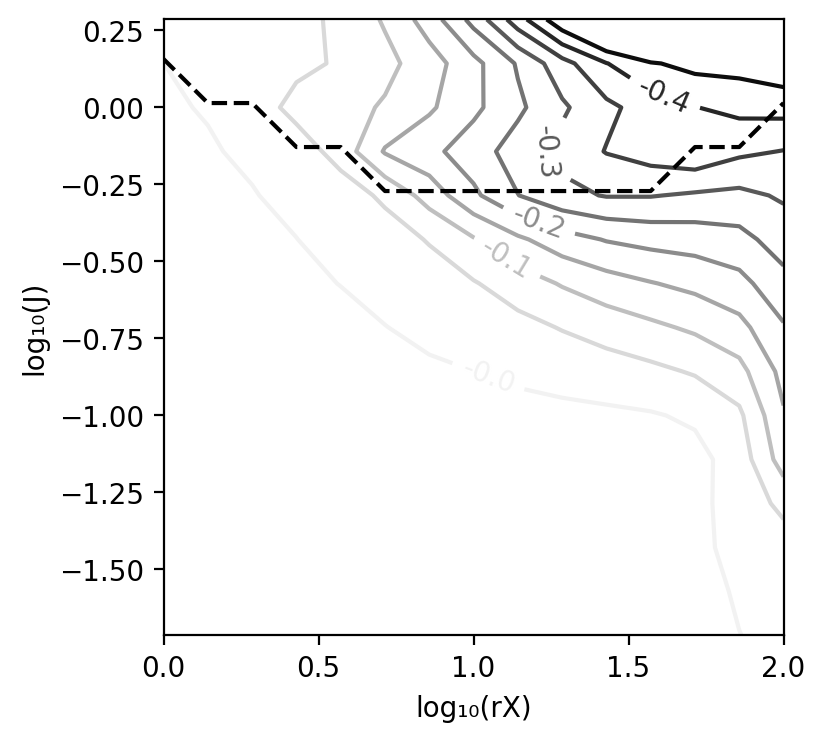

PyObject Text(48.0, 0.5, 'log₁₀(J)')

In [267]:
levels = [-0.45,-0.40,-0.35,-0.30,-0.25,-0.20,-0.15,-0.10,-0.05,-1E-3]
figure(figsize=(4,4),dpi=200)
CS = contour(log10.(rXPs),log10.(JPs),(0.8ρrEΔrEPs+0.2ρrIΔrIPs)./(0.8σΔrE2Ps+0.2σΔrI2Ps),
        levels,
        colors=["0.05","0.15","0.25","0.35","0.45","0.55","0.65","0.75","0.85","0.95"])
clabel(CS,levels,fmt="%.1f",
    manual=[(1.6,0.0),(1.2,-0.15),(1.2,-0.4),(1.1,-0.5),(1.0,-1.0)])
contour(log10.(rXPs),log10.(JPs),chPs,[0.1],colors="black",linestyles="dashed")
contour(log10.(rXPs),log10.(JPs),convPs,[0.2],colors="black",linestyles="dotted")
xlabel("log₁₀(rX)")
ylabel("log₁₀(J)")

## Finite K Analysis

In [110]:
Ks = [100,200,500,1000,2000]#,5000,10000]
JKs = [0.599, 1.0]
rXKs = [10.772173,2.320794]
chKs = zeros(Bool,length(JKs),length(Ks))
stabKs = zeros(Bool,length(JKs),length(Ks))
convKs = zeros(Bool,length(JKs),length(Ks))
μEKs = zeros(length(JKs),length(Ks))
μIKs = zeros(length(JKs),length(Ks))
ΔμEKs = zeros(length(JKs),length(Ks))
ΔμIKs = zeros(length(JKs),length(Ks))
σμE2Ks = zeros(length(JKs),length(Ks))
σμI2Ks = zeros(length(JKs),length(Ks))
σΔμE2Ks = zeros(length(JKs),length(Ks))
σΔμI2Ks = zeros(length(JKs),length(Ks))
ρμEΔμEKs = zeros(length(JKs),length(Ks))
ρμIΔμIKs = zeros(length(JKs),length(Ks))
rEKs = zeros(length(JKs),length(Ks))
rIKs = zeros(length(JKs),length(Ks))
ΔrEKs = zeros(length(JKs),length(Ks))
ΔrIKs = zeros(length(JKs),length(Ks))
σrE2Ks = zeros(length(JKs),length(Ks))
σrI2Ks = zeros(length(JKs),length(Ks))
σΔrE2Ks = zeros(length(JKs),length(Ks))
σΔrI2Ks = zeros(length(JKs),length(Ks))
ρrEΔrEKs = zeros(length(JKs),length(Ks))
ρrIΔrIKs = zeros(length(JKs),length(Ks))

2×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [111]:
for i in eachindex(JKs), j in eachindex(Ks)
    J = JKs[i]/√(Ks[j]/500)
    rX = rXKs[i]
    
    npij = NetworkParams(Ks[j],0.1,0.25,8.0,3.0,1.0,1.0,2.0,0.2,rpE,rpI)
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(npij,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rE,rI,CrE,CrI,conv = dmft(npij,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    convKs[i,j] = conv
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,npij,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 8
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,npij,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    convKs[i,j] &= conv
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-npij.p
    τEJK = npij.rpE.τs*J*npij.K
    τIJK = npij.rpI.τs*J*npij.K
    J2K = J^2*npij.K
    τE2J2K = npij.rpE.τs^2*J^2*npij.K
    τI2J2K = npij.rpE.τs^2*J^2*npij.K
    W2 = npij.W.^2
    σrX2 = (npij.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(npij.W[1,3]*rX+npij.W[1,1]*rE+npij.γ*npij.W[1,2]*rI)
    μI = τIJK*(npij.W[2,3]*rX+npij.W[2,1]*rE+npij.γ*npij.W[2,2]*rI)
    ΔμE = τEJK*(npij.W[1,1]*ΔrE+npij.γ*npij.W[1,2]*ΔrI)
    ΔμI = τIJK*(npij.W[2,1]*ΔrE+npij.γ*npij.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+npij.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+npij.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+npij.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+npij.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+npij.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+npij.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+npij.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+npij.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+npij.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+npij.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+npij.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+npij.γ*W2[2,2]*ρrIΔrI)
    
#     Mstab = zeros((2,2))
#     Mstab[1,1] = quadgk(x->exp(-0.5x^2)/sr2π*dΦ(np.rpE,μE+√(σμE2[1])*x)^2,
#         -8,8,rtol=1e-8)[1]
    
    chKs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μEKs[i,j] = μE
    μIKs[i,j] = μI
    ΔμEKs[i,j] = ΔμE
    ΔμIKs[i,j] = ΔμI
    σμE2Ks[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2Ks[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2Ks[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2Ks[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμEKs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμIKs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rEKs[i,j] = rE
    rIKs[i,j] = rI
    ΔrEKs[i,j] = ΔrE
    ΔrIKs[i,j] = ΔrI
    σrE2Ks[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2Ks[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2Ks[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2Ks[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrEKs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrIKs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(Ks)*(i-1)+j length(Ks)*length(JKs)
end

  0.274854 seconds (8.55 M allocations: 135.352 MiB, 20.25% gc time)
  0.229452 seconds (8.55 M allocations: 135.352 MiB)
  0.220876 seconds (8.55 M allocations: 135.352 MiB)
  0.314403 seconds (8.55 M allocations: 135.352 MiB, 28.32% gc time)
  0.217236 seconds (8.55 M allocations: 135.352 MiB)
  0.445460 seconds (8.55 M allocations: 135.352 MiB)
  0.326741 seconds (8.55 M allocations: 135.352 MiB, 23.14% gc time)
  0.229331 seconds (8.55 M allocations: 135.352 MiB)
  0.229481 seconds (8.55 M allocations: 135.352 MiB)
  0.311672 seconds (8.55 M allocations: 135.352 MiB, 22.11% gc time)
  0.227826 seconds (8.55 M allocations: 135.352 MiB)
  0.228106 seconds (8.55 M allocations: 135.352 MiB)
  0.293515 seconds (8.55 M allocations: 135.352 MiB, 22.99% gc time)
  0.227124 seconds (8.55 M allocations: 135.352 MiB)
  0.227264 seconds (8.55 M allocations: 135.352 MiB)
  0.287719 seconds (8.55 M allocations: 135.352 MiB, 22.75% gc time)
  0.246177 seconds (8.55 M allocations: 135.352 MiB)
  0

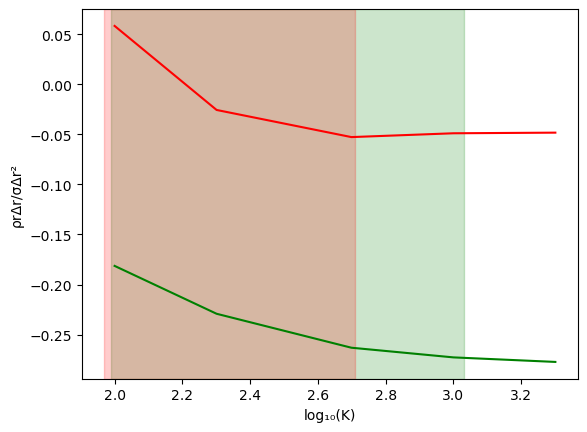

PyObject Text(24.0, 0.5, 'ρrΔr/σΔr²')

In [114]:
plot(log10.(Ks),(0.8ρrEΔrEKs[1,:]+0.2ρrIΔrIKs[1,:])./
                    (0.8σΔrE2Ks[1,:]+0.2σΔrI2Ks[1,:]),"g")
plot(log10.(Ks),(0.8ρrEΔrEKs[2,:]+0.2ρrIΔrIKs[2,:])./
                    (0.8σΔrE2Ks[2,:]+0.2σΔrI2Ks[2,:]),"r")

if any(chKs[1,:])
    axvspan(log10.(Ks[findfirst(chKs[1,:])])-0.01,
        log10.(Ks[findlast(chKs[1,:])])+0.03,color="g",alpha=0.2)
end
if any(chKs[2,:])
    axvspan(log10.(Ks[findfirst(chKs[2,:])])-0.03,
        log10.(Ks[findlast(chKs[2,:])])+0.01,color="r",alpha=0.2)
end

xlabel("log₁₀(K)")
ylabel("ρrΔr/σΔr²")

## Panel A

In [268]:
# JAs = [7.7e-2, 0.215, 0.599, 1.0]
# # rXAs = [0.5, 0.83405, 1.39128, 2.320794, 3.871318,
# #     6.457748, 10.772173, 17.969068, 29.974213, 50.0]
# rXAs = 5*10.0.^range(-1, 1, length=28)
# chAs = zeros(Bool,length(JAs),length(rXAs))
# convAs = zeros(Bool,length(JAs),length(rXAs))
# μEAs = zeros(length(JAs),length(rXAs))
# μIAs = zeros(length(JAs),length(rXAs))
# ΔμEAs = zeros(length(JAs),length(rXAs))
# ΔμIAs = zeros(length(JAs),length(rXAs))
# σμE2As = zeros(length(JAs),length(rXAs))
# σμI2As = zeros(length(JAs),length(rXAs))
# σΔμE2As = zeros(length(JAs),length(rXAs))
# σΔμI2As = zeros(length(JAs),length(rXAs))
# ρμEΔμEAs = zeros(length(JAs),length(rXAs))
# ρμIΔμIAs = zeros(length(JAs),length(rXAs))
# rEAs = zeros(length(JAs),length(rXAs))
# rIAs = zeros(length(JAs),length(rXAs))
# ΔrEAs = zeros(length(JAs),length(rXAs))
# ΔrIAs = zeros(length(JAs),length(rXAs))
# σrE2As = zeros(length(JAs),length(rXAs))
# σrI2As = zeros(length(JAs),length(rXAs))
# σΔrE2As = zeros(length(JAs),length(rXAs))
# σΔrI2As = zeros(length(JAs),length(rXAs))
# ρrEΔrEAs = zeros(length(JAs),length(rXAs))
# ρrIΔrIAs = zeros(length(JAs),length(rXAs))

h5open("fig4.h5", "r") do fid
    A = fid["A"]
    global rXAs = read(A,"r_Xs")
    global JAs = read(A,"Js")
    global chAs = Matrix{Bool}(read(A,"chs"))
    global convAs = Matrix{Bool}(read(A,"convs"))
    global μEAs = read(A,"mu_Es")
    global μIAs = read(A,"mu_Is")
    global ΔμEAs = read(A,"delta_mu_Es")
    global ΔμIAs = read(A,"delta_mu_Is")
    global σμE2As = read(A,"var_mu_Es")
    global σμI2As = read(A,"var_mu_Is")
    global σΔμE2As = read(A,"var_delta_mu_Es")
    global σΔμI2As = read(A,"var_delta_mu_Is")
    global ρμEΔμEAs = read(A,"cov_mu_E_delta_mu_Es")
    global ρμIΔμIAs = read(A,"cov_mu_I_delta_mu_Is")
    global rEAs = read(A,"r_Es")
    global rIAs = read(A,"r_Is")
    global ΔrEAs = read(A,"delta_r_Es")
    global ΔrIAs = read(A,"delta_r_Is")
    global σrE2As = read(A,"var_r_Es")
    global σrI2As = read(A,"var_r_Is")
    global σΔrE2As = read(A,"var_delta_r_Es")
    global σΔrI2As = read(A,"var_delta_r_Is")
    global ρrEΔrEAs = read(A,"cov_r_E_delta_r_Es")
    global ρrIΔrIAs = read(A,"cov_r_I_delta_r_Is")
end

4×19 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [270]:
for i in eachindex(JAs), j in eachindex(rXAs)
    J = JAs[i]
    rX = rXAs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    convAs[i,j] = conv
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 8
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    convAs[i,j] &= conv
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-np.p
    τEJK = np.rpE.τs*J*np.K
    τIJK = np.rpI.τs*J*np.K
    J2K = J^2*np.K
    τE2J2K = np.rpE.τs^2*J^2*np.K
    τI2J2K = np.rpE.τs^2*J^2*np.K
    W2 = np.W.^2
    σrX2 = (np.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    ΔμE = τEJK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
    ΔμI = τIJK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+np.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+np.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+np.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+np.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+np.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+np.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+np.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+np.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+np.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+np.γ*W2[2,2]*ρrIΔrI)
    
    chAs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μEAs[i,j] = μE
    μIAs[i,j] = μI
    ΔμEAs[i,j] = ΔμE
    ΔμIAs[i,j] = ΔμI
    σμE2As[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2As[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2As[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2As[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμEAs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμIAs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rEAs[i,j] = rE
    rIAs[i,j] = rI
    ΔrEAs[i,j] = ΔrE
    ΔrIAs[i,j] = ΔrI
    σrE2As[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2As[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2As[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2As[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrEAs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrIAs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(rXAs)*(i-1)+j length(JAs)*length(rXAs)
end

 18.528796 seconds (8.55 M allocations: 135.353 MiB, 89.72% gc time)
 49.681805 seconds (1.61 G allocations: 26.880 GiB, 9.61% gc time)
1/76 completed
  0.285446 seconds (8.55 M allocations: 135.352 MiB, 9.79% gc time)
 43.841688 seconds (1.48 G allocations: 24.603 GiB, 9.53% gc time)
2/76 completed
  0.359068 seconds (8.55 M allocations: 135.352 MiB)
 41.928305 seconds (1.47 G allocations: 24.478 GiB, 10.10% gc time)
3/76 completed
  0.263976 seconds (8.55 M allocations: 135.352 MiB)
 41.377257 seconds (1.47 G allocations: 24.461 GiB, 10.65% gc time)
4/76 completed
  0.235814 seconds (8.55 M allocations: 135.352 MiB)
 45.446445 seconds (1.61 G allocations: 26.859 GiB, 10.32% gc time)
5/76 completed
  0.316264 seconds (8.55 M allocations: 135.352 MiB, 26.99% gc time)
 45.494248 seconds (1.61 G allocations: 26.875 GiB, 10.31% gc time)
6/76 completed
  0.269549 seconds (8.55 M allocations: 135.352 MiB)
 43.007163 seconds (1.48 G allocations: 24.661 GiB, 10.27% gc time)
7/76 completed
  0

 53.998438 seconds (1.76 G allocations: 29.356 GiB, 9.64% gc time)
63/76 completed
  0.371499 seconds (8.55 M allocations: 135.352 MiB, 23.84% gc time)
  0.462228 seconds (8.55 M allocations: 135.352 MiB)
 53.497312 seconds (1.76 G allocations: 29.352 GiB, 9.94% gc time)
 54.371760 seconds (1.76 G allocations: 29.356 GiB, 9.66% gc time)
 49.688299 seconds (1.76 G allocations: 29.356 GiB, 9.88% gc time)
64/76 completed
  0.386204 seconds (8.55 M allocations: 135.352 MiB, 21.57% gc time)
  0.242696 seconds (8.55 M allocations: 135.352 MiB)
 51.461365 seconds (1.75 G allocations: 29.249 GiB, 10.17% gc time)
 53.946111 seconds (1.76 G allocations: 29.356 GiB, 9.62% gc time)
65/76 completed
  0.315379 seconds (8.55 M allocations: 135.352 MiB)
  0.248317 seconds (8.55 M allocations: 135.352 MiB)
 53.155556 seconds (1.79 G allocations: 29.770 GiB, 10.08% gc time)
 60.088726 seconds (1.78 G allocations: 29.723 GiB, 9.37% gc time)
66/76 completed
  0.352025 seconds (8.55 M allocations: 135.352 

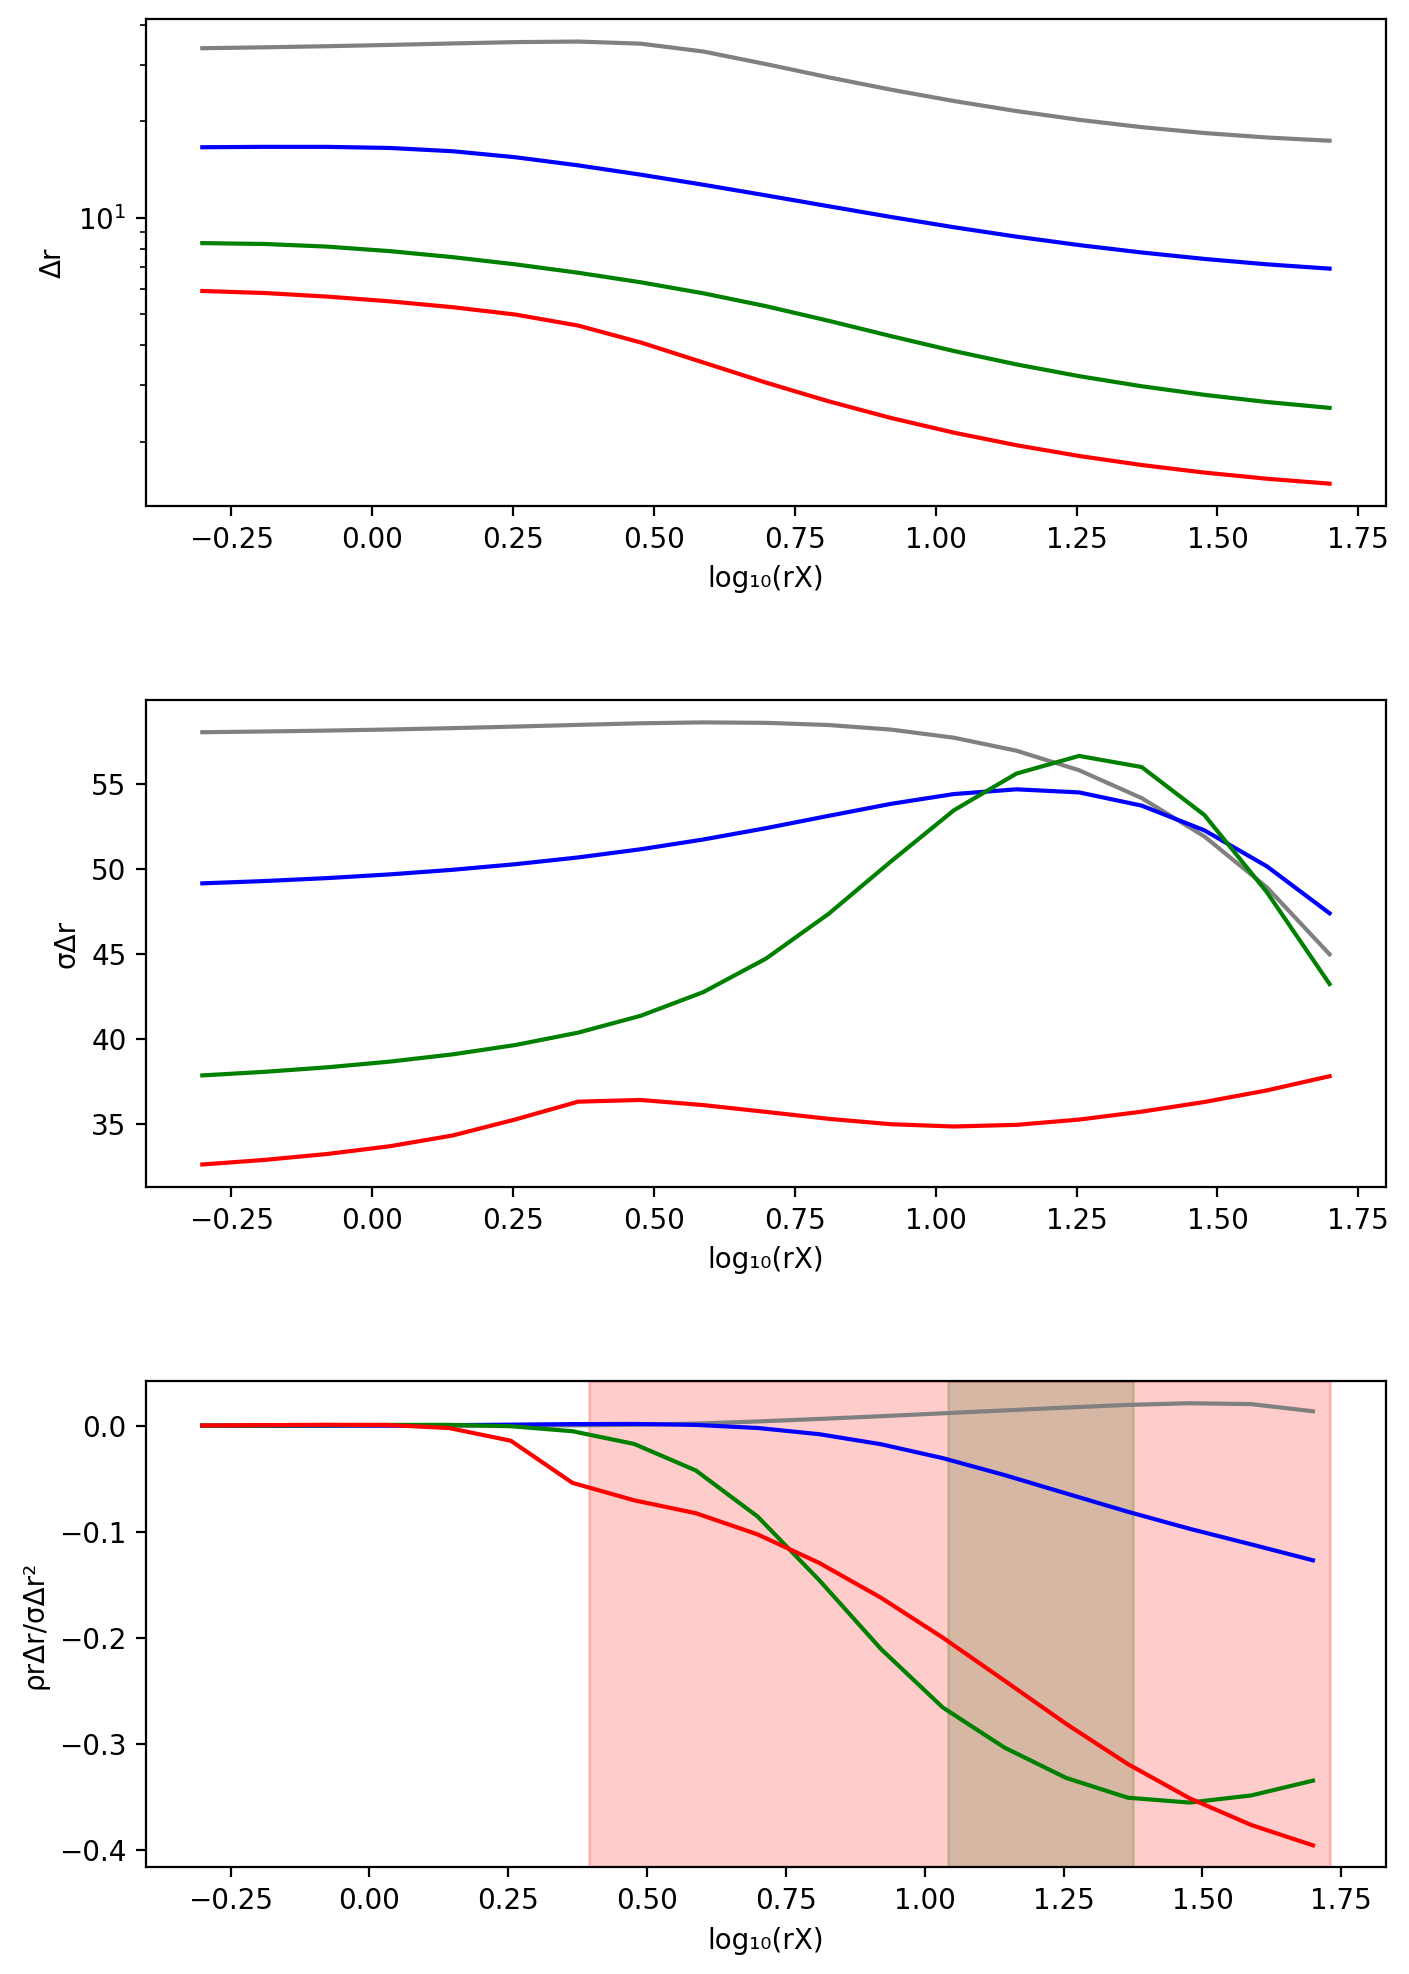

PyObject Text(48.000000000000014, 0.5, 'ρrΔr/σΔr²')

In [271]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log10.(rXAs),0.8ΔrEAs[1,:]+0.2ΔrIAs[1,:],"gray")
plot(log10.(rXAs),0.8ΔrEAs[2,:]+0.2ΔrIAs[2,:],"b")
plot(log10.(rXAs),0.8ΔrEAs[3,:]+0.2ΔrIAs[3,:],"g")
plot(log10.(rXAs),0.8ΔrEAs[4,:]+0.2ΔrIAs[4,:],"r")
xlabel("log₁₀(rX)")
ylabel("Δr")
yscale("log")

subplot(3,1,2)
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:],0)),"r")
xlabel("log₁₀(rX)")
ylabel("σΔr")

subplot(3,1,3)
plot(log10.(rXAs),(0.8ρrEΔrEAs[1,:]+0.2ρrIΔrIAs[1,:])./
                    (0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:]),"gray")
plot(log10.(rXAs),(0.8ρrEΔrEAs[2,:]+0.2ρrIΔrIAs[2,:])./
                    (0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:]),"b")
plot(log10.(rXAs),(0.8ρrEΔrEAs[3,:]+0.2ρrIΔrIAs[3,:])./
                    (0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:]),"g")
plot(log10.(rXAs),(0.8ρrEΔrEAs[4,:]+0.2ρrIΔrIAs[4,:])./
                    (0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:]),"r")
if any(chAs[1,:])
    axvline(log10.(rXAs[findfirst(chAs[1,:])])-0.03,color="gray",ls="--")
end
if any(chAs[2,:])
    axvline(log10.(rXAs[findfirst(chAs[2,:])])-0.01,color="b",ls="--")
end
if any(chAs[3,:])
    axvspan(log10.(rXAs[findfirst(chAs[3,:])])+0.01,
        log10.(rXAs[findlast(chAs[3,:])])+0.01,color="g",alpha=0.2)
end
if any(chAs[4,:])
    axvspan(log10.(rXAs[findfirst(chAs[4,:])])+0.03,
        log10.(rXAs[findlast(chAs[4,:])])+0.03,color="r",alpha=0.2)
end
xlabel("log₁₀(rX)")
ylabel("ρrΔr/σΔr²")

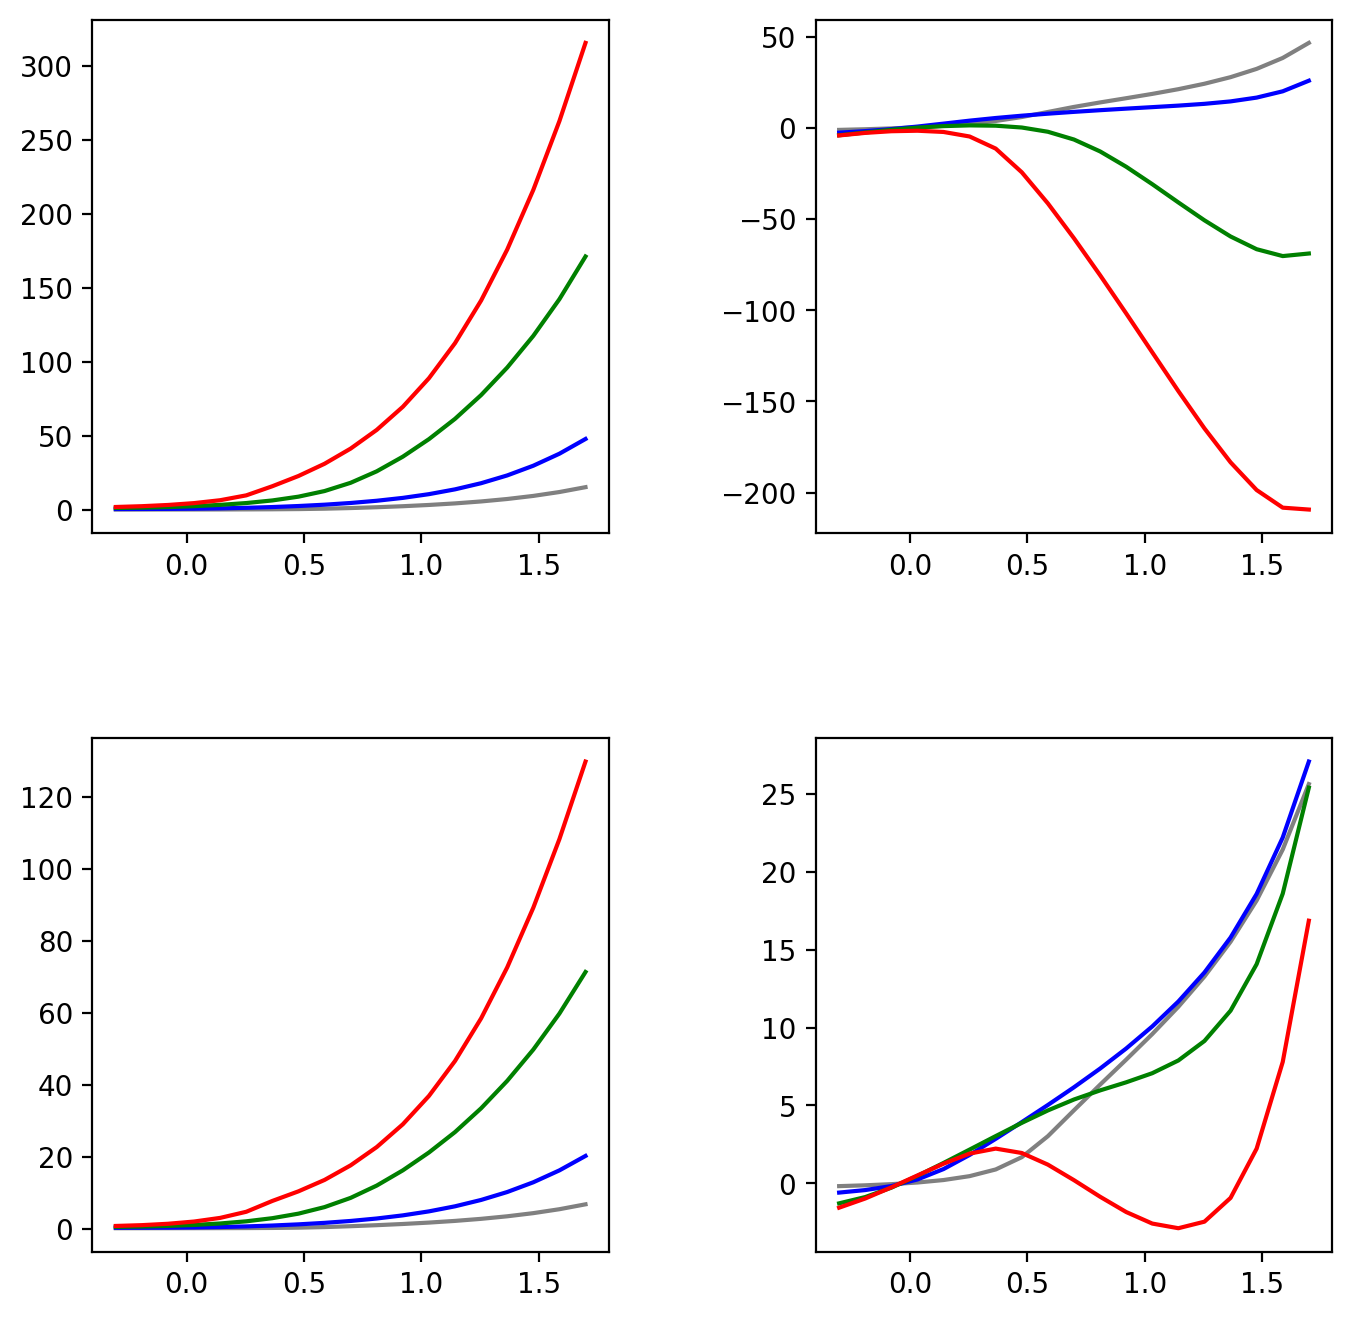

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd25a0584c0>

In [286]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,2,1)
plot(log10.(rXAs),.√(max.(σμE2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμE2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμE2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμE2As[4,:],0)),"r")

subplot(2,2,3)
plot(log10.(rXAs),.√(max.(σμI2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμI2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμI2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμI2As[4,:],0)),"r")

subplot(2,2,2)
plot(log10.(rXAs),μEAs[1,:],"gray")
plot(log10.(rXAs),μEAs[2,:],"b")
plot(log10.(rXAs),μEAs[3,:],"g")
plot(log10.(rXAs),μEAs[4,:],"r")

subplot(2,2,4)
plot(log10.(rXAs),μIAs[1,:],"gray")
plot(log10.(rXAs),μIAs[2,:],"b")
plot(log10.(rXAs),μIAs[3,:],"g")
plot(log10.(rXAs),μIAs[4,:],"r")

In [163]:
ΔμEisnAs = zeros(length(JAs),length(rXAs))
ΔμIisnAs = zeros(length(JAs),length(rXAs))
ΔrEisnAs = zeros(length(JAs),length(rXAs))
ΔrIisnAs = zeros(length(JAs),length(rXAs))

4×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [164]:
for i in eachindex(JAs), j in eachindex(rXAs)
    J = JAs[i]
    rX = rXAs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    convAs[i,j] = conv
    count = 1
    @time rEisn,rIisn,CrEisn,CrIisn,conv = isndmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rEisn,rIisn,CrEisn,CrIisn,conv = isndmft(np,J,rX,TWrm,TSave,dt,rEinit=rEisn,
            rIinit=rIisn,CrEinit=CrEisn,CrIinit=CrIisn)
        count += 1
    end
    convAs[i,j] &= conv
    
    ΔrE = rEisn-rE
    ΔrI = rIisn-rI
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-np.p
    τEJK = 0.02*J*np.K
    τIJK = 0.01*J*np.K
    J2K = J^2*np.K
    τE2J2K = 0.02^2*J^2*np.K
    τI2J2K = 0.01^2*J^2*np.K
    W2 = np.W.^2
    σrX2 = (np.sX*rX)^2

    ΔμE = τEJK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
    ΔμI = τIJK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
    
    ΔμEisnAs[i,j] = ΔμE
    ΔμIisnAs[i,j] = ΔμI
    ΔrEisnAs[i,j] = ΔrE
    ΔrIisnAs[i,j] = ΔrI
    
    @printf "%d/%d completed\n" length(rXAs)*(i-1)+j length(JAs)*length(rXAs)
end

  0.955553 seconds (8.63 M allocations: 139.475 MiB, 23.18% gc time, 16.05% compilation time)
  1.856772 seconds (9.05 M allocations: 179.515 MiB, 85.55% compilation time)
1/40 completed
  0.285365 seconds (8.55 M allocations: 135.352 MiB)
  0.539528 seconds (7.92 M allocations: 125.717 MiB)
2/40 completed
  0.670328 seconds (8.55 M allocations: 135.352 MiB, 18.00% gc time)
  0.220607 seconds (7.92 M allocations: 125.717 MiB)
3/40 completed
  0.234095 seconds (8.55 M allocations: 135.352 MiB)
  0.217605 seconds (7.92 M allocations: 125.717 MiB)
4/40 completed
  0.513571 seconds (8.55 M allocations: 135.352 MiB, 18.88% gc time)
  0.212750 seconds (7.92 M allocations: 125.717 MiB)
5/40 completed
  0.227400 seconds (8.55 M allocations: 135.352 MiB)
  0.201046 seconds (7.92 M allocations: 125.717 MiB)
6/40 completed
  0.250043 seconds (8.55 M allocations: 135.352 MiB)
  0.298104 seconds (7.92 M allocations: 125.717 MiB, 29.66% gc time)
7/40 completed
  0.324414 seconds (8.55 M allocations:

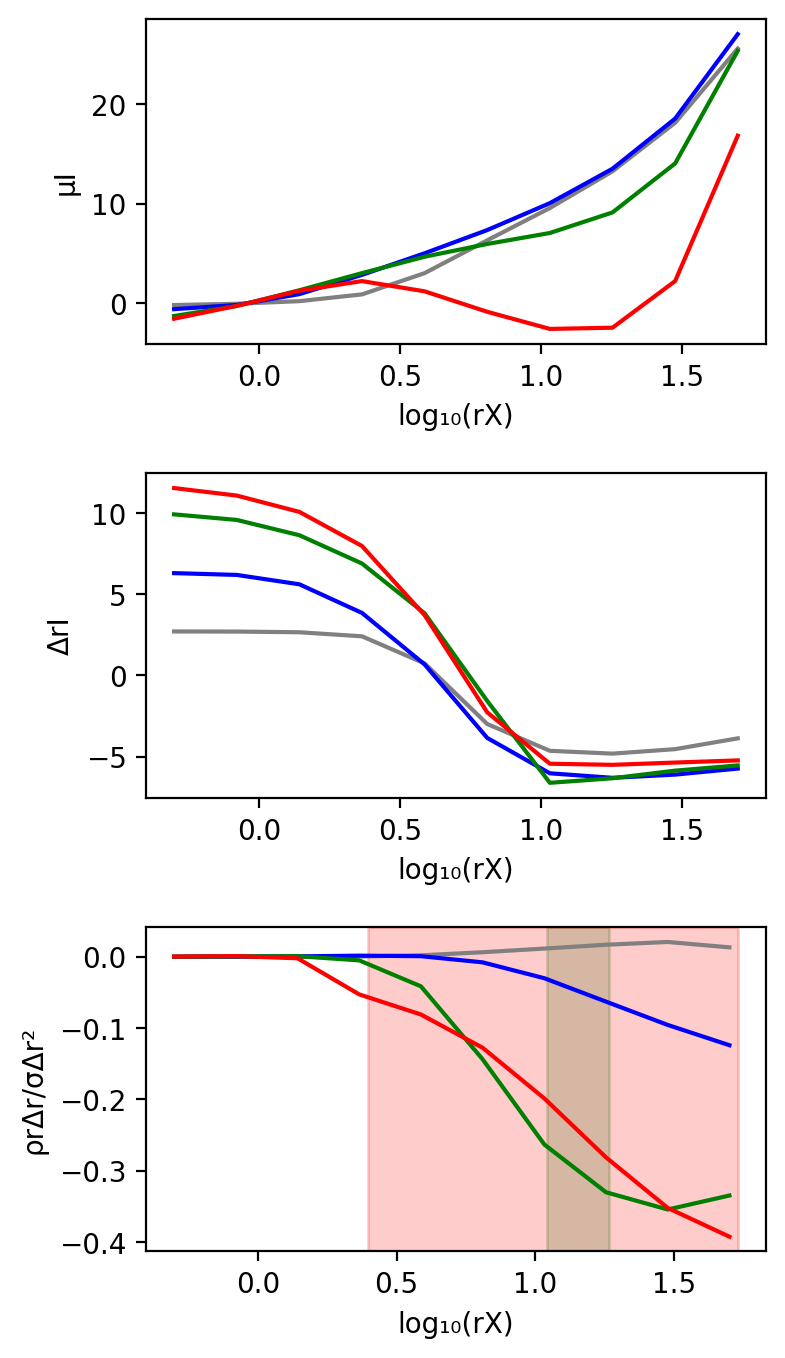

PyObject Text(47.999999999999986, 0.5, 'ρrΔr/σΔr²')

In [165]:
figure(figsize=(4,8),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log10.(rXAs),μIAs[1,:],"gray")
plot(log10.(rXAs),μIAs[2,:],"b")
plot(log10.(rXAs),μIAs[3,:],"g")
plot(log10.(rXAs),μIAs[4,:],"r")
xlabel("log₁₀(rX)")
ylabel("μI")

subplot(3,1,2)
plot(log10.(rXAs),ΔrIisnAs[1,:],"gray")
plot(log10.(rXAs),ΔrIisnAs[2,:],"b")
plot(log10.(rXAs),ΔrIisnAs[3,:],"g")
plot(log10.(rXAs),ΔrIisnAs[4,:],"r")
xlabel("log₁₀(rX)")
ylabel("ΔrI")

subplot(3,1,3)
plot(log10.(rXAs),(0.8ρrEΔrEAs[1,:]+0.2ρrIΔrIAs[1,:])./
                    (0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:]),"gray")
plot(log10.(rXAs),(0.8ρrEΔrEAs[2,:]+0.2ρrIΔrIAs[2,:])./
                    (0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:]),"b")
plot(log10.(rXAs),(0.8ρrEΔrEAs[3,:]+0.2ρrIΔrIAs[3,:])./
                    (0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:]),"g")
plot(log10.(rXAs),(0.8ρrEΔrEAs[4,:]+0.2ρrIΔrIAs[4,:])./
                    (0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:]),"r")
if any(chAs[1,:])
    axvline(log10.(rXAs[findfirst(chAs[1,:])])-0.03,color="gray",ls="--")
end
if any(chAs[2,:])
    axvline(log10.(rXAs[findfirst(chAs[2,:])])-0.01,color="b",ls="--")
end
if any(chAs[3,:])
    axvspan(log10.(rXAs[findfirst(chAs[3,:])])+0.01,
        log10.(rXAs[findlast(chAs[3,:])])+0.01,color="g",alpha=0.2)
end
if any(chAs[4,:])
    axvspan(log10.(rXAs[findfirst(chAs[4,:])])+0.03,
        log10.(rXAs[findlast(chAs[4,:])])+0.03,color="r",alpha=0.2)
end
xlabel("log₁₀(rX)")
ylabel("ρrΔr/σΔr²")

## Panel B

In [285]:
# # JBs = [0.01, 0.017, 0.028, 0.046, 0.077, 0.129, 0.215, 0.359, 0.599, 1.0]
# JBs = 1*10.0.^range(-2, 0, length=28)
# rXBs = [1.39128, 6.457748, 17.969068, 29.974213]
# chBs = zeros(Bool,length(JBs),length(rXBs))
# convBs = zeros(Bool,length(JBs),length(rXBs))
# μEBs = zeros(length(JBs),length(rXBs))
# μIBs = zeros(length(JBs),length(rXBs))
# ΔμEBs = zeros(length(JBs),length(rXBs))
# ΔμIBs = zeros(length(JBs),length(rXBs))
# σμE2Bs = zeros(length(JBs),length(rXBs))
# σμI2Bs = zeros(length(JBs),length(rXBs))
# σΔμE2Bs = zeros(length(JBs),length(rXBs))
# σΔμI2Bs = zeros(length(JBs),length(rXBs))
# ρμEΔμEBs = zeros(length(JBs),length(rXBs))
# ρμIΔμIBs = zeros(length(JBs),length(rXBs))
# rEBs = zeros(length(JBs),length(rXBs))
# rIBs = zeros(length(JBs),length(rXBs))
# ΔrEBs = zeros(length(JBs),length(rXBs))
# ΔrIBs = zeros(length(JBs),length(rXBs))
# σrE2Bs = zeros(length(JBs),length(rXBs))
# σrI2Bs = zeros(length(JBs),length(rXBs))
# σΔrE2Bs = zeros(length(JBs),length(rXBs))
# σΔrI2Bs = zeros(length(JBs),length(rXBs))
# ρrEΔrEBs = zeros(length(JBs),length(rXBs))
# ρrIΔrIBs = zeros(length(JBs),length(rXBs))

h5open("fig4.h5", "r") do fid
    B = fid["B"]
    global JBs = read(B,"Js")
    global rXBs = read(B,"r_Xs")
    global chBs = Matrix{Bool}(read(B,"chs")')
    global convBs = Matrix{Bool}(read(B,"convs")')
    global μEBs = Matrix(read(B,"mu_Es")')
    global μIBs = Matrix(read(B,"mu_Is")')
    global ΔμEBs = Matrix(read(B,"delta_mu_Es")')
    global ΔμIBs = Matrix(read(B,"delta_mu_Is")')
    global σμE2Bs = Matrix(read(B,"var_mu_Es")')
    global σμI2Bs = Matrix(read(B,"var_mu_Is")')
    global σΔμE2Bs = Matrix(read(B,"var_delta_mu_Es")')
    global σΔμI2Bs = Matrix(read(B,"var_delta_mu_Is")')
    global ρμEΔμEBs = Matrix(read(B,"cov_mu_E_delta_mu_Es")')
    global ρμIΔμIBs = Matrix(read(B,"cov_mu_I_delta_mu_Is")')
    global rEBs = Matrix(read(B,"r_Es")')
    global rIBs = Matrix(read(B,"r_Is")')
    global ΔrEBs = Matrix(read(B,"delta_r_Es")')
    global ΔrIBs = Matrix(read(B,"delta_r_Is")')
    global σrE2Bs = Matrix(read(B,"var_r_Es")')
    global σrI2Bs = Matrix(read(B,"var_r_Is")')
    global σΔrE2Bs = Matrix(read(B,"var_delta_r_Es")')
    global σΔrI2Bs = Matrix(read(B,"var_delta_r_Is")')
    global ρrEΔrEBs = Matrix(read(B,"cov_r_E_delta_r_Es")')
    global ρrIΔrIBs = Matrix(read(B,"cov_r_I_delta_r_Is")')
end

19×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [287]:
for i in eachindex(JBs), j in eachindex(rXBs)
    J = JBs[i]
    rX = rXBs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    convBs[i,j] = conv
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 8
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    convBs[i,j] &= conv
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-np.p
    τEJK = np.rpE.τs*J*np.K
    τIJK = np.rpI.τs*J*np.K
    J2K = J^2*np.K
    τE2J2K = np.rpE.τs^2*J^2*np.K
    τI2J2K = np.rpE.τs^2*J^2*np.K
    W2 = np.W.^2
    σrX2 = (np.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    ΔμE = τEJK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
    ΔμI = τIJK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+np.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+np.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+np.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+np.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+np.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+np.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+np.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+np.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+np.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+np.γ*W2[2,2]*ρrIΔrI)
    
    chBs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μEBs[i,j] = μE
    μIBs[i,j] = μI
    ΔμEBs[i,j] = ΔμE
    ΔμIBs[i,j] = ΔμI
    σμE2Bs[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2Bs[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2Bs[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2Bs[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμEBs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμIBs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rEBs[i,j] = rE
    rIBs[i,j] = rI
    ΔrEBs[i,j] = ΔrE
    ΔrIBs[i,j] = ΔrI
    σrE2Bs[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2Bs[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2Bs[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2Bs[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrEBs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrIBs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(rXBs)*(i-1)+j length(JBs)*length(rXBs)
end

  0.678358 seconds (8.55 M allocations: 135.352 MiB)
 46.965649 seconds (1.61 G allocations: 26.880 GiB, 10.92% gc time)
1/76 completed
  0.444590 seconds (8.55 M allocations: 135.352 MiB, 6.52% gc time)
 46.417150 seconds (1.61 G allocations: 26.880 GiB, 10.02% gc time)
2/76 completed
  0.239683 seconds (8.55 M allocations: 135.352 MiB)
 46.679972 seconds (1.61 G allocations: 26.880 GiB, 10.07% gc time)
3/76 completed
  0.226847 seconds (8.55 M allocations: 135.352 MiB)
 48.309194 seconds (1.61 G allocations: 26.880 GiB, 10.83% gc time)
4/76 completed
  0.307728 seconds (8.55 M allocations: 135.352 MiB)
 50.063838 seconds (1.61 G allocations: 26.880 GiB, 10.04% gc time)
5/76 completed
  0.230440 seconds (8.55 M allocations: 135.352 MiB)
 50.719479 seconds (1.61 G allocations: 26.880 GiB, 10.46% gc time)
6/76 completed
  0.259046 seconds (8.55 M allocations: 135.352 MiB)
 49.734745 seconds (1.61 G allocations: 26.880 GiB, 10.34% gc time)
7/76 completed
  0.352528 seconds (8.55 M alloca

 59.544986 seconds (1.92 G allocations: 31.905 GiB, 10.11% gc time)
 61.296729 seconds (1.93 G allocations: 32.042 GiB, 9.58% gc time)
70/76 completed
  0.274270 seconds (8.55 M allocations: 135.352 MiB)
  0.236932 seconds (8.55 M allocations: 135.352 MiB)
 79.077708 seconds (2.47 G allocations: 41.331 GiB, 9.98% gc time)
 77.554210 seconds (2.49 G allocations: 41.602 GiB, 9.94% gc time)
71/76 completed
  0.362792 seconds (8.55 M allocations: 135.352 MiB)
  0.259535 seconds (8.55 M allocations: 135.352 MiB)
 75.828935 seconds (2.52 G allocations: 42.206 GiB, 10.24% gc time)
 82.653534 seconds (2.58 G allocations: 43.202 GiB, 9.75% gc time)
72/76 completed
  0.257491 seconds (8.55 M allocations: 135.352 MiB)
 57.932194 seconds (1.90 G allocations: 31.630 GiB, 9.91% gc time)
 63.946517 seconds (1.90 G allocations: 31.689 GiB, 9.84% gc time)
73/76 completed
  0.325607 seconds (8.55 M allocations: 135.352 MiB)
 53.535219 seconds (1.78 G allocations: 29.549 GiB, 10.20% gc time)
74/76 comple

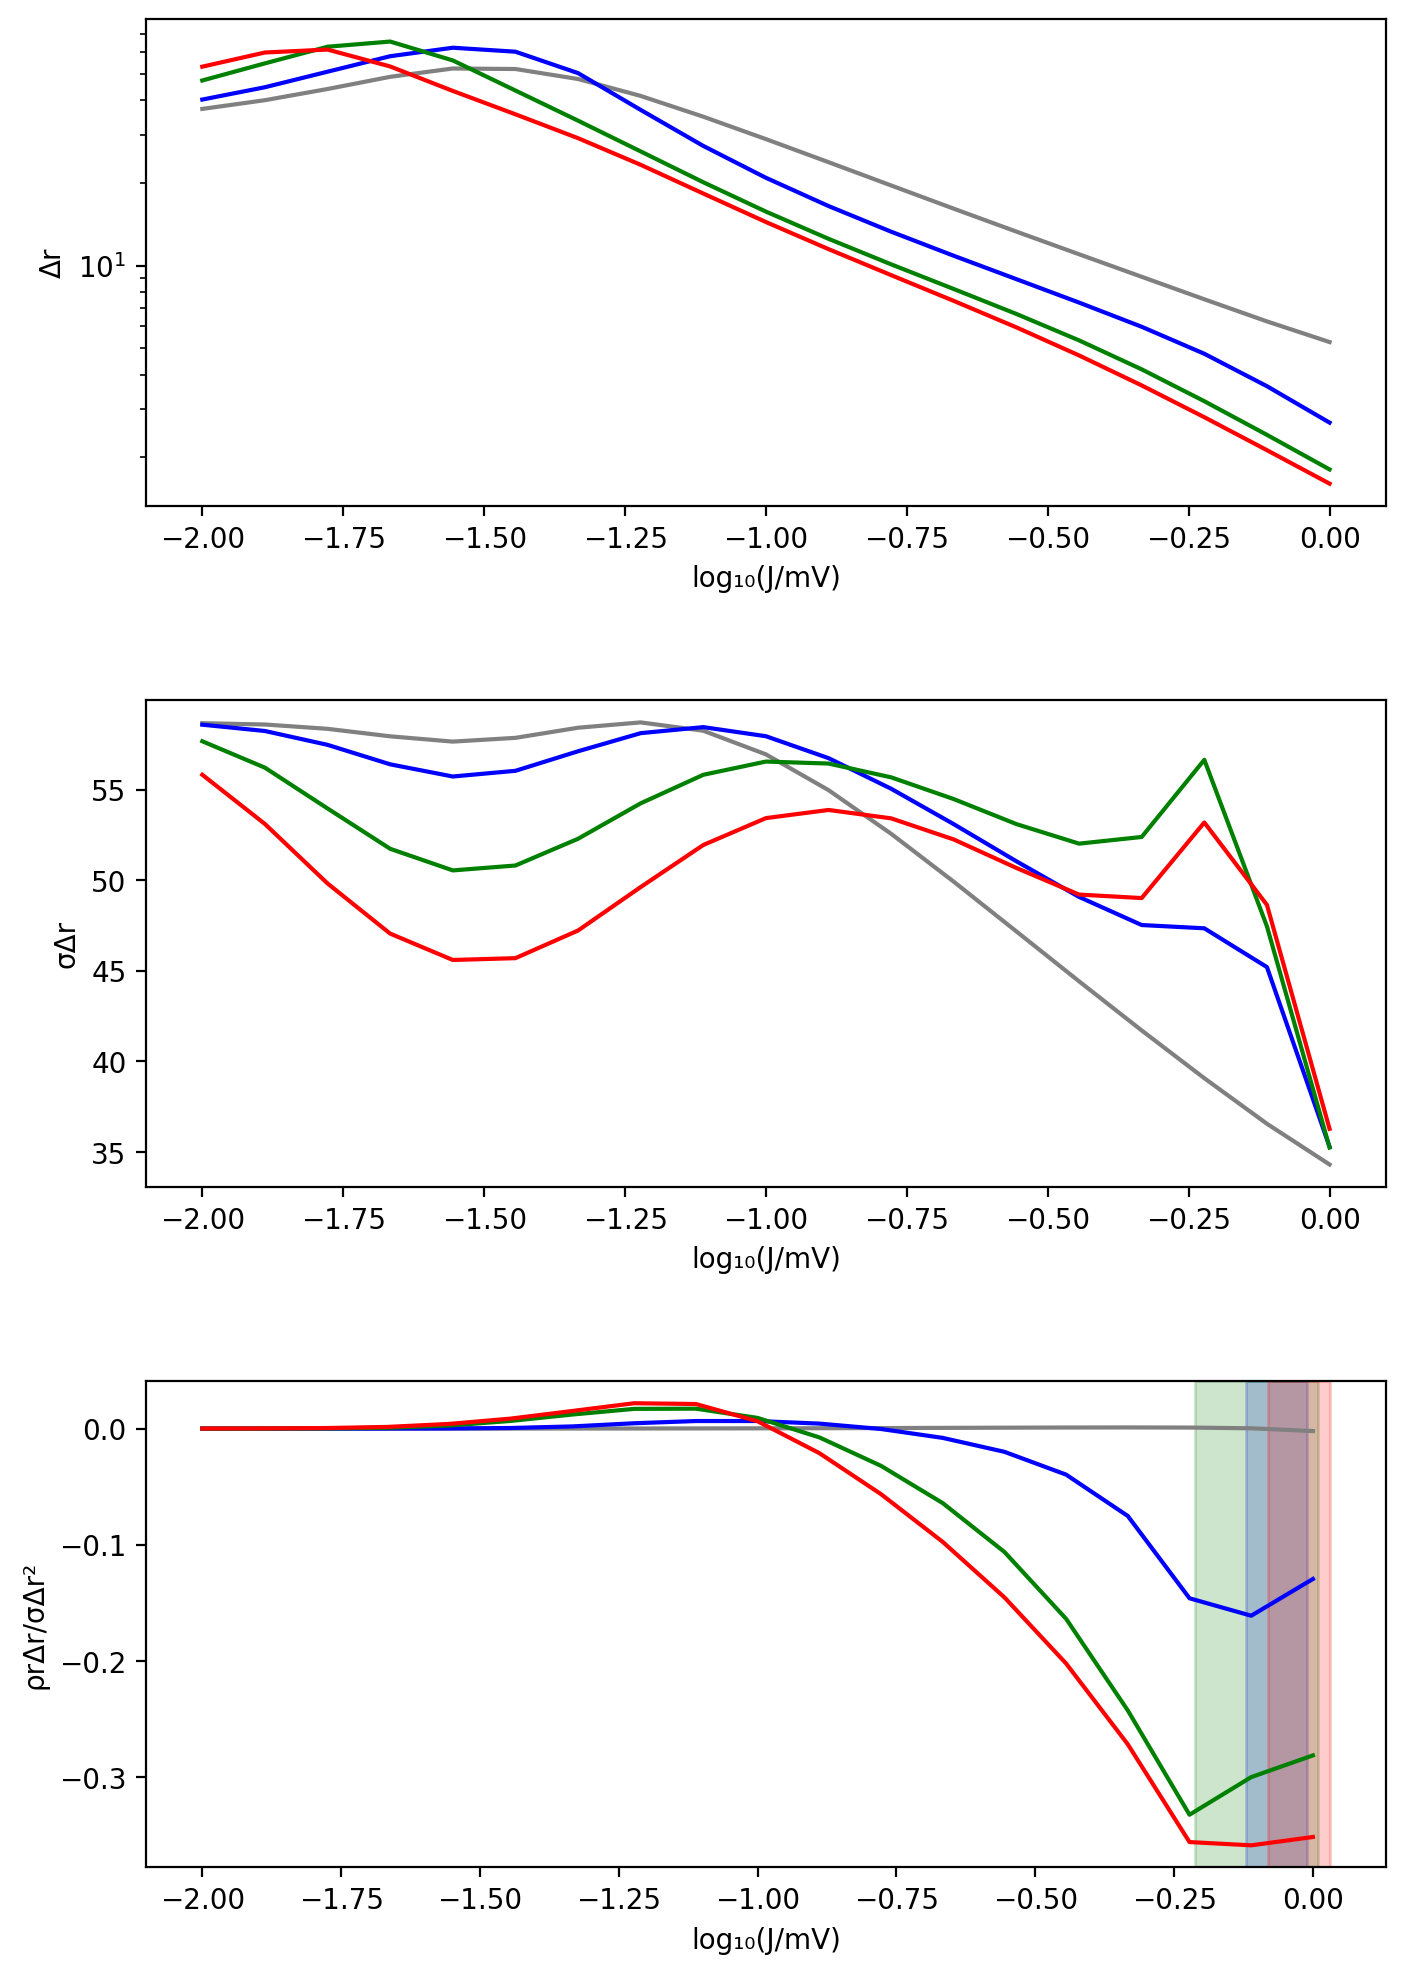

PyObject Text(48.000000000000014, 0.5, 'ρrΔr/σΔr²')

In [289]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log10.(JBs),0.8ΔrEBs[:,1]+0.2ΔrIBs[:,1],"gray")
plot(log10.(JBs),0.8ΔrEBs[:,2]+0.2ΔrIBs[:,2],"b")
plot(log10.(JBs),0.8ΔrEBs[:,3]+0.2ΔrIBs[:,3],"g")
plot(log10.(JBs),0.8ΔrEBs[:,4]+0.2ΔrIBs[:,4],"r")
xlabel("log₁₀(J/mV)")
ylabel("Δr")
yscale("log")

subplot(3,1,2)
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4],0)),"r")
xlabel("log₁₀(J/mV)")
ylabel("σΔr")

subplot(3,1,3)
plot(log10.(JBs),(0.8ρrEΔrEBs[:,1]+0.2ρrIΔrIBs[:,1])./
                    (0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1]),"gray")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,2]+0.2ρrIΔrIBs[:,2])./
                    (0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2]),"b")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,3]+0.2ρrIΔrIBs[:,3])./
                    (0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3]),"g")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,4]+0.2ρrIΔrIBs[:,4])./
                    (0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4]),"r")
if any(chBs[:,1])
    axvline(log10.(JBs[findfirst(chBs[:,1])])-0.03,color="gray",ls="--")
end
if any(chBs[:,2])
    axvspan(log10.(JBs[findfirst(chBs[:,2])])-0.01,
        log10.(JBs[findlast(chBs[:,2])])-0.01,color="b",alpha=0.2)
end
if any(chBs[:,3])
    axvspan(log10.(JBs[findfirst(chBs[:,3])])+0.01,
        log10.(JBs[findlast(chBs[:,3])])+0.01,color="g",alpha=0.2)
end
if any(chBs[:,4])
    axvspan(log10.(JBs[findfirst(chBs[:,4])])+0.03,
        log10.(JBs[findlast(chBs[:,4])])+0.03,color="r",alpha=0.2)
end
xlabel("log₁₀(J/mV)")
ylabel("ρrΔr/σΔr²")

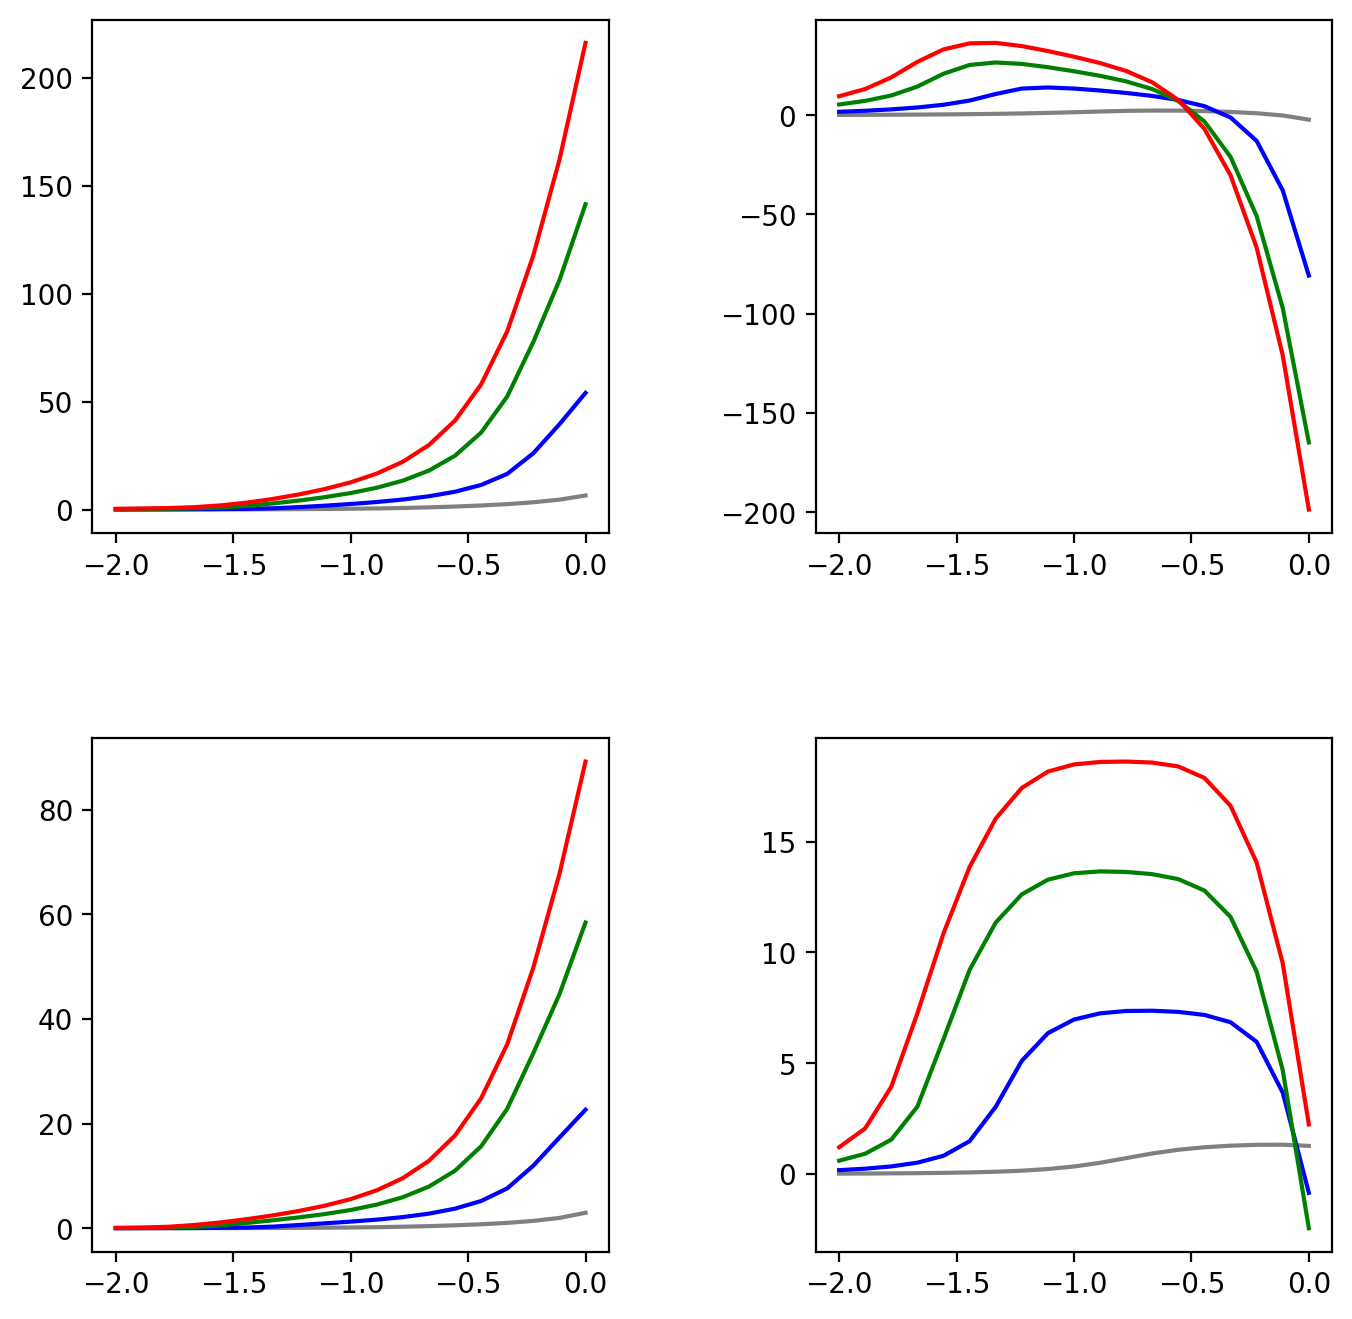

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd25ac28e50>

In [290]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,2,1)
plot(log10.(JBs),.√(max.(σμE2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμE2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμE2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμE2Bs[:,4],0)),"r")

subplot(2,2,3)
plot(log10.(JBs),.√(max.(σμI2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμI2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμI2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμI2Bs[:,4],0)),"r")

subplot(2,2,2)
plot(log10.(JBs),μEBs[:,1],"gray")
plot(log10.(JBs),μEBs[:,2],"b")
plot(log10.(JBs),μEBs[:,3],"g")
plot(log10.(JBs),μEBs[:,4],"r")

subplot(2,2,4)
plot(log10.(JBs),μIBs[:,1],"gray")
plot(log10.(JBs),μIBs[:,2],"b")
plot(log10.(JBs),μIBs[:,3],"g")
plot(log10.(JBs),μIBs[:,4],"r")

# Panel C

In [136]:
# function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
op = LogNormOptoParams(1.0,20.0)

LogNormOptoParams(1.0, 20.0, 2.649158683274018, 0.8325546111576977)

In [137]:
@time ΦLitp(op,[rpE])

 20.728167 seconds (611.61 M allocations: 9.388 GiB, 9.23% gc time)


In [138]:
@time MLitp(op,[rpE])

491.630454 seconds (16.34 G allocations: 250.455 GiB, 8.29% gc time)


In [139]:
@time CLitp(op,[rpE])

2620.093719 seconds (78.69 G allocations: 1.176 TiB, 7.65% gc time)


In [275]:
# gECs = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
# gICs = [3.0, 4.0, 5.0, 6.0]
# chCs = zeros(Bool,length(gECs),length(gICs))
# convCs = zeros(Bool,length(gECs),length(gICs))
# μECs = zeros(length(gECs),length(gICs))
# μICs = zeros(length(gECs),length(gICs))
# ΔμECs = zeros(length(gECs),length(gICs))
# ΔμICs = zeros(length(gECs),length(gICs))
# σμE2Cs = zeros(length(gECs),length(gICs))
# σμI2Cs = zeros(length(gECs),length(gICs))
# σΔμE2Cs = zeros(length(gECs),length(gICs))
# σΔμI2Cs = zeros(length(gECs),length(gICs))
# ρμEΔμECs = zeros(length(gECs),length(gICs))
# ρμIΔμICs = zeros(length(gECs),length(gICs))
# rECs = zeros(length(gECs),length(gICs))
# rICs = zeros(length(gECs),length(gICs))
# ΔrECs = zeros(length(gECs),length(gICs))
# ΔrICs = zeros(length(gECs),length(gICs))
# σrE2Cs = zeros(length(gECs),length(gICs))
# σrI2Cs = zeros(length(gECs),length(gICs))
# σΔrE2Cs = zeros(length(gECs),length(gICs))
# σΔrI2Cs = zeros(length(gECs),length(gICs))
# ρrEΔrECs = zeros(length(gECs),length(gICs))
# ρrIΔrICs = zeros(length(gECs),length(gICs))

h5open("fig4.h5", "r") do fid
    C = fid["C"]
    global gECs = read(C,"gEs")
    global gICs = read(C,"gIs")
    global chCs = Matrix{Bool}(read(C,"chs")')
    global convCs = Matrix{Bool}(read(C,"convs")')
    global μECs = Matrix(read(C,"mu_Es")')
    global μICs = Matrix(read(C,"mu_Is")')
    global ΔμECs = Matrix(read(C,"delta_mu_Es")')
    global ΔμICs = Matrix(read(C,"delta_mu_Is")')
    global σμE2Cs = Matrix(read(C,"var_mu_Es")')
    global σμI2Cs = Matrix(read(C,"var_mu_Is")')
    global σΔμE2Cs = Matrix(read(C,"var_delta_mu_Es")')
    global σΔμI2Cs = Matrix(read(C,"var_delta_mu_Is")')
    global ρμEΔμECs = Matrix(read(C,"cov_mu_E_delta_mu_Es")')
    global ρμIΔμICs = Matrix(read(C,"cov_mu_I_delta_mu_Is")')
    global rECs = Matrix(read(C,"r_Es")')
    global rICs = Matrix(read(C,"r_Is")')
    global ΔrECs = Matrix(read(C,"delta_r_Es")')
    global ΔrICs = Matrix(read(C,"delta_r_Is")')
    global σrE2Cs = Matrix(read(C,"var_r_Es")')
    global σrI2Cs = Matrix(read(C,"var_r_Is")')
    global σΔrE2Cs = Matrix(read(C,"var_delta_r_Es")')
    global σΔrI2Cs = Matrix(read(C,"var_delta_r_Is")')
    global ρrEΔrECs = Matrix(read(C,"cov_r_E_delta_r_Es")')
    global ρrIΔrICs = Matrix(read(C,"cov_r_I_delta_r_Is")')
end

7×4 Matrix{Float64}:
  498.987   -1620.4     -1452.26      -4485.81
  103.68      351.501     460.649       -65.8738
  -21.6266     31.3177    469.374      1332.92
  -86.3518    -56.6778    168.043       484.34
 -127.423     -85.3739     66.0808      221.226
 -148.231     -93.1292     21.648       120.956
 -145.184     -92.2919     -0.366496     71.0666

In [140]:
for i in eachindex(gECs), j in eachindex(gICs)
    J = 0.599
    rX = 10.0
    npij = NetworkParams(500,0.1,0.25,gECs[i],gICs[j],1.0,1.0,2.0,0.2,rpE,rpI)
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.0025
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(npij,J,rX,TWrm,TSave,dt)
    while !conv && count < 20
        @time rE,rI,CrE,CrI,conv = dmft(npij,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    convCs[i,j] = conv
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,npij,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 8
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,npij,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    convCs[i,j] &= conv
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-npij.p
    τEJK = npij.rpE.τs*J*npij.K
    τIJK = npij.rpI.τs*J*npij.K
    J2K = J^2*npij.K
    τE2J2K = npij.rpE.τs^2*J^2*npij.K
    τI2J2K = npij.rpE.τs^2*J^2*npij.K
    W2 = npij.W.^2
    σrX2 = (npij.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(npij.W[1,3]*rX+npij.W[1,1]*rE+npij.γ*npij.W[1,2]*rI)
    μI = τIJK*(npij.W[2,3]*rX+npij.W[2,1]*rE+npij.γ*npij.W[2,2]*rI)
    ΔμE = τEJK*(npij.W[1,1]*ΔrE+npij.γ*npij.W[1,2]*ΔrI)
    ΔμI = τIJK*(npij.W[2,1]*ΔrE+npij.γ*npij.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+npij.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+npij.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+npij.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+npij.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+npij.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+npij.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+npij.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+npij.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+npij.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+npij.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+npij.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+npij.γ*W2[2,2]*ρrIΔrI)
    
    chCs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μECs[i,j] = μE
    μICs[i,j] = μI
    ΔμECs[i,j] = ΔμE
    ΔμICs[i,j] = ΔμI
    σμE2Cs[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2Cs[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2Cs[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2Cs[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμECs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμICs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rECs[i,j] = rE
    rICs[i,j] = rI
    ΔrECs[i,j] = ΔrE
    ΔrICs[i,j] = ΔrI
    σrE2Cs[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2Cs[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2Cs[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2Cs[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrECs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrICs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(gICs)*(i-1)+j length(gECs)*length(gICs)
end

  0.626583 seconds (8.55 M allocations: 135.335 MiB)
 64.760887 seconds (2.32 G allocations: 38.682 GiB, 9.78% gc time)
1/28 completed
  1.175224 seconds (8.55 M allocations: 135.335 MiB)
 84.026601 seconds (2.89 G allocations: 48.439 GiB, 10.04% gc time)
2/28 completed
  1.177739 seconds (8.55 M allocations: 135.335 MiB)
116.778774 seconds (4.01 G allocations: 66.770 GiB, 9.72% gc time)
3/28 completed
  0.852214 seconds (8.55 M allocations: 135.335 MiB)
 70.713893 seconds (2.48 G allocations: 41.444 GiB, 10.18% gc time)
4/28 completed
  0.349983 seconds (8.55 M allocations: 135.335 MiB)
  0.233108 seconds (8.55 M allocations: 135.335 MiB)
 60.040025 seconds (2.18 G allocations: 36.336 GiB, 10.15% gc time)
 60.724726 seconds (2.19 G allocations: 36.498 GiB, 9.84% gc time)
5/28 completed
  0.365257 seconds (8.55 M allocations: 135.335 MiB)
  0.230963 seconds (8.55 M allocations: 135.335 MiB)
  0.228830 seconds (8.55 M allocations: 135.335 MiB)
  0.228872 seconds (8.55 M allocations: 135

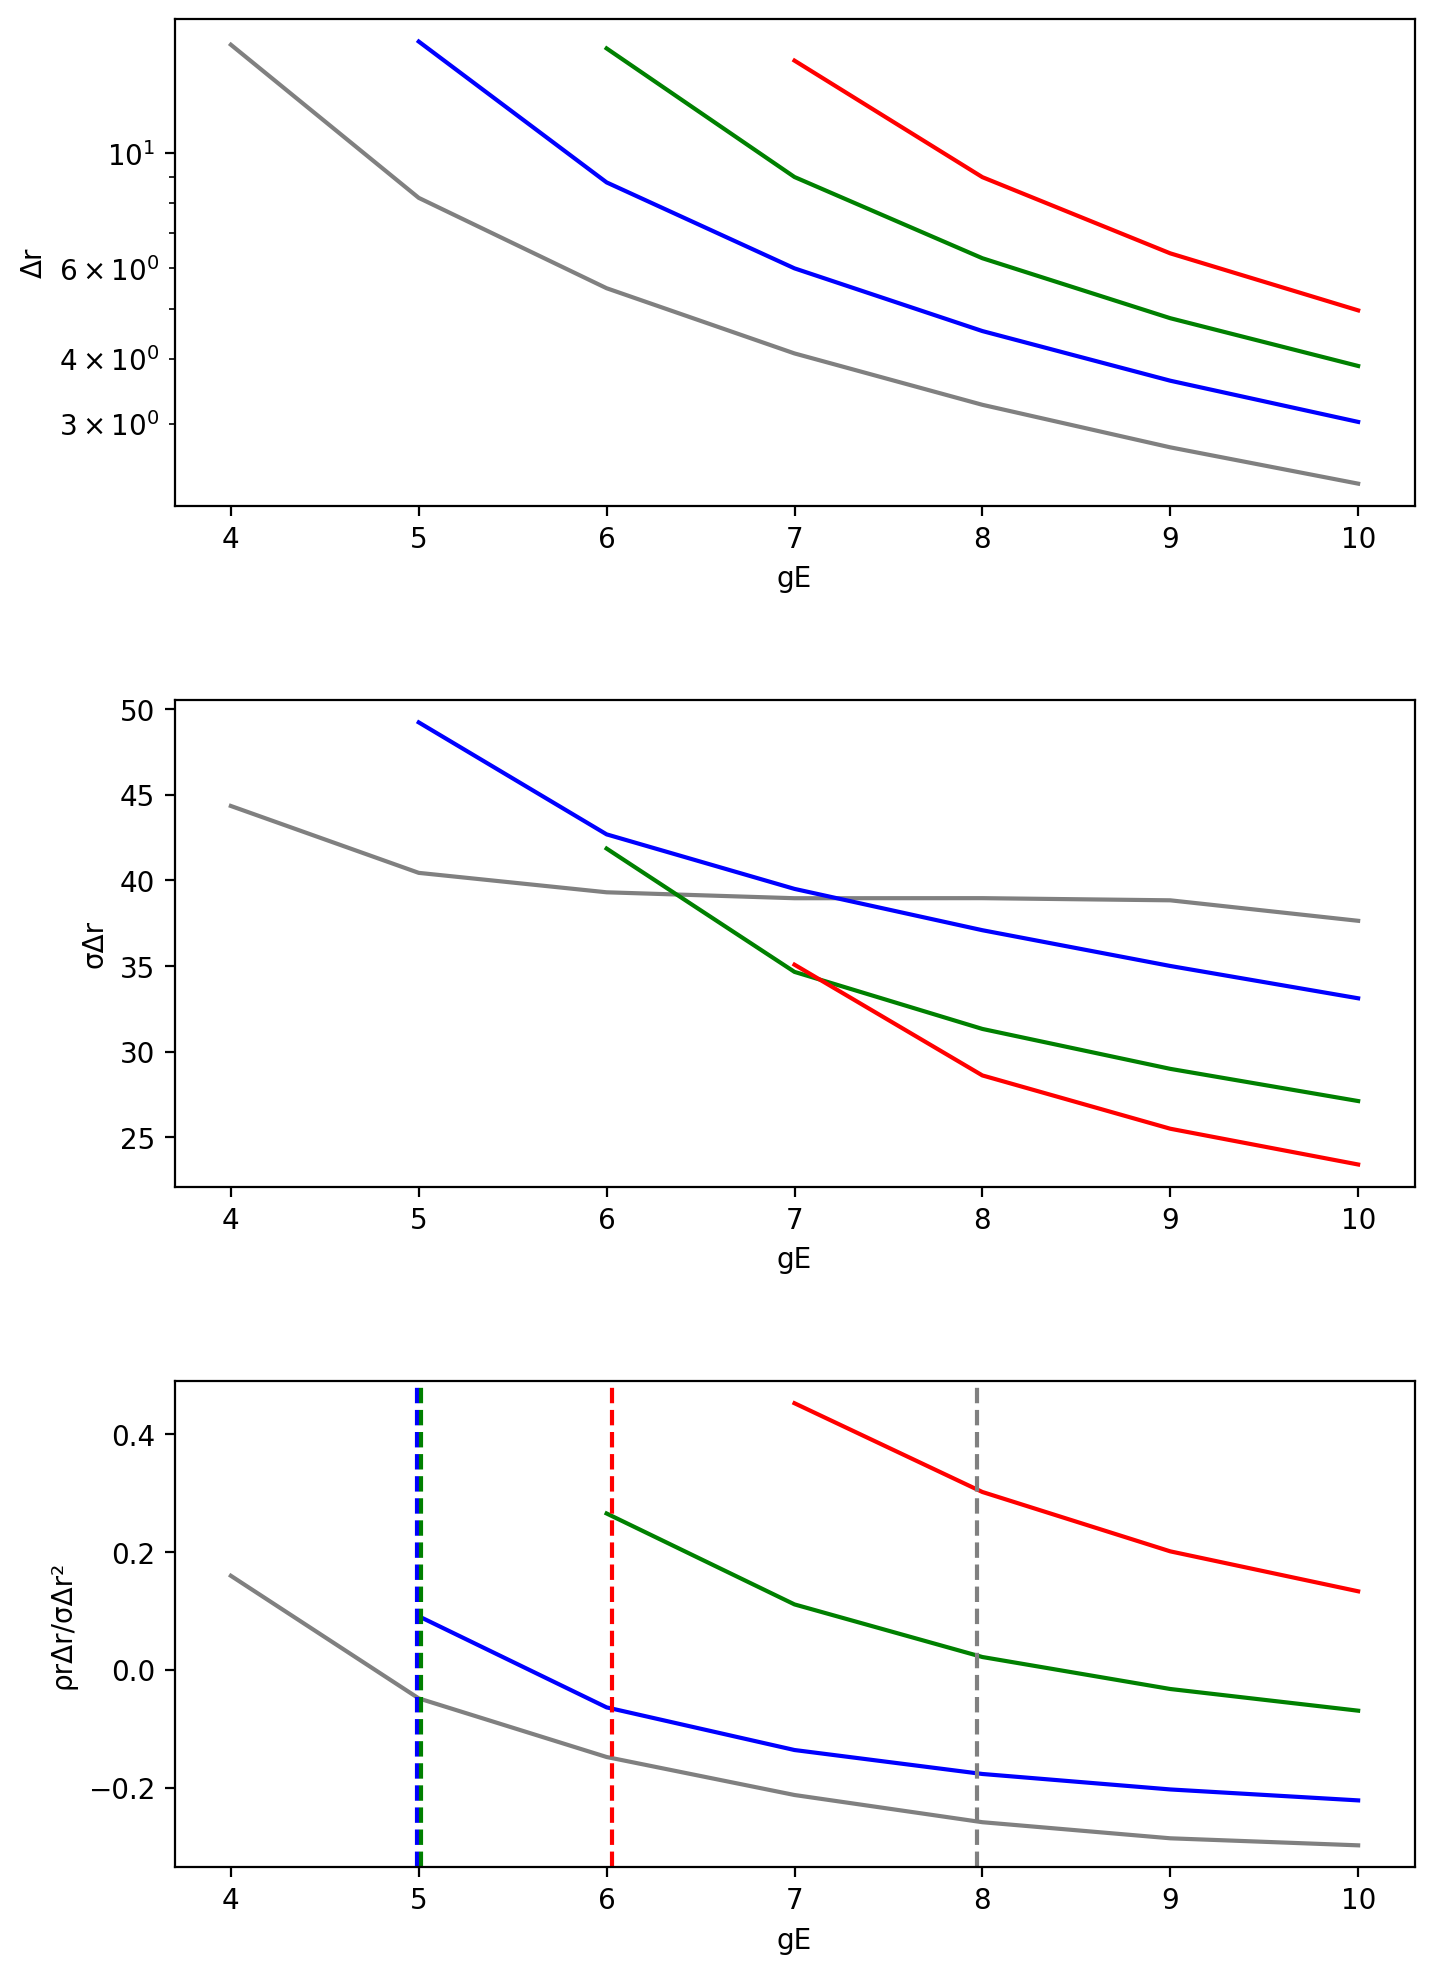

PyObject Text(76.57669019911023, 0.5, 'ρrΔr/σΔr²')

In [141]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(gECs[1:end],0.8ΔrECs[1:end,1]+0.2ΔrICs[1:end,1],"gray")
plot(gECs[2:end],0.8ΔrECs[2:end,2]+0.2ΔrICs[2:end,2],"b")
plot(gECs[3:end],0.8ΔrECs[3:end,3]+0.2ΔrICs[3:end,3],"g")
plot(gECs[4:end],0.8ΔrECs[4:end,4]+0.2ΔrICs[4:end,4],"r")
xlabel("gE")
ylabel("Δr")
yscale("log")

subplot(3,1,2)
plot(gECs[1:end],.√(max.(0.8σΔrE2Cs[1:end,1]+0.2σΔrI2Cs[1:end,1],0)),"gray")
plot(gECs[2:end],.√(max.(0.8σΔrE2Cs[2:end,2]+0.2σΔrI2Cs[2:end,2],0)),"b")
plot(gECs[3:end],.√(max.(0.8σΔrE2Cs[3:end,3]+0.2σΔrI2Cs[3:end,3],0)),"g")
plot(gECs[4:end],.√(max.(0.8σΔrE2Cs[4:end,4]+0.2σΔrI2Cs[4:end,4],0)),"r")
xlabel("gE")
ylabel("σΔr")

subplot(3,1,3)
plot(gECs[1:end],(0.8ρrEΔrECs[1:end,1]+0.2ρrIΔrICs[1:end,1])./
                (0.8σΔrE2Cs[1:end,1]+0.2σΔrI2Cs[1:end,1]),"gray")
plot(gECs[2:end],(0.8ρrEΔrECs[2:end,2]+0.2ρrIΔrICs[2:end,2])./
                (0.8σΔrE2Cs[2:end,2]+0.2σΔrI2Cs[2:end,2]),"b")
plot(gECs[3:end],(0.8ρrEΔrECs[3:end,3]+0.2ρrIΔrICs[3:end,3])./
                (0.8σΔrE2Cs[3:end,3]+0.2σΔrI2Cs[3:end,3]),"g")
plot(gECs[4:end],(0.8ρrEΔrECs[4:end,4]+0.2ρrIΔrICs[4:end,4])./
                (0.8σΔrE2Cs[4:end,4]+0.2σΔrI2Cs[4:end,4]),"r")
if any(chCs[:,1])
    axvline(gECs[findfirst(chCs[:,1])]-0.03,color="gray",ls="--")
end
if any(chCs[:,2])
    axvline(gECs[findfirst(chCs[:,2])]-0.01,color="b",ls="--")
end
if any(chCs[:,3])
    axvline(gECs[findfirst(chCs[:,3])]+0.01,color="g",ls="--")
end
if any(chCs[:,4])
    axvline(gECs[findfirst(chCs[:,4])]+0.03,color="r",ls="--")
end
xlabel("gE")
ylabel("ρrΔr/σΔr²")

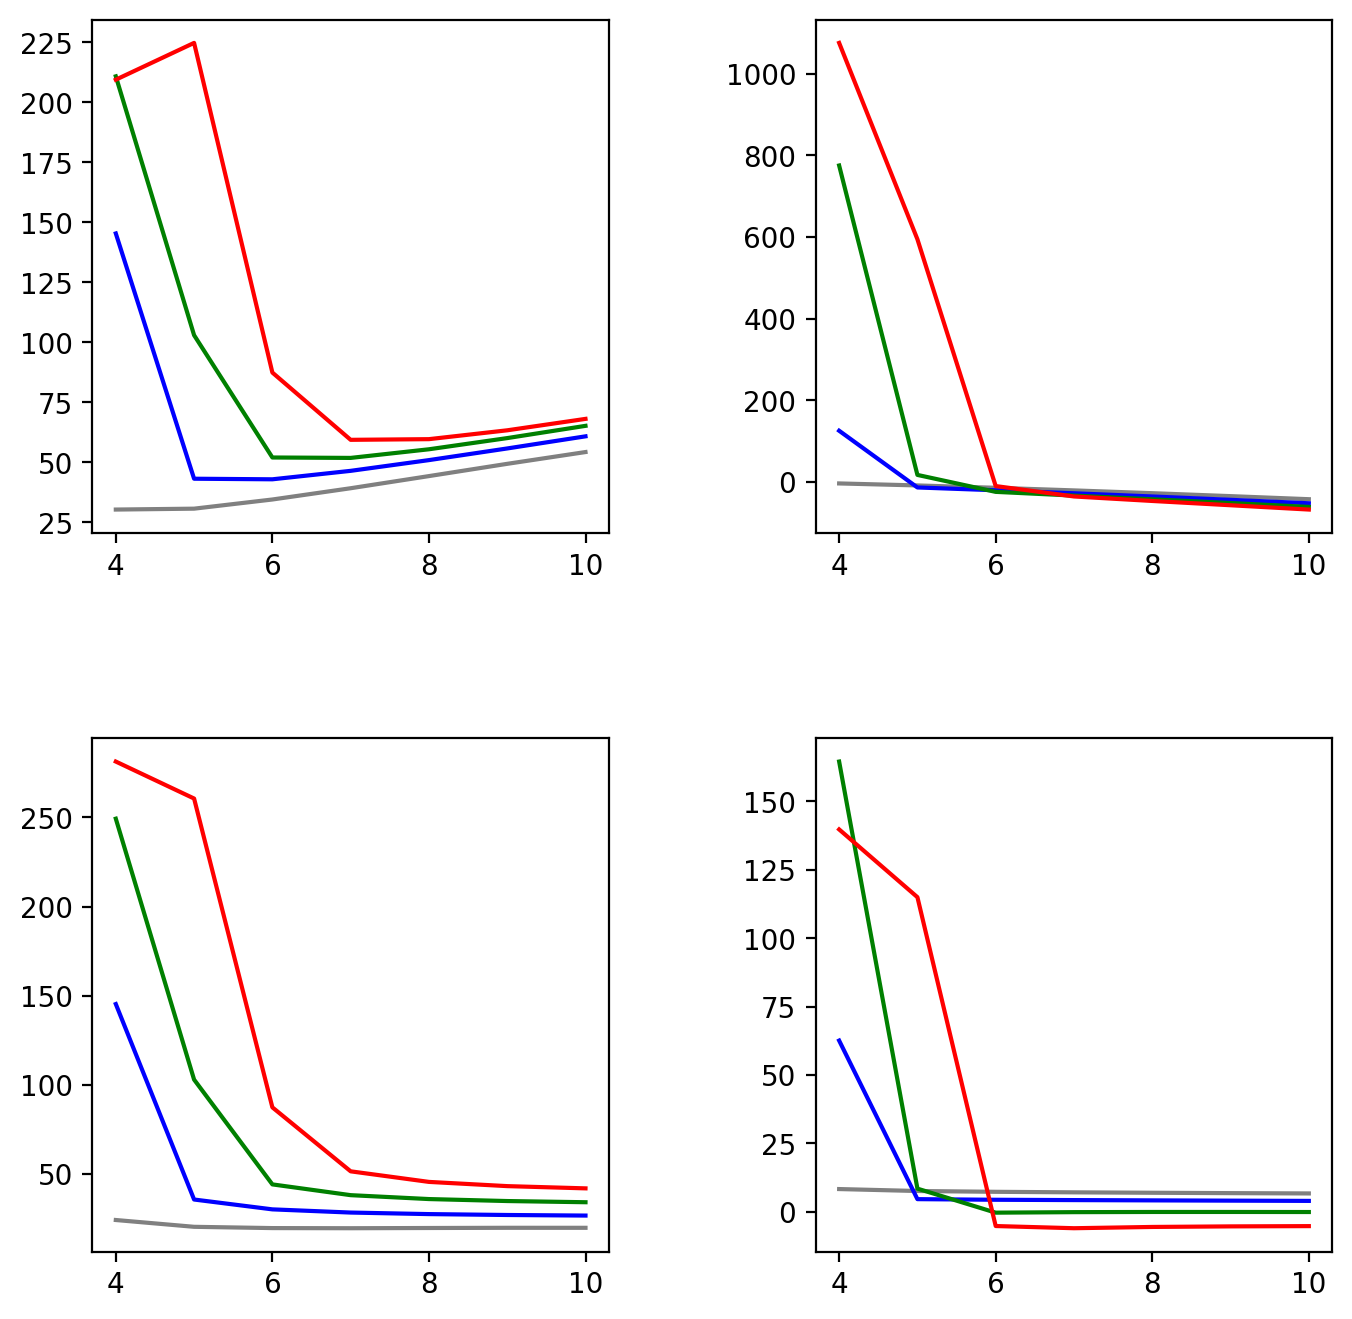

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff3d208d4f0>

In [142]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,2,1)
plot(gECs,.√(max.(σμE2Cs[:,1],0)),"gray")
plot(gECs,.√(max.(σμE2Cs[:,2],0)),"b")
plot(gECs,.√(max.(σμE2Cs[:,3],0)),"g")
plot(gECs,.√(max.(σμE2Cs[:,4],0)),"r")

subplot(2,2,3)
plot(gECs,.√(max.(σμI2Cs[:,1],0)),"gray")
plot(gECs,.√(max.(σμI2Cs[:,2],0)),"b")
plot(gECs,.√(max.(σμI2Cs[:,3],0)),"g")
plot(gECs,.√(max.(σμI2Cs[:,4],0)),"r")

subplot(2,2,2)
plot(gECs,μECs[:,1],"gray")
plot(gECs,μECs[:,2],"b")
plot(gECs,μECs[:,3],"g")
plot(gECs,μECs[:,4],"r")

subplot(2,2,4)
plot(gECs,μICs[:,1],"gray")
plot(gECs,μICs[:,2],"b")
plot(gECs,μICs[:,3],"g")
plot(gECs,μICs[:,4],"r")

# Panel D

In [277]:
# sDs = [0.1, 0.16681, 0.278256, 0.464159, 0.774264,
#     1.29155, 2.154435, 3.593814, 5.994843, 10.0]
# JDs = [7.7e-2, 0.215, 0.599, 1.0]
# chDs = zeros(Bool,length(sDs),length(JDs))
# convDs = zeros(Bool,length(sDs),length(JDs))
# μEDs = zeros(length(sDs),length(JDs))
# μIDs = zeros(length(sDs),length(JDs))
# ΔμEDs = zeros(length(sDs),length(JDs))
# ΔμIDs = zeros(length(sDs),length(JDs))
# σμE2Ds = zeros(length(sDs),length(JDs))
# σμI2Ds = zeros(length(sDs),length(JDs))
# σΔμE2Ds = zeros(length(sDs),length(JDs))
# σΔμI2Ds = zeros(length(sDs),length(JDs))
# ρμEΔμEDs = zeros(length(sDs),length(JDs))
# ρμIΔμIDs = zeros(length(sDs),length(JDs))
# rEDs = zeros(length(sDs),length(JDs))
# rIDs = zeros(length(sDs),length(JDs))
# ΔrEDs = zeros(length(sDs),length(JDs))
# ΔrIDs = zeros(length(sDs),length(JDs))
# σrE2Ds = zeros(length(sDs),length(JDs))
# σrI2Ds = zeros(length(sDs),length(JDs))
# σΔrE2Ds = zeros(length(sDs),length(JDs))
# σΔrI2Ds = zeros(length(sDs),length(JDs))
# ρrEΔrEDs = zeros(length(sDs),length(JDs))
# ρrIΔrIDs = zeros(length(sDs),length(JDs))

h5open("fig4.h5", "r") do fid
    D = fid["D"]
    global sDs = read(D,"sls")
    global JDs = read(D,"Js")
    global chDs = Matrix{Bool}(read(D,"chs")')
    global convDs = Matrix{Bool}(read(D,"convs")')
    global μEDs = Matrix(read(D,"mu_Es")')
    global μIDs = Matrix(read(D,"mu_Is")')
    global ΔμEDs = Matrix(read(D,"delta_mu_Es")')
    global ΔμIDs = Matrix(read(D,"delta_mu_Is")')
    global σμE2Ds = Matrix(read(D,"var_mu_Es")')
    global σμI2Ds = Matrix(read(D,"var_mu_Is")')
    global σΔμE2Ds = Matrix(read(D,"var_delta_mu_Es")')
    global σΔμI2Ds = Matrix(read(D,"var_delta_mu_Is")')
    global ρμEΔμEDs = Matrix(read(D,"cov_mu_E_delta_mu_Es")')
    global ρμIΔμIDs = Matrix(read(D,"cov_mu_I_delta_mu_Is")')
    global rEDs = Matrix(read(D,"r_Es")')
    global rIDs = Matrix(read(D,"r_Is")')
    global ΔrEDs = Matrix(read(D,"delta_r_Es")')
    global ΔrIDs = Matrix(read(D,"delta_r_Is")')
    global σrE2Ds = Matrix(read(D,"var_r_Es")')
    global σrI2Ds = Matrix(read(D,"var_r_Is")')
    global σΔrE2Ds = Matrix(read(D,"var_delta_r_Es")')
    global σΔrI2Ds = Matrix(read(D,"var_delta_r_Is")')
    global ρrEΔrEDs = Matrix(read(D,"cov_r_E_delta_r_Es")')
    global ρrIΔrIDs = Matrix(read(D,"cov_r_I_delta_r_Is")')
end

10×4 Matrix{Float64}:
 28.8185  85.0556   115.76      11.2311
 28.7775  84.6485    96.9974    10.0207
 28.6491  83.5793    58.1213    27.9087
 28.2977  80.687    -15.683     -3.2715
 27.4428  74.093   -148.308    -33.7749
 25.6817  63.3531  -345.737   -124.163
 23.0126  50.9441  -533.209   -269.83
 19.976   39.5895  -647.318   -379.952
 17.0611  30.3009  -699.825   -434.472
 14.4774  23.0489  -716.4     -453.864

In [301]:
for i in [1:3;]#eachindex(sDs)
    op = LogNormOptoParams(sDs[i],20.0)
    @time ΦLitp(op,[rpE])
    @time MLitp(op,[rpE])
    @time CLitp(op,[rpE])
    for j in eachindex(JDs)
        J = JDs[j]
        rX = 17.969068

        TWrm = 0.8
        TSave = 0.6
        dt = 0.0025

        count = 1
        @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt)
        while !conv && count < 20
            @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
                CrEinit=CrE,CrIinit=CrI)
            count += 1
        end
        convDs[i,j] = conv
        count = 1
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI)
        while !conv && count < 8
            @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
                rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
                RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
            count += 1
        end
        convDs[i,j] &= conv

        function extend(a::Vector{Float64},T::AbstractFloat,
                dt::AbstractFloat)::Matrix{Float64}
            oldn = length(a)
            newn = round(Int,T/dt)+1
            b = a[end]*ones((newn,newn))
            for i in 1:oldn
                b[i:i+oldn-1,i] .= a
                b[i,i:i+oldn-1] .= a
            end
            for i in 1:newn-oldn
                b[i+oldn:-1:i+1,i+oldn] .= a
                b[i+oldn,i+oldn:-1:i+1] .= a
            end
            return b
        end

        q = 1-np.p
        τEJK = np.rpE.τs*J*np.K
        τIJK = np.rpI.τs*J*np.K
        J2K = J^2*np.K
        τE2J2K = np.rpE.τs^2*J^2*np.K
        τI2J2K = np.rpE.τs^2*J^2*np.K
        W2 = np.W.^2
        σrX2 = (np.sX*rX)^2

        σrE2 = CrE.-rE^2
        σrI2 = CrI.-rI^2
        σΔrE2 = CΔrE.-ΔrE^2
        σΔrI2 = CΔrI.-ΔrI^2
        ρrEΔrE = RrEΔrE.-rE*ΔrE
        ρrIΔrI = RrIΔrI.-rI*ΔrI

        μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
        μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
        ΔμE = τEJK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
        ΔμI = τIJK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
        σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+np.γ*W2[1,2]*rI^2) .+
                        W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
        σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+np.γ*W2[2,2]*rI^2) .+
                        W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
        σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+np.γ*W2[1,2]*ΔrI^2) .+
                        W2[1,1]*σΔrE2.+np.γ*W2[1,2]*σΔrI2)
        σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+np.γ*W2[2,2]*ΔrI^2) .+
                        W2[2,1]*σΔrE2.+np.γ*W2[2,2]*σΔrI2)
        ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+np.γ*W2[1,2]*rI*ΔrI) .+
                        W2[1,1]*ρrEΔrE.+np.γ*W2[1,2]*ρrIΔrI)
        ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+np.γ*W2[2,2]*rI*ΔrI) .+
                        W2[2,1]*ρrEΔrE.+np.γ*W2[2,2]*ρrIΔrI)

        chDs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
        μEDs[i,j] = μE
        μIDs[i,j] = μI
        ΔμEDs[i,j] = ΔμE
        ΔμIDs[i,j] = ΔμI
        σμE2Ds[i,j] = mean(extend(σμE2,4.0,dt))
        σμI2Ds[i,j] = mean(extend(σμI2,4.0,dt))
        σΔμE2Ds[i,j] = mean(extend(σΔμE2,4.0,dt))
        σΔμI2Ds[i,j] = mean(extend(σΔμI2,4.0,dt))
        ρμEΔμEDs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
        ρμIΔμIDs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
        rEDs[i,j] = rE
        rIDs[i,j] = rI
        ΔrEDs[i,j] = ΔrE
        ΔrIDs[i,j] = ΔrI
        σrE2Ds[i,j] = mean(extend(σrE2,4.0,dt))
        σrI2Ds[i,j] = mean(extend(σrI2,4.0,dt))
        σΔrE2Ds[i,j] = mean(extend(σΔrE2,4.0,dt))
        σΔrI2Ds[i,j] = mean(extend(σΔrI2,4.0,dt))
        ρrEΔrEDs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
        ρrIΔrIDs[i,j] = mean(extend(ρrIΔrI,4.0,dt))

        @printf "%d/%d completed\n" length(JDs)*(i-1)+j length(sDs)*length(JDs)
    end
end

 22.746869 seconds (726.64 M allocations: 11.121 GiB, 8.23% gc time)
666.117175 seconds (20.78 G allocations: 316.785 GiB, 8.32% gc time)
3210.451787 seconds (90.99 G allocations: 1.359 TiB, 7.87% gc time)
  0.449952 seconds (10.97 M allocations: 172.275 MiB)
 68.658412 seconds (2.09 G allocations: 34.733 GiB, 9.97% gc time)
1/40 completed
  1.371538 seconds (10.97 M allocations: 172.275 MiB, 73.05% gc time)
 99.053953 seconds (3.13 G allocations: 52.563 GiB, 10.11% gc time)
2/40 completed
  0.514211 seconds (10.97 M allocations: 172.275 MiB)
  0.345590 seconds (10.97 M allocations: 172.275 MiB)
  0.342933 seconds (10.97 M allocations: 172.275 MiB)
  0.434211 seconds (10.97 M allocations: 172.275 MiB)
  0.875469 seconds (10.97 M allocations: 172.275 MiB)
  1.167789 seconds (10.97 M allocations: 172.275 MiB, 35.81% gc time)
  0.340571 seconds (10.97 M allocations: 172.275 MiB)
 97.671366 seconds (3.05 G allocations: 50.895 GiB, 9.69% gc time)
 98.108088 seconds (3.10 G allocations: 51.5

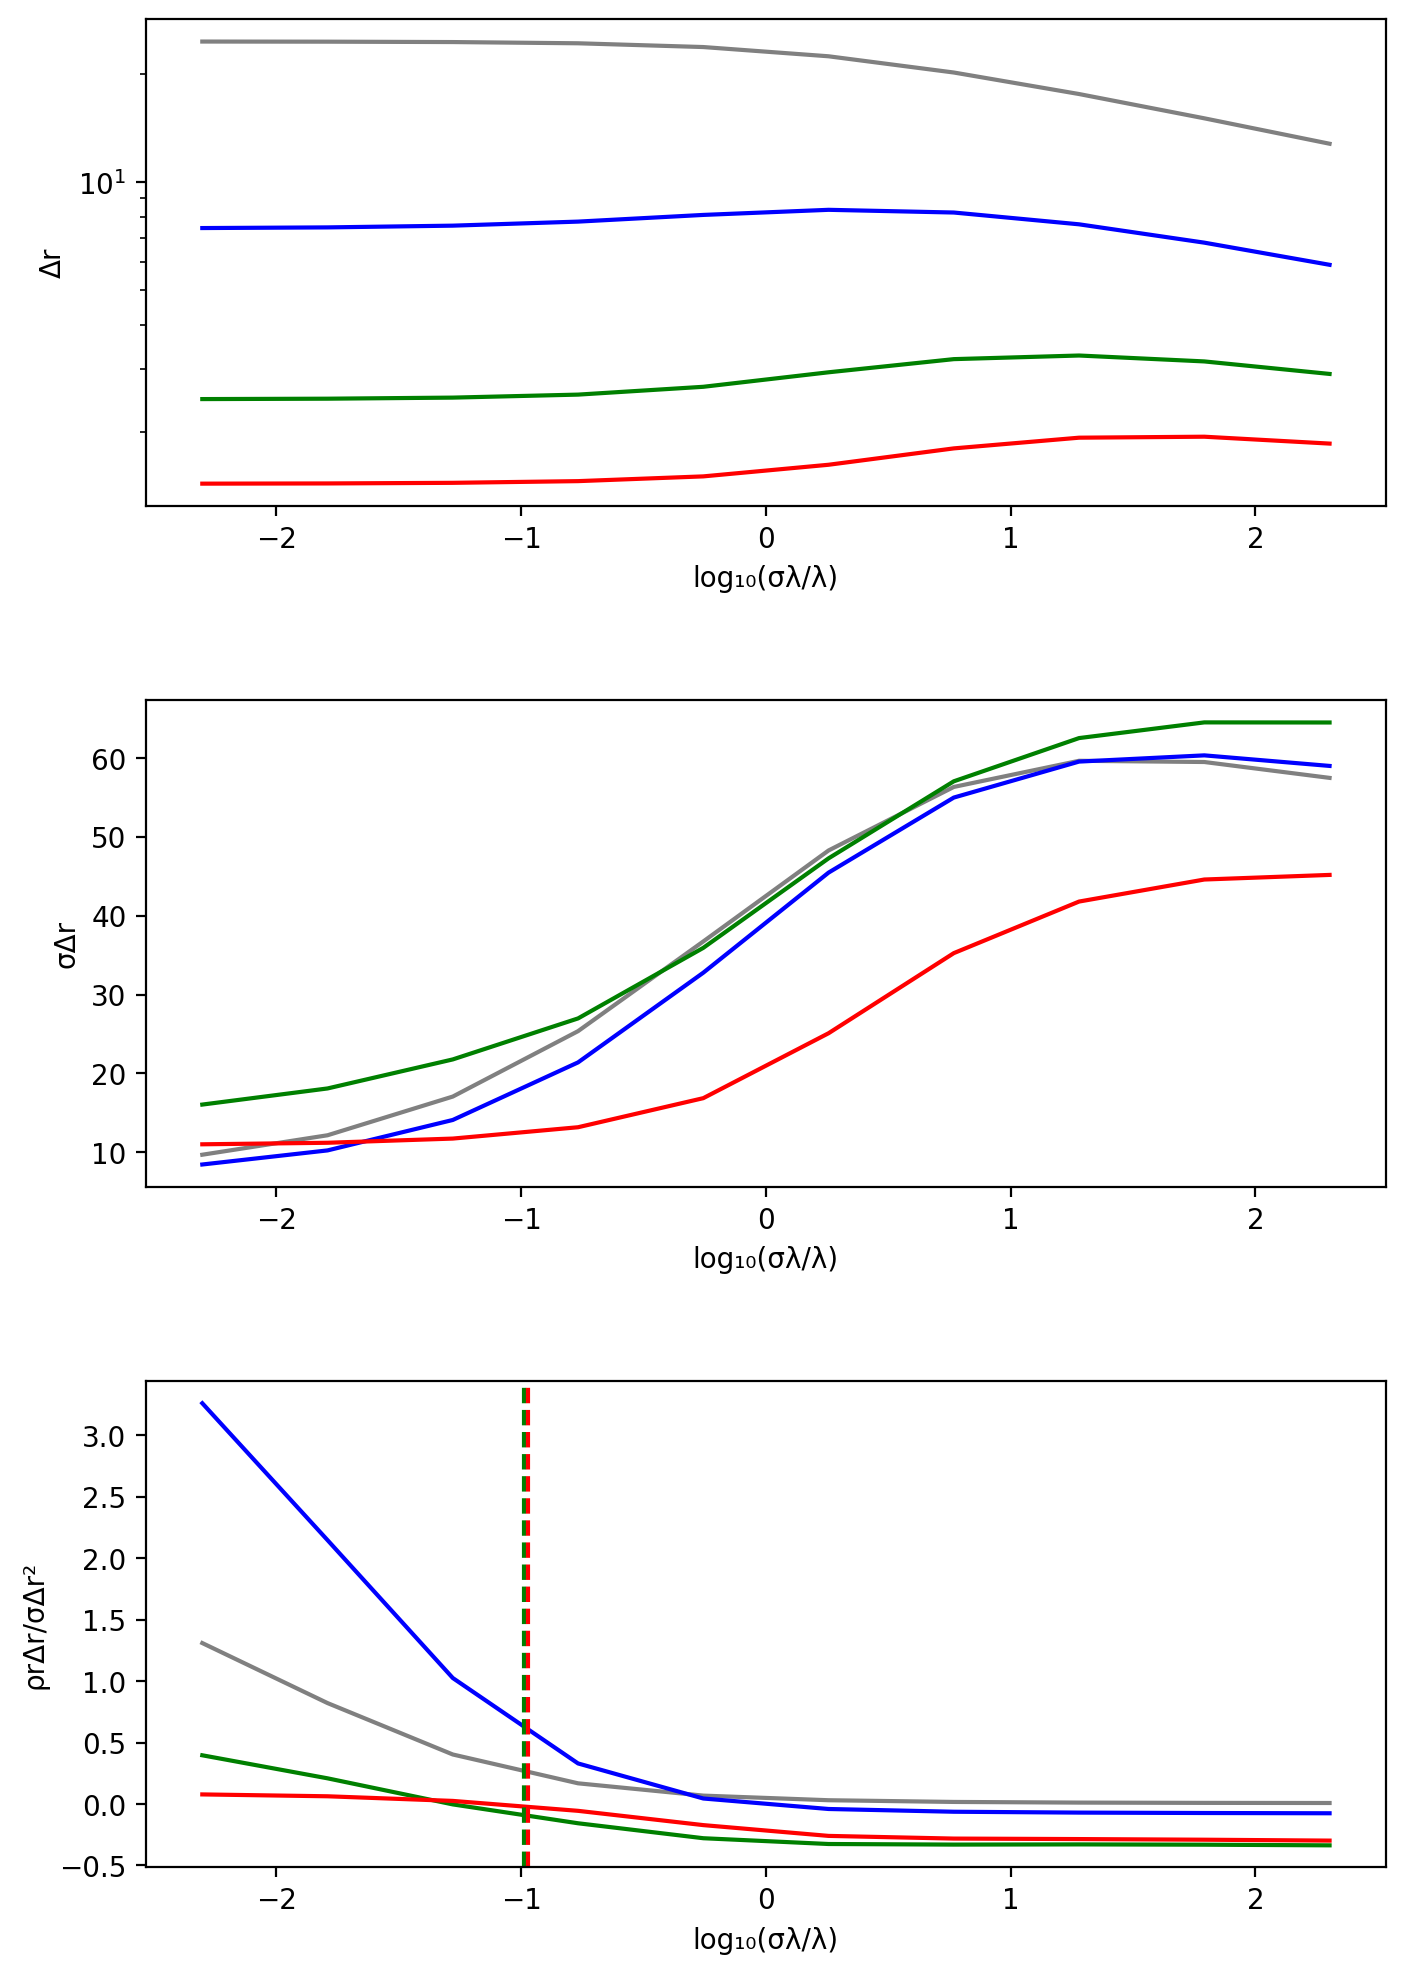

PyObject Text(48.000000000000014, 0.5, 'ρrΔr/σΔr²')

In [302]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log.(sDs),0.8ΔrEDs[:,1]+0.2ΔrIDs[:,1],"gray")
plot(log.(sDs),0.8ΔrEDs[:,2]+0.2ΔrIDs[:,2],"b")
plot(log.(sDs),0.8ΔrEDs[:,3]+0.2ΔrIDs[:,3],"g")
plot(log.(sDs),0.8ΔrEDs[:,4]+0.2ΔrIDs[:,4],"r")
xlabel("log₁₀(σλ/λ)")
ylabel("Δr")
yscale("log")

subplot(3,1,2)
plot(log.(sDs),.√(max.(0.8σΔrE2Ds[:,1]+0.2σΔrI2Ds[:,1],0)),"gray")
plot(log.(sDs),.√(max.(0.8σΔrE2Ds[:,2]+0.2σΔrI2Ds[:,2],0)),"b")
plot(log.(sDs),.√(max.(0.8σΔrE2Ds[:,3]+0.2σΔrI2Ds[:,3],0)),"g")
plot(log.(sDs),.√(max.(0.8σΔrE2Ds[:,4]+0.2σΔrI2Ds[:,4],0)),"r")
xlabel("log₁₀(σλ/λ)")
ylabel("σΔr")

subplot(3,1,3)
plot(log.(sDs),(0.8ρrEΔrEDs[:,1]+0.2ρrIΔrIDs[:,1])./
                (0.8σΔrE2Ds[:,1]+0.2σΔrI2Ds[:,1]),"gray")
plot(log.(sDs),(0.8ρrEΔrEDs[:,2]+0.2ρrIΔrIDs[:,2])./
                (0.8σΔrE2Ds[:,2]+0.2σΔrI2Ds[:,2]),"b")
plot(log.(sDs),(0.8ρrEΔrEDs[:,3]+0.2ρrIΔrIDs[:,3])./
                (0.8σΔrE2Ds[:,3]+0.2σΔrI2Ds[:,3]),"g")
plot(log.(sDs),(0.8ρrEΔrEDs[:,4]+0.2ρrIΔrIDs[:,4])./
                (0.8σΔrE2Ds[:,4]+0.2σΔrI2Ds[:,4]),"r")
if any(chDs[:,1])
    axvline(log10(sDs[findfirst(chDs[:,1])])-0.03,color="gray",ls="--")
end
if any(chDs[:,2])
    axvline(log10(sDs[findfirst(chDs[:,2])])-0.01,color="b",ls="--")
end
if any(chDs[:,3])
    axvline(log10(sDs[findfirst(chDs[:,3])])+0.01,color="g",ls="--")
end
if any(chDs[:,4])
    axvline(log10(sDs[findfirst(chDs[:,4])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(σλ/λ)")
ylabel("ρrΔr/σΔr²")

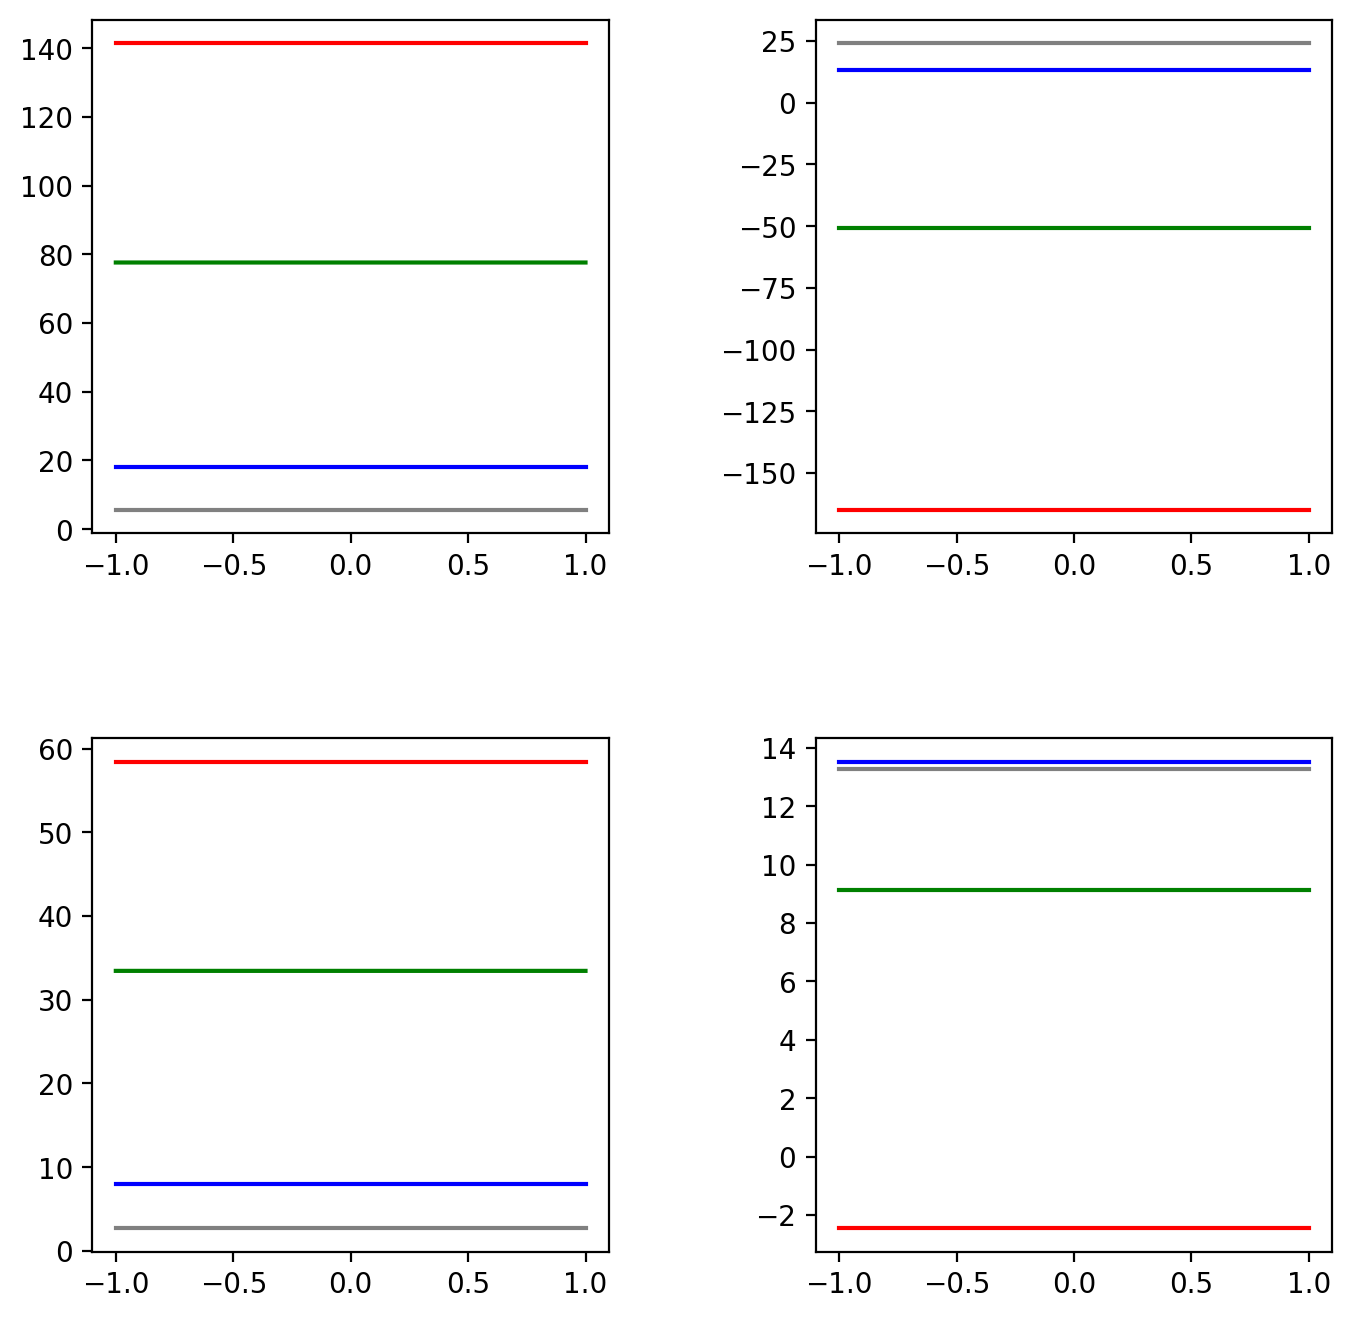

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff3e4b19a90>

In [152]:
figure(figsize=(4*2,4*2),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(2,2,1)
plot(log10.(sDs),.√(max.(σμE2Ds[:,1],0)),"gray")
plot(log10.(sDs),.√(max.(σμE2Ds[:,2],0)),"b")
plot(log10.(sDs),.√(max.(σμE2Ds[:,3],0)),"g")
plot(log10.(sDs),.√(max.(σμE2Ds[:,4],0)),"r")

subplot(2,2,3)
plot(log10.(sDs),.√(max.(σμI2Ds[:,1],0)),"gray")
plot(log10.(sDs),.√(max.(σμI2Ds[:,2],0)),"b")
plot(log10.(sDs),.√(max.(σμI2Ds[:,3],0)),"g")
plot(log10.(sDs),.√(max.(σμI2Ds[:,4],0)),"r")

subplot(2,2,2)
plot(log10.(sDs),μEDs[:,1],"gray")
plot(log10.(sDs),μEDs[:,2],"b")
plot(log10.(sDs),μEDs[:,3],"g")
plot(log10.(sDs),μEDs[:,4],"r")

subplot(2,2,4)
plot(log10.(sDs),μIDs[:,1],"gray")
plot(log10.(sDs),μIDs[:,2],"b")
plot(log10.(sDs),μIDs[:,3],"g")
plot(log10.(sDs),μIDs[:,4],"r")

# All Panels

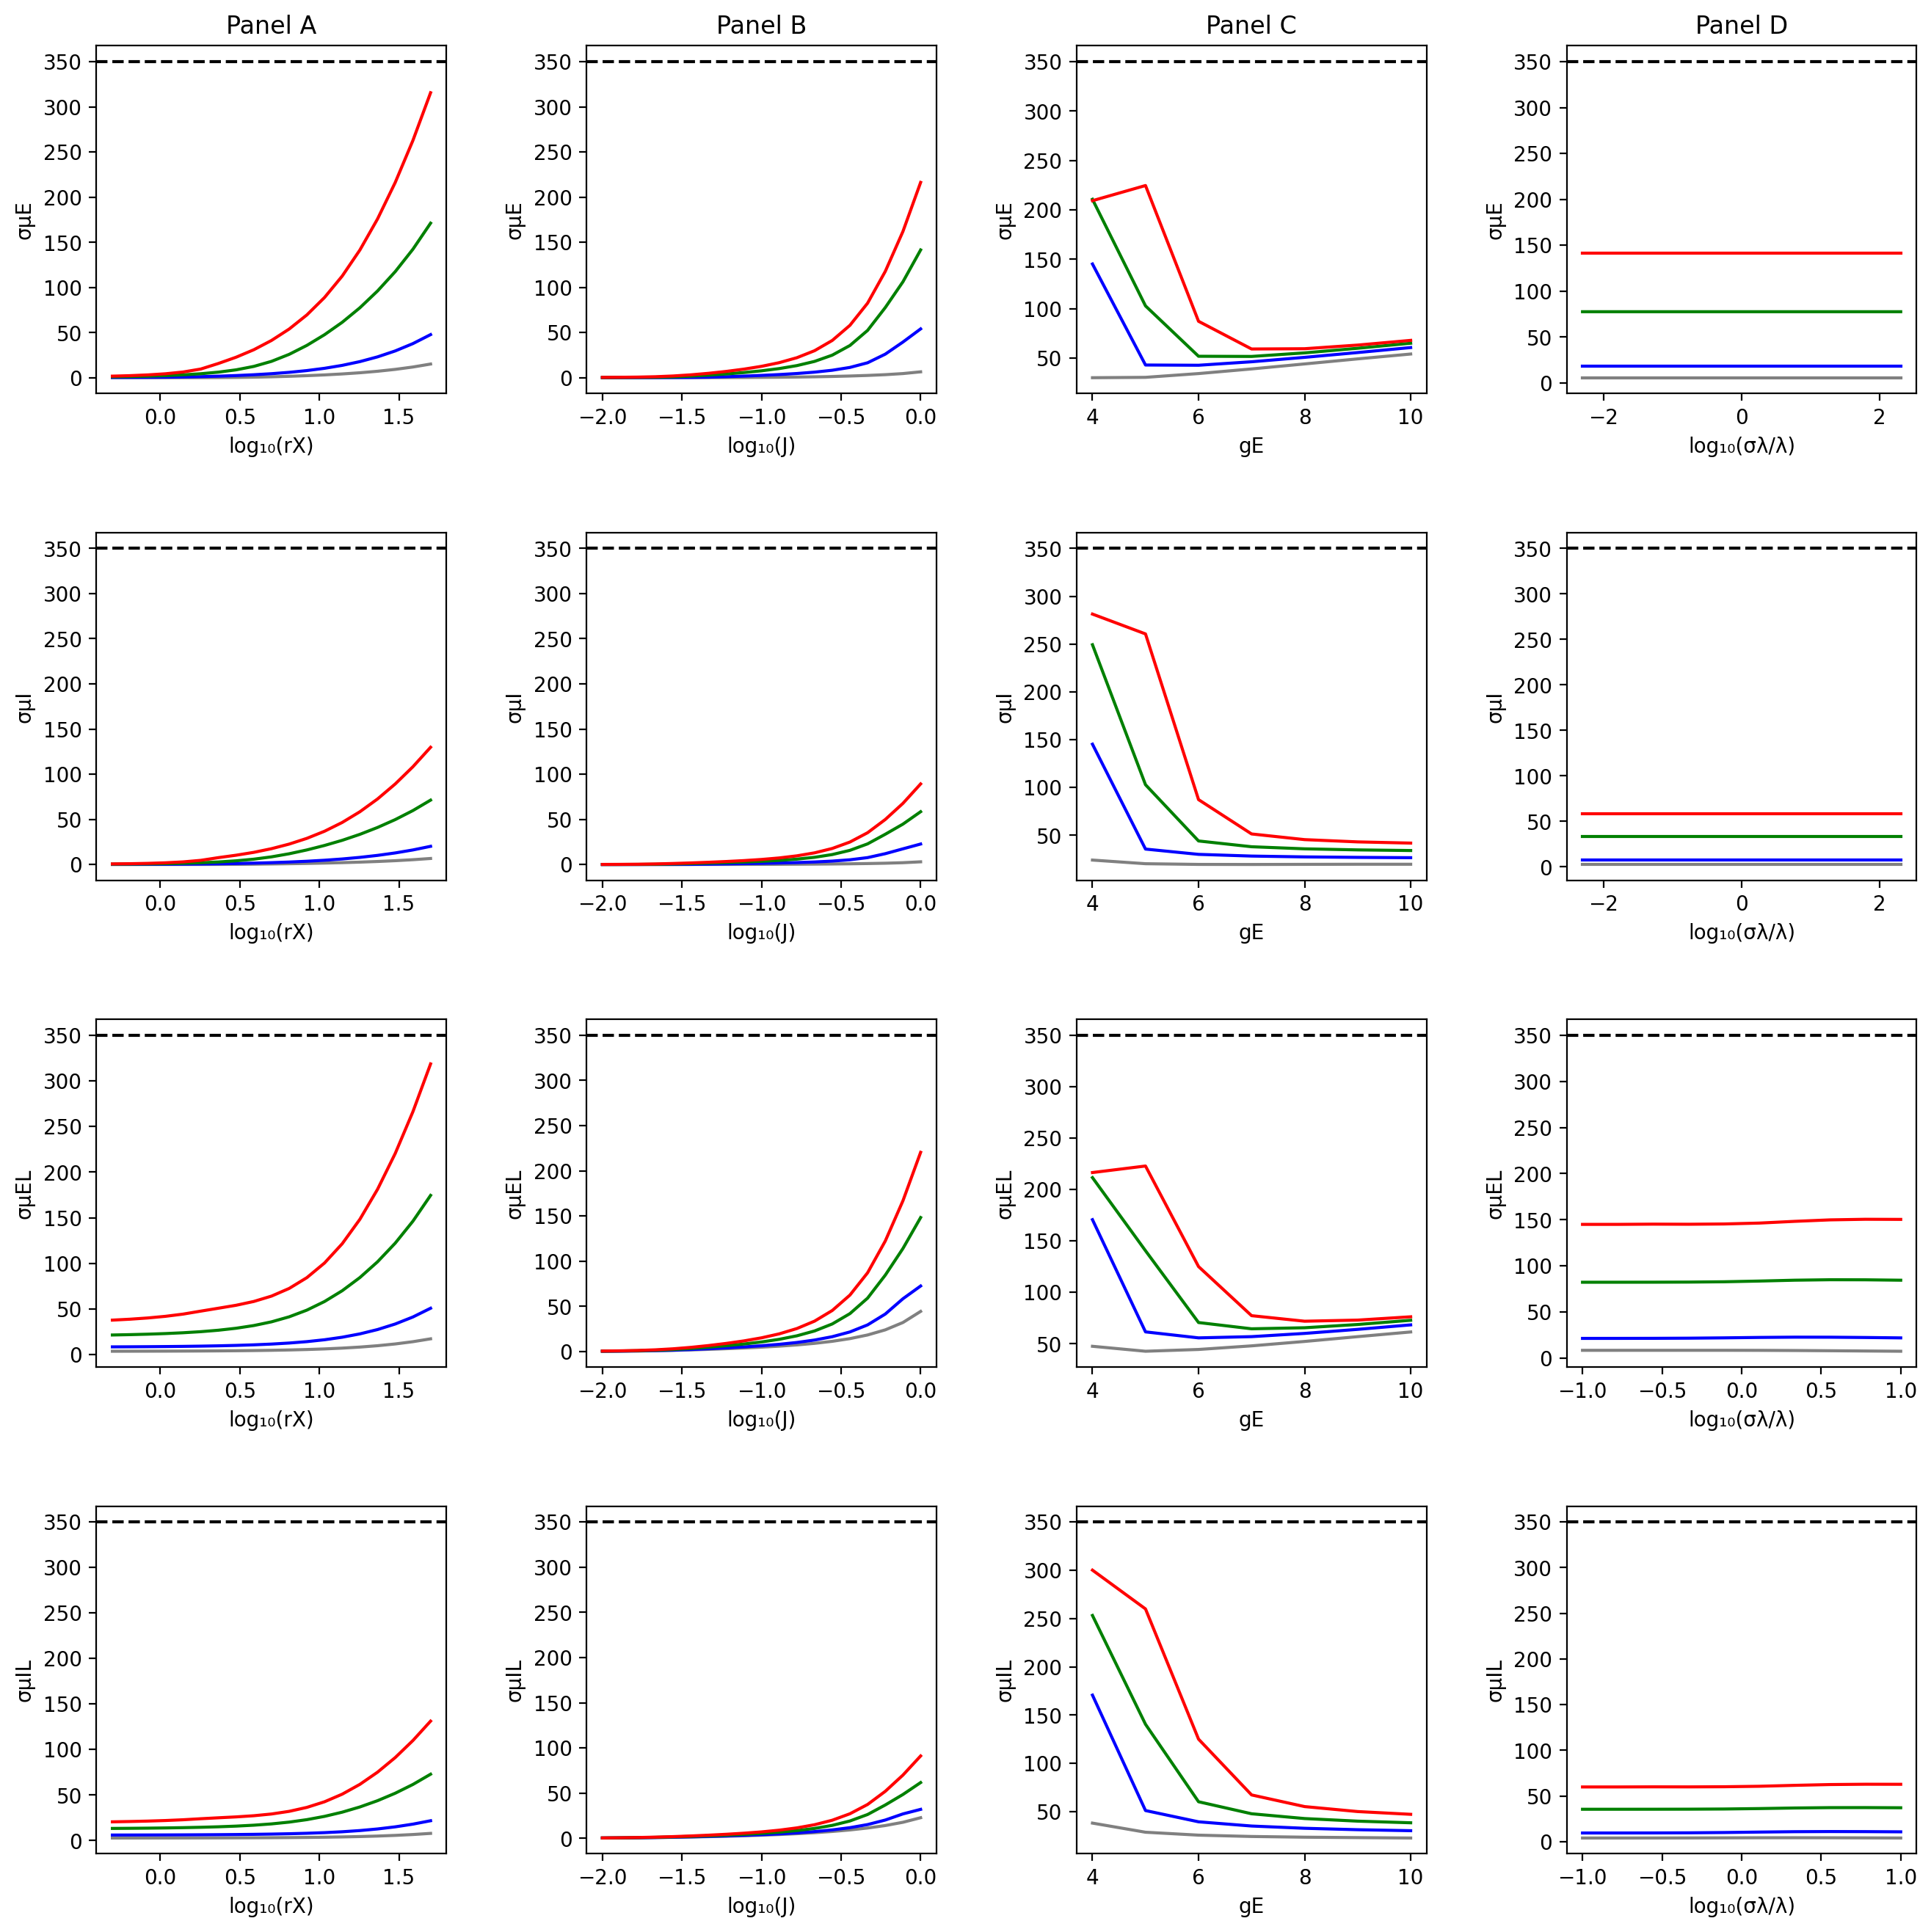

PyObject Text(2051.076923076923, 0.5, 'σμIL')

In [291]:
figure(figsize=(4*4,4*4),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(4,4,1)
plot(log10.(rXAs),.√(max.(σμE2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμE2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμE2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμE2As[4,:],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(rX)")
ylabel("σμE")
title("Panel A")

subplot(4,4,5)
plot(log10.(rXAs),.√(max.(σμI2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμI2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμI2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμI2As[4,:],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(rX)")
ylabel("σμI")

subplot(4,4,9)
plot(log10.(rXAs),.√(max.(σμE2As[1,:]+σΔμE2As[1,:]+2ρμEΔμEAs[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμE2As[2,:]+σΔμE2As[2,:]+2ρμEΔμEAs[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμE2As[3,:]+σΔμE2As[3,:]+2ρμEΔμEAs[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμE2As[4,:]+σΔμE2As[4,:]+2ρμEΔμEAs[4,:],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(rX)")
ylabel("σμEL")

subplot(4,4,13)
plot(log10.(rXAs),.√(max.(σμI2As[1,:]+σΔμI2As[1,:]+2ρμIΔμIAs[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμI2As[2,:]+σΔμI2As[2,:]+2ρμIΔμIAs[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμI2As[3,:]+σΔμI2As[3,:]+2ρμIΔμIAs[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμI2As[4,:]+σΔμI2As[4,:]+2ρμIΔμIAs[4,:],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(rX)")
ylabel("σμIL")

subplot(4,4,2)
plot(log10.(JBs),.√(max.(σμE2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμE2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμE2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμE2Bs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(J)")
ylabel("σμE")
title("Panel B")

subplot(4,4,6)
plot(log10.(JBs),.√(max.(σμI2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμI2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμI2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμI2Bs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(J)")
ylabel("σμI")

subplot(4,4,10)
plot(log10.(JBs),.√(max.(σμE2Bs[:,1]+σΔμE2Bs[:,1]+2ρμEΔμEBs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμE2Bs[:,2]+σΔμE2Bs[:,2]+2ρμEΔμEBs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμE2Bs[:,3]+σΔμE2Bs[:,3]+2ρμEΔμEBs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμE2Bs[:,4]+σΔμE2Bs[:,4]+2ρμEΔμEBs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(J)")
ylabel("σμEL")

subplot(4,4,14)
plot(log10.(JBs),.√(max.(σμI2Bs[:,1]+σΔμI2Bs[:,1]+2ρμIΔμIBs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμI2Bs[:,2]+σΔμI2Bs[:,2]+2ρμIΔμIBs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμI2Bs[:,3]+σΔμI2Bs[:,3]+2ρμIΔμIBs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμI2Bs[:,4]+σΔμI2Bs[:,4]+2ρμIΔμIBs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(J)")
ylabel("σμIL")

subplot(4,4,3)
plot(gECs,.√(max.(σμE2Cs[:,1],0)),"gray")
plot(gECs,.√(max.(σμE2Cs[:,2],0)),"b")
plot(gECs,.√(max.(σμE2Cs[:,3],0)),"g")
plot(gECs,.√(max.(σμE2Cs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("gE")
ylabel("σμE")
title("Panel C")

subplot(4,4,7)
plot(gECs,.√(max.(σμI2Cs[:,1],0)),"gray")
plot(gECs,.√(max.(σμI2Cs[:,2],0)),"b")
plot(gECs,.√(max.(σμI2Cs[:,3],0)),"g")
plot(gECs,.√(max.(σμI2Cs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("gE")
ylabel("σμI")

subplot(4,4,11)
plot(gECs,.√(max.(σμE2Cs[:,1]+σΔμE2Cs[:,1]+2ρμEΔμECs[:,1],0)),"gray")
plot(gECs,.√(max.(σμE2Cs[:,2]+σΔμE2Cs[:,2]+2ρμEΔμECs[:,2],0)),"b")
plot(gECs,.√(max.(σμE2Cs[:,3]+σΔμE2Cs[:,3]+2ρμEΔμECs[:,3],0)),"g")
plot(gECs,.√(max.(σμE2Cs[:,4]+σΔμE2Cs[:,4]+2ρμEΔμECs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("gE")
ylabel("σμEL")

subplot(4,4,15)
plot(gECs,.√(max.(σμI2Cs[:,1]+σΔμI2Cs[:,1]+2ρμIΔμICs[:,1],0)),"gray")
plot(gECs,.√(max.(σμI2Cs[:,2]+σΔμI2Cs[:,2]+2ρμIΔμICs[:,2],0)),"b")
plot(gECs,.√(max.(σμI2Cs[:,3]+σΔμI2Cs[:,3]+2ρμIΔμICs[:,3],0)),"g")
plot(gECs,.√(max.(σμI2Cs[:,4]+σΔμI2Cs[:,4]+2ρμIΔμICs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("gE")
ylabel("σμIL")

subplot(4,4,4)
plot(log.(sDs),.√(max.(σμE2Ds[:,1],0)),"gray")
plot(log.(sDs),.√(max.(σμE2Ds[:,2],0)),"b")
plot(log.(sDs),.√(max.(σμE2Ds[:,3],0)),"g")
plot(log.(sDs),.√(max.(σμE2Ds[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(σλ/λ)")
ylabel("σμE")
title("Panel D")

subplot(4,4,8)
plot(log.(sDs),.√(max.(σμI2Ds[:,1],0)),"gray")
plot(log.(sDs),.√(max.(σμI2Ds[:,2],0)),"b")
plot(log.(sDs),.√(max.(σμI2Ds[:,3],0)),"g")
plot(log.(sDs),.√(max.(σμI2Ds[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(σλ/λ)")
ylabel("σμI")

subplot(4,4,12)
plot(log10.(sDs),.√(max.(σμE2Ds[:,1]+σΔμE2Ds[:,1]+2ρμEΔμEDs[:,1],0)),"gray")
plot(log10.(sDs),.√(max.(σμE2Ds[:,2]+σΔμE2Ds[:,2]+2ρμEΔμEDs[:,2],0)),"b")
plot(log10.(sDs),.√(max.(σμE2Ds[:,3]+σΔμE2Ds[:,3]+2ρμEΔμEDs[:,3],0)),"g")
plot(log10.(sDs),.√(max.(σμE2Ds[:,4]+σΔμE2Ds[:,4]+2ρμEΔμEDs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(σλ/λ)")
ylabel("σμEL")

subplot(4,4,16)
plot(log10.(sDs),.√(max.(σμI2Ds[:,1]+σΔμI2Ds[:,1]+2ρμIΔμIDs[:,1],0)),"gray")
plot(log10.(sDs),.√(max.(σμI2Ds[:,2]+σΔμI2Ds[:,2]+2ρμIΔμIDs[:,2],0)),"b")
plot(log10.(sDs),.√(max.(σμI2Ds[:,3]+σΔμI2Ds[:,3]+2ρμIΔμIDs[:,3],0)),"g")
plot(log10.(sDs),.√(max.(σμI2Ds[:,4]+σΔμI2Ds[:,4]+2ρμIΔμIDs[:,4],0)),"r")
axhline(350,color="k",ls="--")
xlabel("log₁₀(σλ/λ)")
ylabel("σμIL")

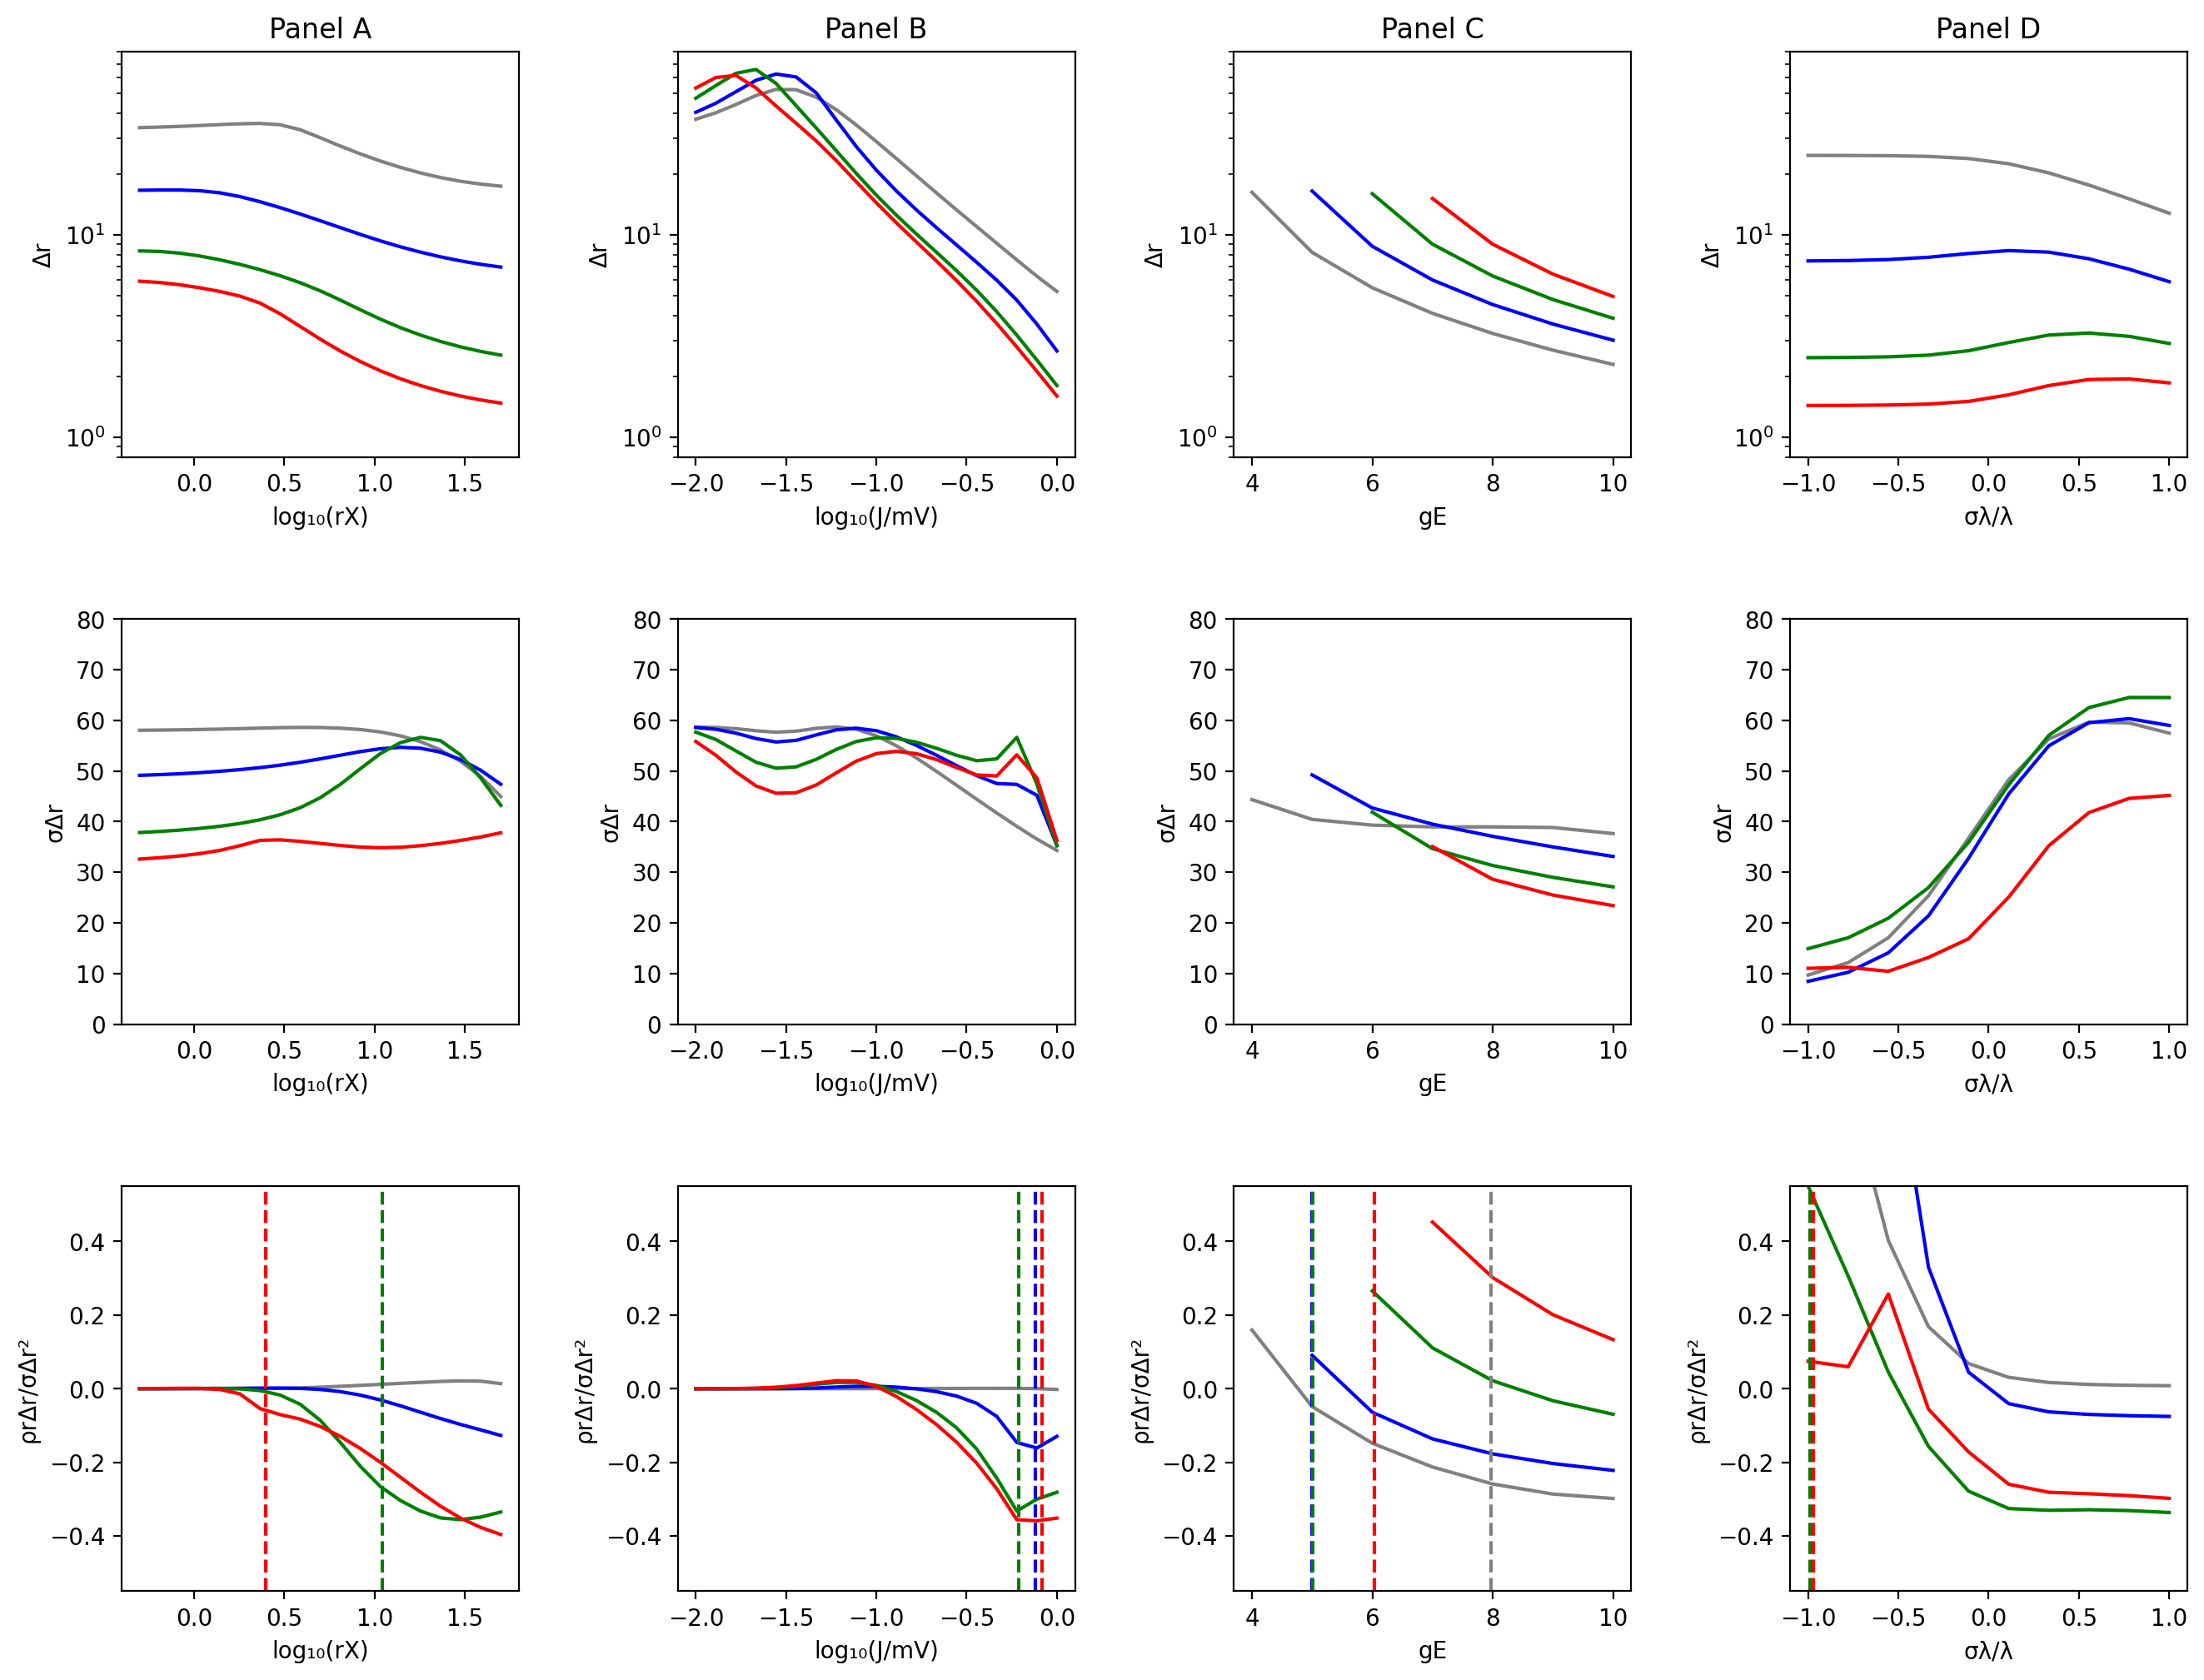

(-0.55, 0.55)

In [292]:
figure(figsize=(4*4,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,4,1)
plot(log10.(rXAs),0.8ΔrEAs[1,:]+0.2ΔrIAs[1,:],"gray")
plot(log10.(rXAs),0.8ΔrEAs[2,:]+0.2ΔrIAs[2,:],"b")
plot(log10.(rXAs),0.8ΔrEAs[3,:]+0.2ΔrIAs[3,:],"g")
plot(log10.(rXAs),0.8ΔrEAs[4,:]+0.2ΔrIAs[4,:],"r")
xlabel("log₁₀(rX)")
ylabel("Δr")
yscale("log")
ylim((8E-1,8E1))
title("Panel A")

subplot(3,4,5)
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:],0)),"r")
xlabel("log₁₀(rX)")
ylabel("σΔr")
ylim((0,80))

subplot(3,4,9)
plot(log10.(rXAs),(0.8ρrEΔrEAs[1,:]+0.2ρrIΔrIAs[1,:])./
                    (0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:]),"gray")
plot(log10.(rXAs),(0.8ρrEΔrEAs[2,:]+0.2ρrIΔrIAs[2,:])./
                    (0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:]),"b")
plot(log10.(rXAs),(0.8ρrEΔrEAs[3,:]+0.2ρrIΔrIAs[3,:])./
                    (0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:]),"g")
plot(log10.(rXAs),(0.8ρrEΔrEAs[4,:]+0.2ρrIΔrIAs[4,:])./
                    (0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:]),"r")
if any(chAs[1,:])
    axvline(log10.(rXAs[findfirst(chAs[1,:])])-0.03,color="gray",ls="--")
end
if any(chAs[2,:])
    axvline(log10.(rXAs[findfirst(chAs[2,:])])-0.01,color="b",ls="--")
end
if any(chAs[3,:])
    axvline(log10.(rXAs[findfirst(chAs[3,:])])+0.01,color="g",ls="--")
end
if any(chAs[4,:])
    axvline(log10.(rXAs[findfirst(chAs[4,:])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(rX)")
ylabel("ρrΔr/σΔr²")
ylim((-0.55,0.55))

subplot(3,4,2)
plot(log10.(JBs),0.8ΔrEBs[:,1]+0.2ΔrIBs[:,1],"gray")
plot(log10.(JBs),0.8ΔrEBs[:,2]+0.2ΔrIBs[:,2],"b")
plot(log10.(JBs),0.8ΔrEBs[:,3]+0.2ΔrIBs[:,3],"g")
plot(log10.(JBs),0.8ΔrEBs[:,4]+0.2ΔrIBs[:,4],"r")
xlabel("log₁₀(J/mV)")
ylabel("Δr")
yscale("log")
ylim((8E-1,8E1))
title("Panel B")

subplot(3,4,6)
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4],0)),"r")
xlabel("log₁₀(J/mV)")
ylabel("σΔr")
ylim((0,80))

subplot(3,4,10)
plot(log10.(JBs),(0.8ρrEΔrEBs[:,1]+0.2ρrIΔrIBs[:,1])./
                    (0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1]),"gray")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,2]+0.2ρrIΔrIBs[:,2])./
                    (0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2]),"b")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,3]+0.2ρrIΔrIBs[:,3])./
                    (0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3]),"g")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,4]+0.2ρrIΔrIBs[:,4])./
                    (0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4]),"r")
if any(chBs[:,1])
    axvline(log10.(JBs[findfirst(chBs[:,1])])-0.03,color="gray",ls="--")
end
if any(chBs[:,2])
    axvline(log10.(JBs[findfirst(chBs[:,2])])-0.01,color="b",ls="--")
end
if any(chBs[:,3])
    axvline(log10.(JBs[findfirst(chBs[:,3])])+0.01,color="g",ls="--")
end
if any(chBs[:,4])
    axvline(log10.(JBs[findfirst(chBs[:,4])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(J/mV)")
ylabel("ρrΔr/σΔr²")
ylim((-0.55,0.55))

subplot(3,4,3)
plot(gECs[1:end],0.8ΔrECs[1:end,1]+0.2ΔrICs[1:end,1],"gray")
plot(gECs[2:end],0.8ΔrECs[2:end,2]+0.2ΔrICs[2:end,2],"b")
plot(gECs[3:end],0.8ΔrECs[3:end,3]+0.2ΔrICs[3:end,3],"g")
plot(gECs[4:end],0.8ΔrECs[4:end,4]+0.2ΔrICs[4:end,4],"r")
xlabel("gE")
ylabel("Δr")
yscale("log")
ylim((8E-1,8E1))
title("Panel C")

subplot(3,4,7)
plot(gECs[1:end],.√(max.(0.8σΔrE2Cs[1:end,1]+0.2σΔrI2Cs[1:end,1],0)),"gray")
plot(gECs[2:end],.√(max.(0.8σΔrE2Cs[2:end,2]+0.2σΔrI2Cs[2:end,2],0)),"b")
plot(gECs[3:end],.√(max.(0.8σΔrE2Cs[3:end,3]+0.2σΔrI2Cs[3:end,3],0)),"g")
plot(gECs[4:end],.√(max.(0.8σΔrE2Cs[4:end,4]+0.2σΔrI2Cs[4:end,4],0)),"r")
xlabel("gE")
ylabel("σΔr")
ylim((0,80))

subplot(3,4,11)
plot(gECs[1:end],(0.8ρrEΔrECs[1:end,1]+0.2ρrIΔrICs[1:end,1])./
                (0.8σΔrE2Cs[1:end,1]+0.2σΔrI2Cs[1:end,1]),"gray")
plot(gECs[2:end],(0.8ρrEΔrECs[2:end,2]+0.2ρrIΔrICs[2:end,2])./
                (0.8σΔrE2Cs[2:end,2]+0.2σΔrI2Cs[2:end,2]),"b")
plot(gECs[3:end],(0.8ρrEΔrECs[3:end,3]+0.2ρrIΔrICs[3:end,3])./
                (0.8σΔrE2Cs[3:end,3]+0.2σΔrI2Cs[3:end,3]),"g")
plot(gECs[4:end],(0.8ρrEΔrECs[4:end,4]+0.2ρrIΔrICs[4:end,4])./
                (0.8σΔrE2Cs[4:end,4]+0.2σΔrI2Cs[4:end,4]),"r")
if any(chCs[:,1])
    axvline(gECs[findfirst(chCs[:,1])]-0.03,color="gray",ls="--")
end
if any(chCs[:,2])
    axvline(gECs[findfirst(chCs[:,2])]-0.01,color="b",ls="--")
end
if any(chCs[:,3])
    axvline(gECs[findfirst(chCs[:,3])]+0.01,color="g",ls="--")
end
if any(chCs[:,4])
    axvline(gECs[findfirst(chCs[:,4])]+0.03,color="r",ls="--")
end
xlabel("gE")
ylabel("ρrΔr/σΔr²")
ylim((-0.55,0.55))

subplot(3,4,4)
plot(log10.(sDs),0.8ΔrEDs[:,1]+0.2ΔrIDs[:,1],"gray")
plot(log10.(sDs),0.8ΔrEDs[:,2]+0.2ΔrIDs[:,2],"b")
plot(log10.(sDs),0.8ΔrEDs[:,3]+0.2ΔrIDs[:,3],"g")
plot(log10.(sDs),0.8ΔrEDs[:,4]+0.2ΔrIDs[:,4],"r")
xlabel("σλ/λ")
ylabel("Δr")
yscale("log")
ylim((8E-1,8E1))
title("Panel D")

subplot(3,4,8)
plot(log10.(sDs),.√(max.(0.8σΔrE2Ds[:,1]+0.2σΔrI2Ds[:,1],0)),"gray")
plot(log10.(sDs),.√(max.(0.8σΔrE2Ds[:,2]+0.2σΔrI2Ds[:,2],0)),"b")
plot(log10.(sDs),.√(max.(0.8σΔrE2Ds[:,3]+0.2σΔrI2Ds[:,3],0)),"g")
plot(log10.(sDs),.√(max.(0.8σΔrE2Ds[:,4]+0.2σΔrI2Ds[:,4],0)),"r")
xlabel("σλ/λ")
ylabel("σΔr")
ylim((0,80))

subplot(3,4,12)
plot(log10.(sDs),(0.8ρrEΔrEDs[:,1]+0.2ρrIΔrIDs[:,1])./
                (0.8σΔrE2Ds[:,1]+0.2σΔrI2Ds[:,1]),"gray")
plot(log10.(sDs),(0.8ρrEΔrEDs[:,2]+0.2ρrIΔrIDs[:,2])./
                (0.8σΔrE2Ds[:,2]+0.2σΔrI2Ds[:,2]),"b")
plot(log10.(sDs),(0.8ρrEΔrEDs[:,3]+0.2ρrIΔrIDs[:,3])./
                (0.8σΔrE2Ds[:,3]+0.2σΔrI2Ds[:,3]),"g")
plot(log10.(sDs),(0.8ρrEΔrEDs[:,4]+0.2ρrIΔrIDs[:,4])./
                (0.8σΔrE2Ds[:,4]+0.2σΔrI2Ds[:,4]),"r")
if any(chDs[:,1])
    axvline(log10(sDs[findfirst(chDs[:,1])])-0.03,color="gray",ls="--")
end
if any(chDs[:,2])
    axvline(log10(sDs[findfirst(chDs[:,2])])-0.01,color="b",ls="--")
end
if any(chDs[:,3])
    axvline(log10(sDs[findfirst(chDs[:,3])])+0.01,color="g",ls="--")
end
if any(chDs[:,4])
    axvline(log10(sDs[findfirst(chDs[:,4])])+0.03,color="r",ls="--")
end
xlabel("σλ/λ")
ylabel("ρrΔr/σΔr²")
ylim((-0.55,0.55))

In [304]:
h5open("fig4.h5", "w") do fid
    create_group(fid, "A")
    create_group(fid, "B")
    create_group(fid, "C")
    create_group(fid, "D")
    create_group(fid, "P")
end

📂 HDF5.Group: (invalid)

In [305]:
h5open("fig4.h5", "r+") do fid
    A = fid["A"]
    A["r_Xs"] = rXAs
    A["Js"] = JAs
    A["chs"] = Matrix{Int64}(chAs)
    A["convs"] = Matrix{Int64}(convAs)
    A["mu_Es"] = μEAs
    A["mu_Is"] = μIAs
    A["delta_mu_Es"] = ΔμEAs
    A["delta_mu_Is"] = ΔμIAs
    A["var_mu_Es"] = σμE2As
    A["var_mu_Is"] = σμI2As
    A["var_delta_mu_Es"] = σΔμE2As
    A["var_delta_mu_Is"] = σΔμI2As
    A["cov_mu_E_delta_mu_Es"] = ρμEΔμEAs
    A["cov_mu_I_delta_mu_Is"] = ρμIΔμIAs
    A["r_Es"] = rEAs
    A["r_Is"] = rIAs
    A["delta_r_Es"] = ΔrEAs
    A["delta_r_Is"] = ΔrIAs
    A["var_r_Es"] = σrE2As
    A["var_r_Is"] = σrI2As
    A["var_delta_r_Es"] = σΔrE2As
    A["var_delta_r_Is"] = σΔrI2As
    A["cov_r_E_delta_r_Es"] = ρrEΔrEAs
    A["cov_r_I_delta_r_Is"] = ρrIΔrIAs
end

4×19 Matrix{Float64}:
 0.0541778  0.0584634  0.0648079  …    32.6028    33.1968    28.5563
 0.18358    0.217583   0.279541        61.4751    59.3851    48.0544
 0.386305   0.556981   0.927357      -489.835   -366.772   -239.146
 0.55235    0.928582   1.69551       -362.442   -395.333   -417.582

In [306]:
h5open("fig4.h5", "r+") do fid
    B = fid["B"]
    B["Js"] = JBs
    B["r_Xs"] = rXBs
    B["chs"] = Matrix{Int64}(chBs')
    B["convs"] = Matrix{Int64}(convBs')
    B["mu_Es"] = Matrix(μEBs')
    B["mu_Is"] = Matrix(μIBs')
    B["delta_mu_Es"] = Matrix(ΔμEBs')
    B["delta_mu_Is"] = Matrix(ΔμIBs')
    B["var_mu_Es"] = Matrix(σμE2Bs')
    B["var_mu_Is"] = Matrix(σμI2Bs')
    B["var_delta_mu_Es"] = Matrix(σΔμE2Bs')
    B["var_delta_mu_Is"] = Matrix(σΔμI2Bs')
    B["cov_mu_E_delta_mu_Es"] = Matrix(ρμEΔμEBs')
    B["cov_mu_I_delta_mu_Is"] = Matrix(ρμIΔμIBs')
    B["r_Es"] = Matrix(rEBs')
    B["r_Is"] = Matrix(rIBs')
    B["delta_r_Es"] = Matrix(ΔrEBs')
    B["delta_r_Is"] = Matrix(ΔrIBs')
    B["var_r_Es"] = Matrix(σrE2Bs')
    B["var_r_Is"] = Matrix(σrI2Bs')
    B["var_delta_r_Es"] = Matrix(σΔrE2Bs')
    B["var_delta_r_Is"] = Matrix(σΔrI2Bs')
    B["cov_r_E_delta_r_Es"] = Matrix(ρrEΔrEBs')
    B["cov_r_I_delta_r_Is"] = Matrix(ρrIΔrIBs')
end

4×19 Matrix{Float64}:
  0.00048689   0.000726492  0.00186789  …     3.02142     4.06164     5.32953
 -0.00129029  -0.00124231   0.0012287       -60.1646   -132.92      -87.3273
 -0.00412312   0.000389256  0.020465       -527.023    -439.458    -269.655
 -0.00638272   0.0024377    0.154645       -491.465    -563.156    -362.442

In [307]:
h5open("fig4.h5", "r+") do fid
    C = fid["C"]
    C["gEs"] = gECs
    C["gIs"] = gICs
    C["chs"] = Matrix{Int64}(chCs')
    C["convs"] = Matrix{Int64}(convCs')
    C["mu_Es"] = Matrix(μECs')
    C["mu_Is"] = Matrix(μICs')
    C["delta_mu_Es"] = Matrix(ΔμECs')
    C["delta_mu_Is"] = Matrix(ΔμICs')
    C["var_mu_Es"] = Matrix(σμE2Cs')
    C["var_mu_Is"] = Matrix(σμI2Cs')
    C["var_delta_mu_Es"] = Matrix(σΔμE2Cs')
    C["var_delta_mu_Is"] = Matrix(σΔμI2Cs')
    C["cov_mu_E_delta_mu_Es"] = Matrix(ρμEΔμECs')
    C["cov_mu_I_delta_mu_Is"] = Matrix(ρμIΔμICs')
    C["r_Es"] = Matrix(rECs')
    C["r_Is"] = Matrix(rICs')
    C["delta_r_Es"] = Matrix(ΔrECs')
    C["delta_r_Is"] = Matrix(ΔrICs')
    C["var_r_Es"] = Matrix(σrE2Cs')
    C["var_r_Is"] = Matrix(σrI2Cs')
    C["var_delta_r_Es"] = Matrix(σΔrE2Cs')
    C["var_delta_r_Is"] = Matrix(σΔrI2Cs')
    C["cov_r_E_delta_r_Es"] = Matrix(ρrEΔrECs')
    C["cov_r_I_delta_r_Is"] = Matrix(ρrIΔrICs')
end

4×7 Matrix{Float64}:
   498.987  103.68     -21.6266  -86.3518  -127.423   -148.231   -145.184
 -1620.4    351.501     31.3177  -56.6778   -85.3739   -93.1292   -92.2919
 -1452.26   460.649    469.374   168.043     66.0808    21.648     -0.366496
 -4485.81   -65.8738  1332.92    484.34     221.226    120.956     71.0666

In [308]:
h5open("fig4.h5", "r+") do fid
    D = fid["D"]
    D["sls"] = sDs
    D["Js"] = JDs
    D["chs"] = Matrix{Int64}(chDs')
    D["convs"] = Matrix{Int64}(convDs')
    D["mu_Es"] = Matrix(μEDs')
    D["mu_Is"] = Matrix(μIDs')
    D["delta_mu_Es"] = Matrix(ΔμEDs')
    D["delta_mu_Is"] = Matrix(ΔμIDs')
    D["var_mu_Es"] = Matrix(σμE2Ds')
    D["var_mu_Is"] = Matrix(σμI2Ds')
    D["var_delta_mu_Es"] = Matrix(σΔμE2Ds')
    D["var_delta_mu_Is"] = Matrix(σΔμI2Ds')
    D["cov_mu_E_delta_mu_Es"] = Matrix(ρμEΔμEDs')
    D["cov_mu_I_delta_mu_Is"] = Matrix(ρμIΔμIDs')
    D["r_Es"] = Matrix(rEDs')
    D["r_Is"] = Matrix(rIDs')
    D["delta_r_Es"] = Matrix(ΔrEDs')
    D["delta_r_Is"] = Matrix(ΔrIDs')
    D["var_r_Es"] = Matrix(σrE2Ds')
    D["var_r_Is"] = Matrix(σrI2Ds')
    D["var_delta_r_Es"] = Matrix(σΔrE2Ds')
    D["var_delta_r_Is"] = Matrix(σΔrI2Ds')
    D["cov_r_E_delta_r_Es"] = Matrix(ρrEΔrEDs')
    D["cov_r_I_delta_r_Is"] = Matrix(ρrIΔrIDs')
end

4×10 Matrix{Float64}:
  28.9271  28.9139  28.8246    28.2977  …    19.976     17.0611    14.4774
  85.2113  84.7923  83.6021    80.687        39.5895    30.3009    23.0489
 103.895   84.8474  45.656    -15.683      -647.318   -699.825   -716.4
  11.5584  10.347    6.93011   -3.2715     -379.952   -434.472   -453.864

In [309]:
h5open("fig4.h5", "r+") do fid
    P = fid["P"]
    P["r_Xs"] = rXPs
    P["Js"] = JPs
    P["chs"] = Matrix{Int64}(chPs)
    P["convs"] = Matrix{Int64}(convPs)
    P["mu_Es"] = μEPs
    P["mu_Is"] = μIPs
    P["delta_mu_Es"] = ΔμEPs
    P["delta_mu_Is"] = ΔμIPs
    P["var_mu_Es"] = σμE2Ps
    P["var_mu_Is"] = σμI2Ps
    P["var_delta_mu_Es"] = σΔμE2Ps
    P["var_delta_mu_Is"] = σΔμI2Ps
    P["cov_mu_E_delta_mu_Es"] = ρμEΔμEPs
    P["cov_mu_I_delta_mu_Is"] = ρμIΔμIPs
    P["r_Es"] = rEPs
    P["r_Is"] = rIPs
    P["delta_r_Es"] = ΔrEPs
    P["delta_r_Is"] = ΔrIPs
    P["var_r_Es"] = σrE2Ps
    P["var_r_Is"] = σrI2Ps
    P["var_delta_r_Es"] = σΔrE2Ps
    P["var_delta_r_Is"] = σΔrI2Ps
    P["cov_r_E_delta_r_Es"] = ρrEΔrEPs
    P["cov_r_I_delta_r_Is"] = ρrIΔrIPs
end

15×15 Matrix{Float64}:
 0.00326691  0.00330063  0.00334308  …      4.04347       4.52147
 0.00829491  0.00886425  0.0097615          7.70272       5.45213
 0.0153819   0.0173687   0.020836           9.87174       5.01899
 0.0310477   0.0370073   0.048598          11.1119        2.27649
 0.062643    0.0790979   0.117203          11.9344       -3.22904
 0.115786    0.163388    0.29208     …     13.0113      -12.1873
 0.192746    0.312308    0.672355          13.8183      -24.8035
 0.314195    0.586335    1.33383           11.4102      -40.1228
 0.500886    1.02394     2.27338           -0.447266    -54.853
 0.776712    1.65331     3.54141          -27.6819      -67.2054
 1.17301     2.52501     5.1801      …    -78.7363      -80.0271
 1.74422     3.72745     7.23653         -215.211      -117.902
 2.60738     5.31684     6.58699         -460.573      -263.589
 3.97937     2.43634     3.45829         -273.54      -1021.88
 5.60984     7.42083     4.14798        -1303.42      -3369.48

In [310]:
h5open("fig4.h5", "r") do fid
    println(keys(fid))
    println()
    println(keys(fid["A"]))
    println()
    println(keys(fid["B"]))
    println()
    println(keys(fid["C"]))
    println()
    println(keys(fid["D"]))
    println()
    println(keys(fid["P"]))
end

["A", "B", "C", "D", "P"]

["Js", "chs", "convs", "cov_mu_E_delta_mu_Es", "cov_mu_I_delta_mu_Is", "cov_r_E_delta_r_Es", "cov_r_I_delta_r_Is", "delta_mu_Es", "delta_mu_Is", "delta_r_Es", "delta_r_Is", "mu_Es", "mu_Is", "r_Es", "r_Is", "r_Xs", "var_delta_mu_Es", "var_delta_mu_Is", "var_delta_r_Es", "var_delta_r_Is", "var_mu_Es", "var_mu_Is", "var_r_Es", "var_r_Is"]

["Js", "chs", "convs", "cov_mu_E_delta_mu_Es", "cov_mu_I_delta_mu_Is", "cov_r_E_delta_r_Es", "cov_r_I_delta_r_Is", "delta_mu_Es", "delta_mu_Is", "delta_r_Es", "delta_r_Is", "mu_Es", "mu_Is", "r_Es", "r_Is", "r_Xs", "var_delta_mu_Es", "var_delta_mu_Is", "var_delta_r_Es", "var_delta_r_Is", "var_mu_Es", "var_mu_Is", "var_r_Es", "var_r_Is"]

["chs", "convs", "cov_mu_E_delta_mu_Es", "cov_mu_I_delta_mu_Is", "cov_r_E_delta_r_Es", "cov_r_I_delta_r_Is", "delta_mu_Es", "delta_mu_Is", "delta_r_Es", "delta_r_Is", "gEs", "gIs", "mu_Es", "mu_Is", "r_Es", "r_Is", "var_delta_mu_Es", "var_delta_mu_Is", "var_delta_r_Es", "var_delta_r_Is", "var

In [311]:
h5open("fig4.h5", "r") do fid
    read(fid["D"],"convs")
end

4×10 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1